In [1]:
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=True, use_cache=True)
%config IPCompleter.greedy=True

#import libpysal as lp

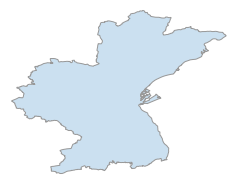

time: 197 ms


In [2]:
city = ox.gdf_from_place('Aarhus Municipality, Denmark')
#city = ox.project_gdf(city)
city.crs = {'init': 'epsg:4326'}
city
fig, ax = ox.plot_shape(city, figsize=(4,4))
ox.save_gdf_shapefile(city)

2258
data max index: 2257
number of NA prices: 0
average bedroom price 56.78402069475241
pointinpoly length: 2257
check contains: True
check if there are NAs: False


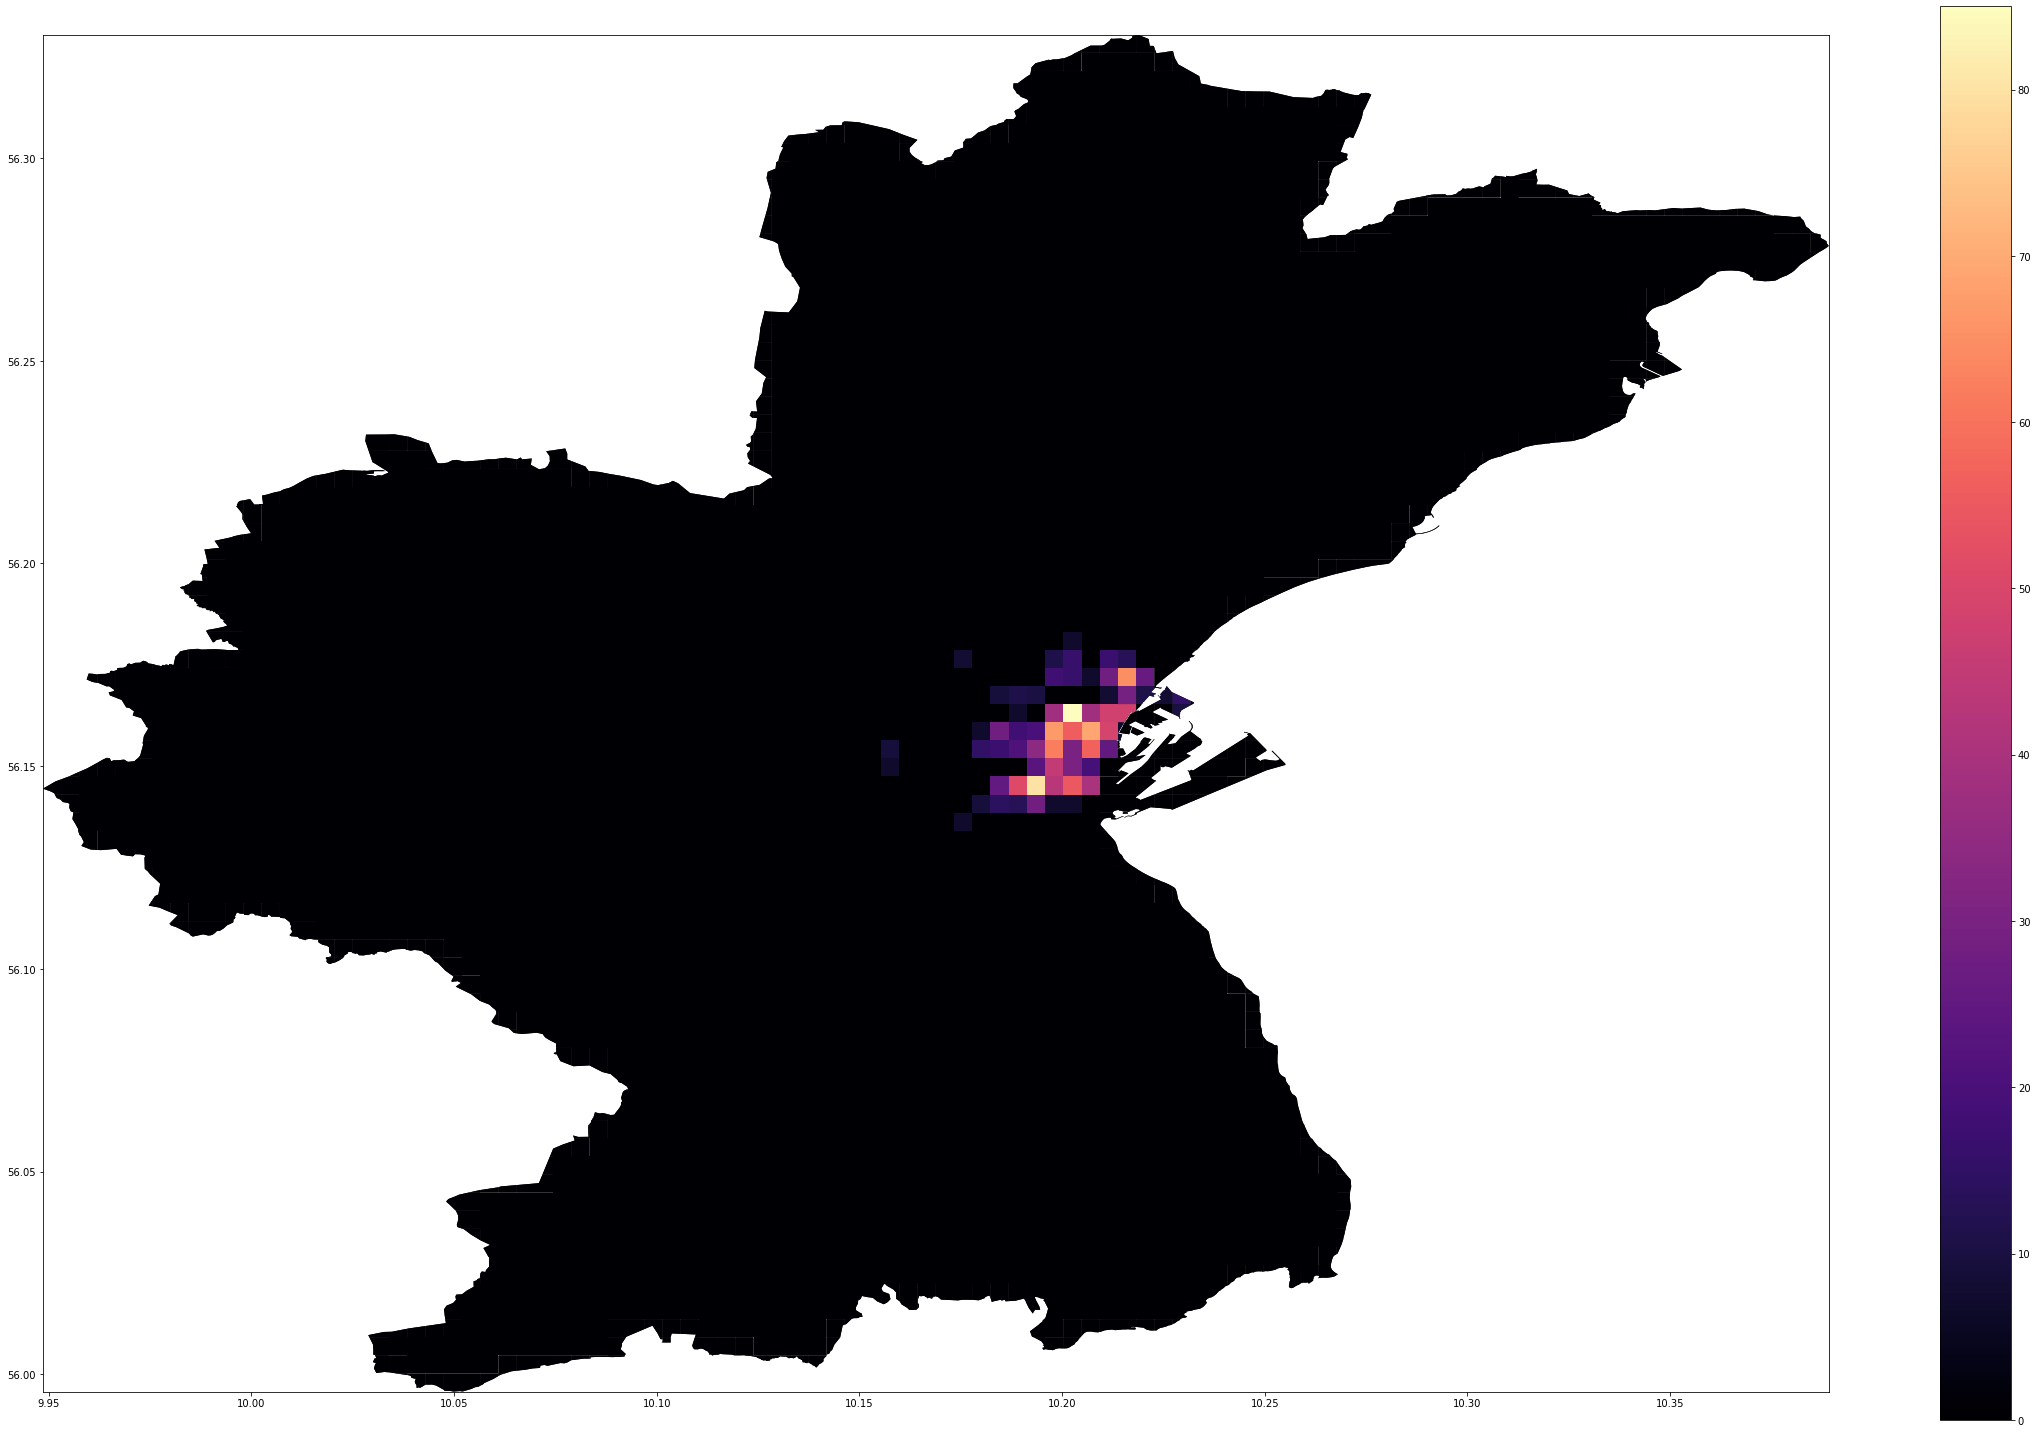

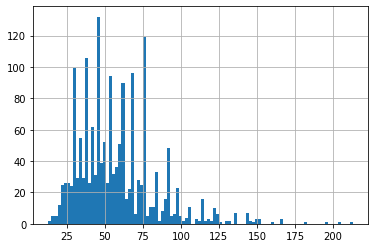

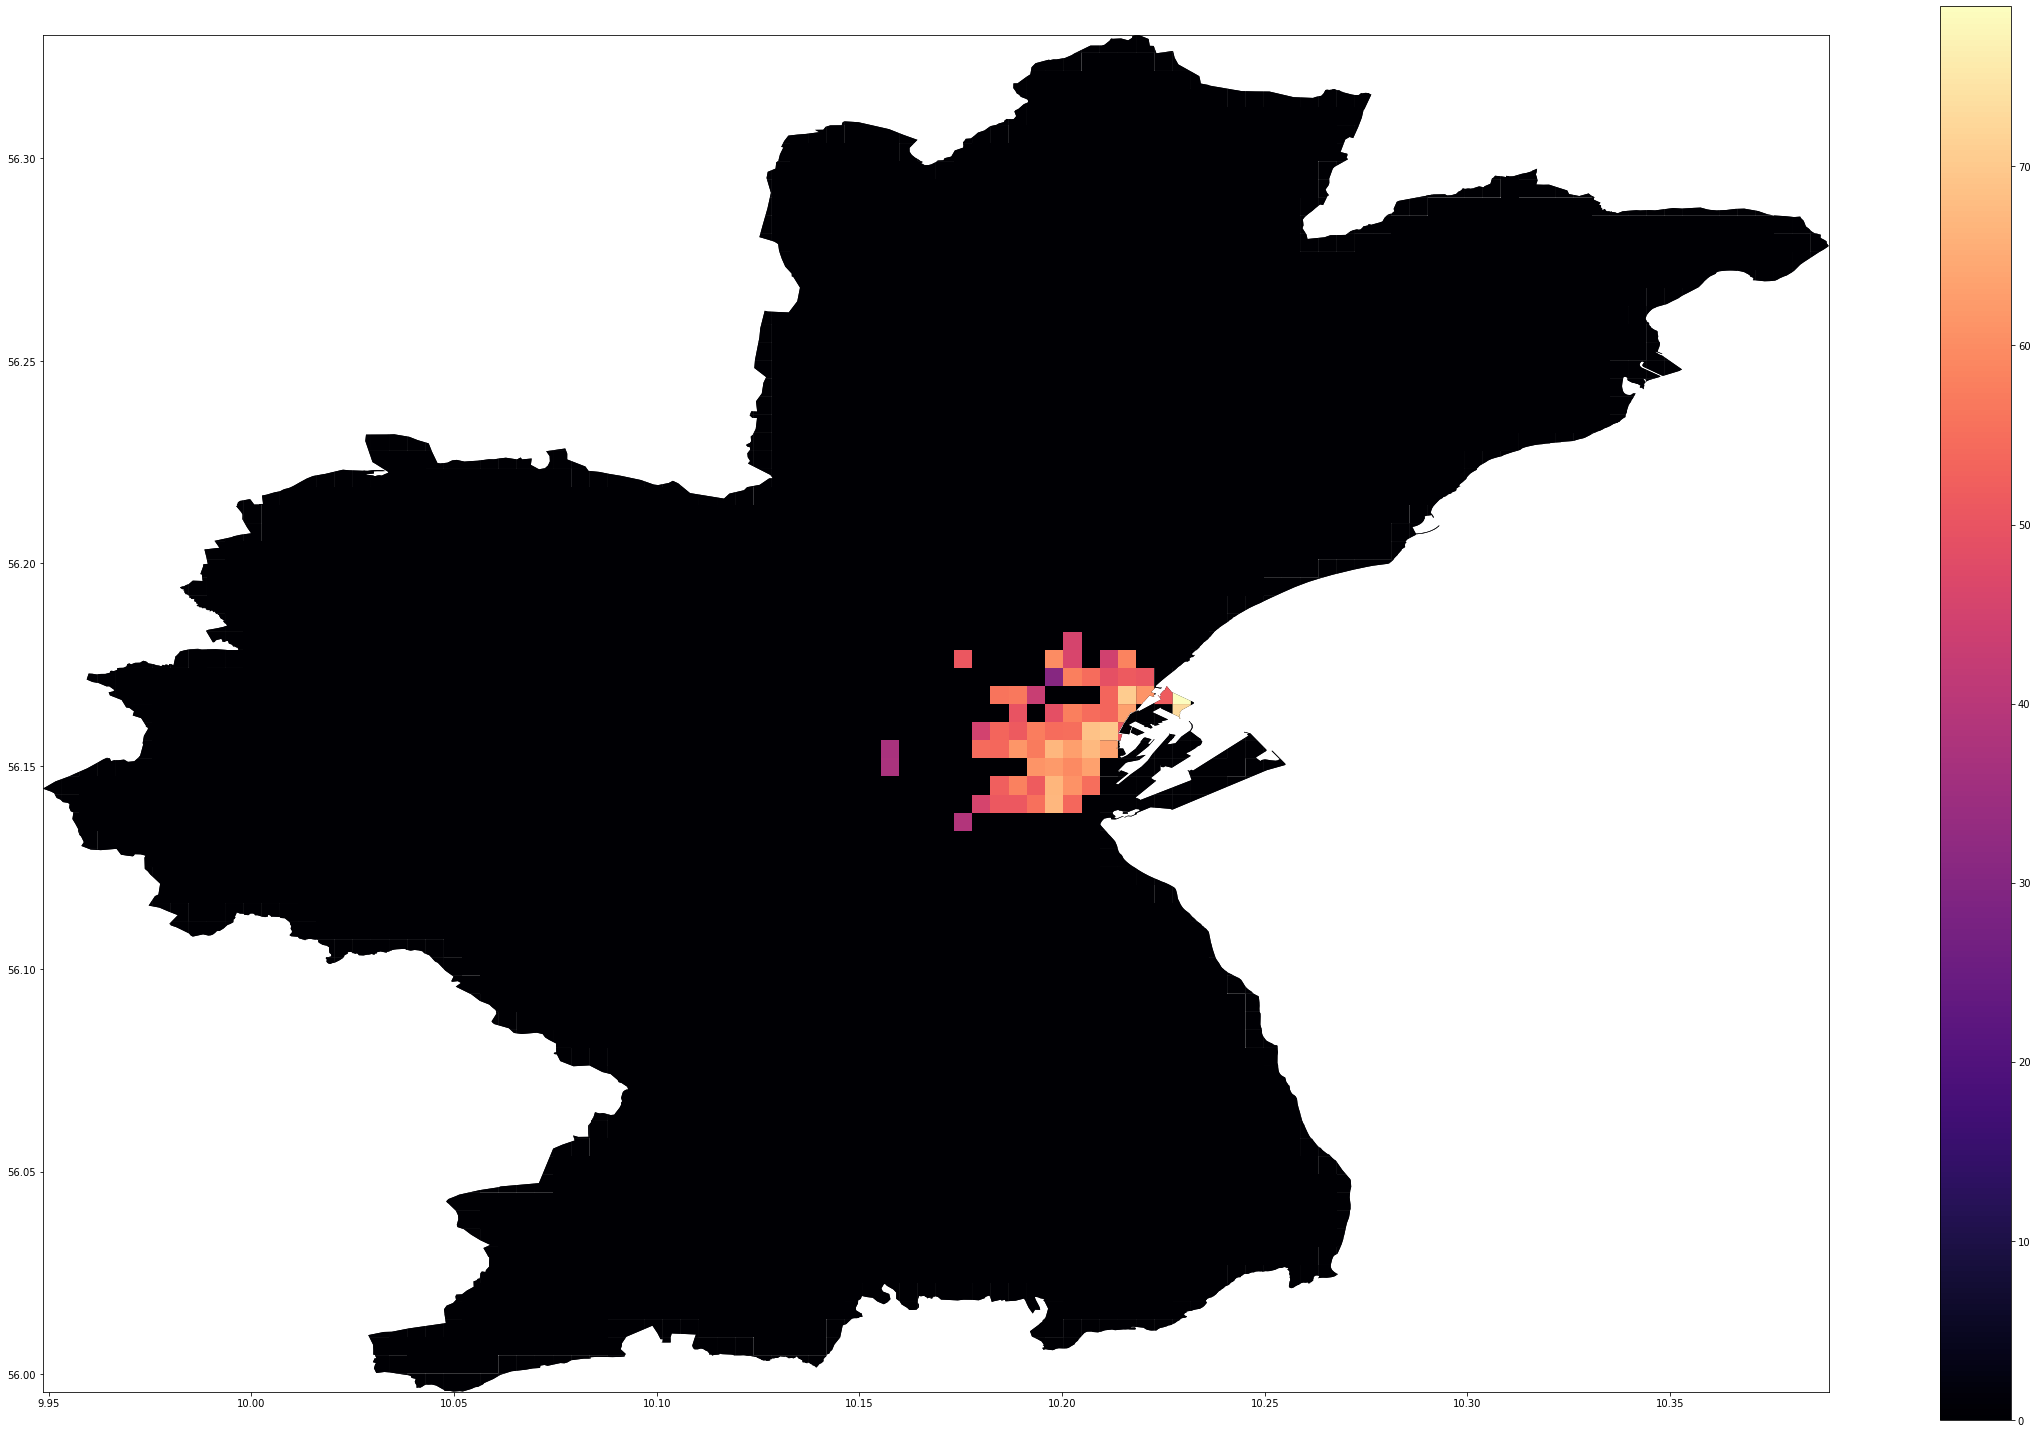

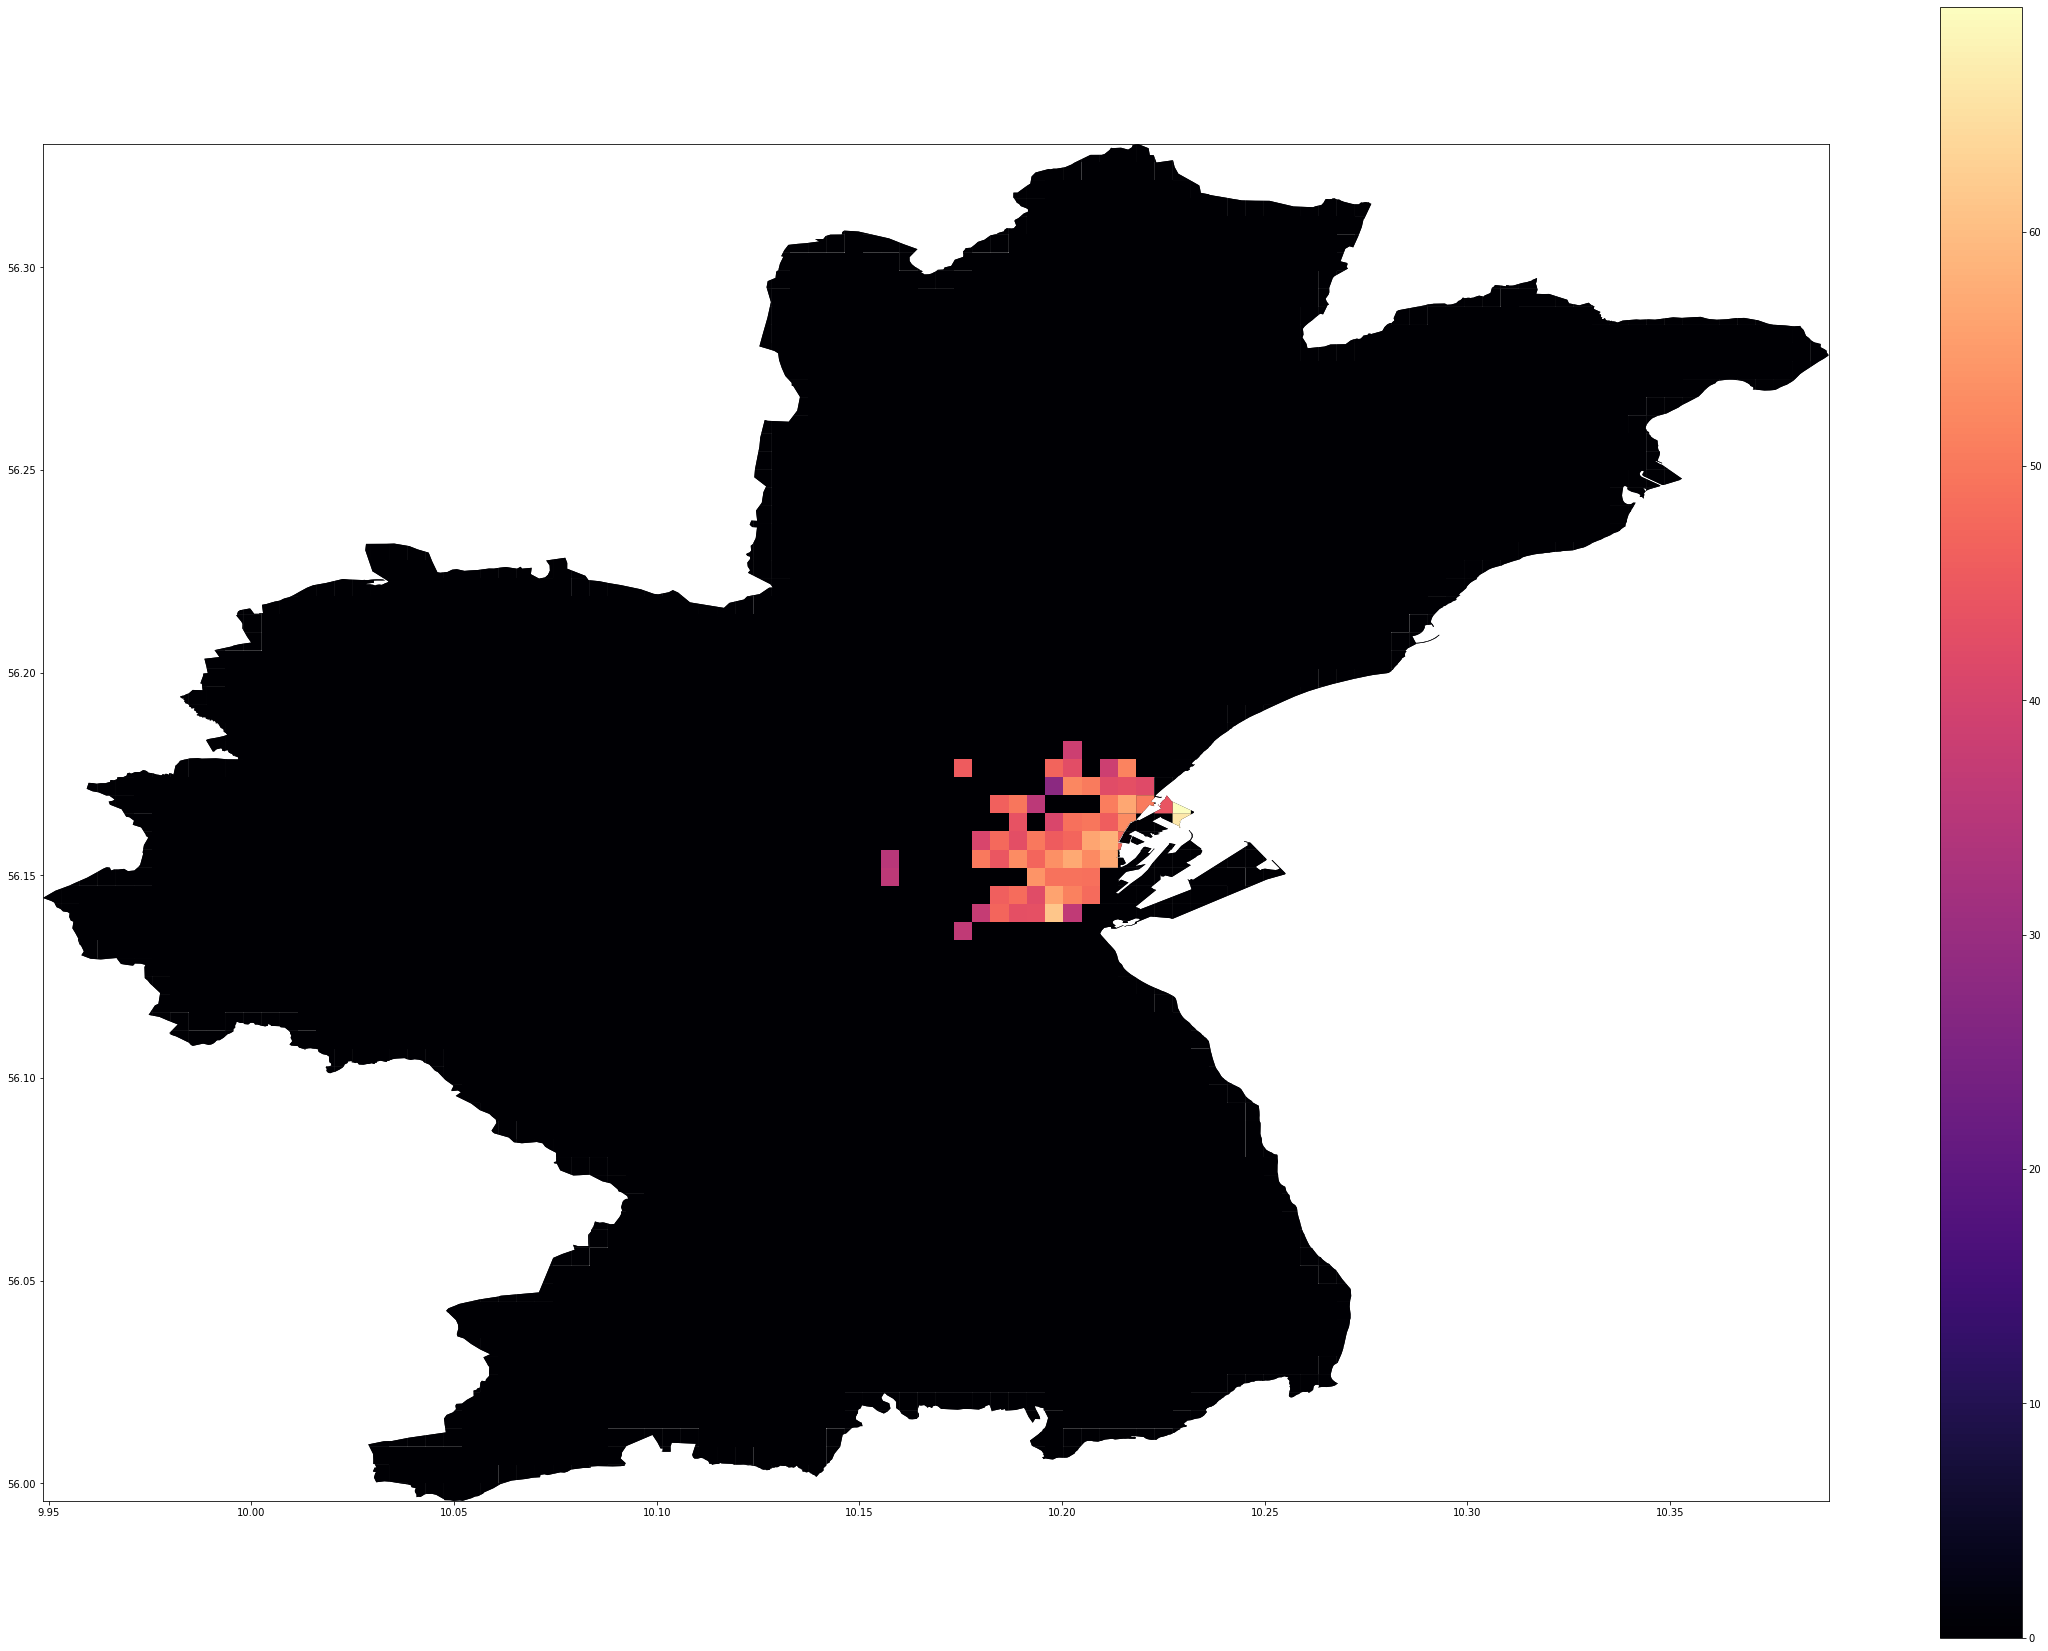

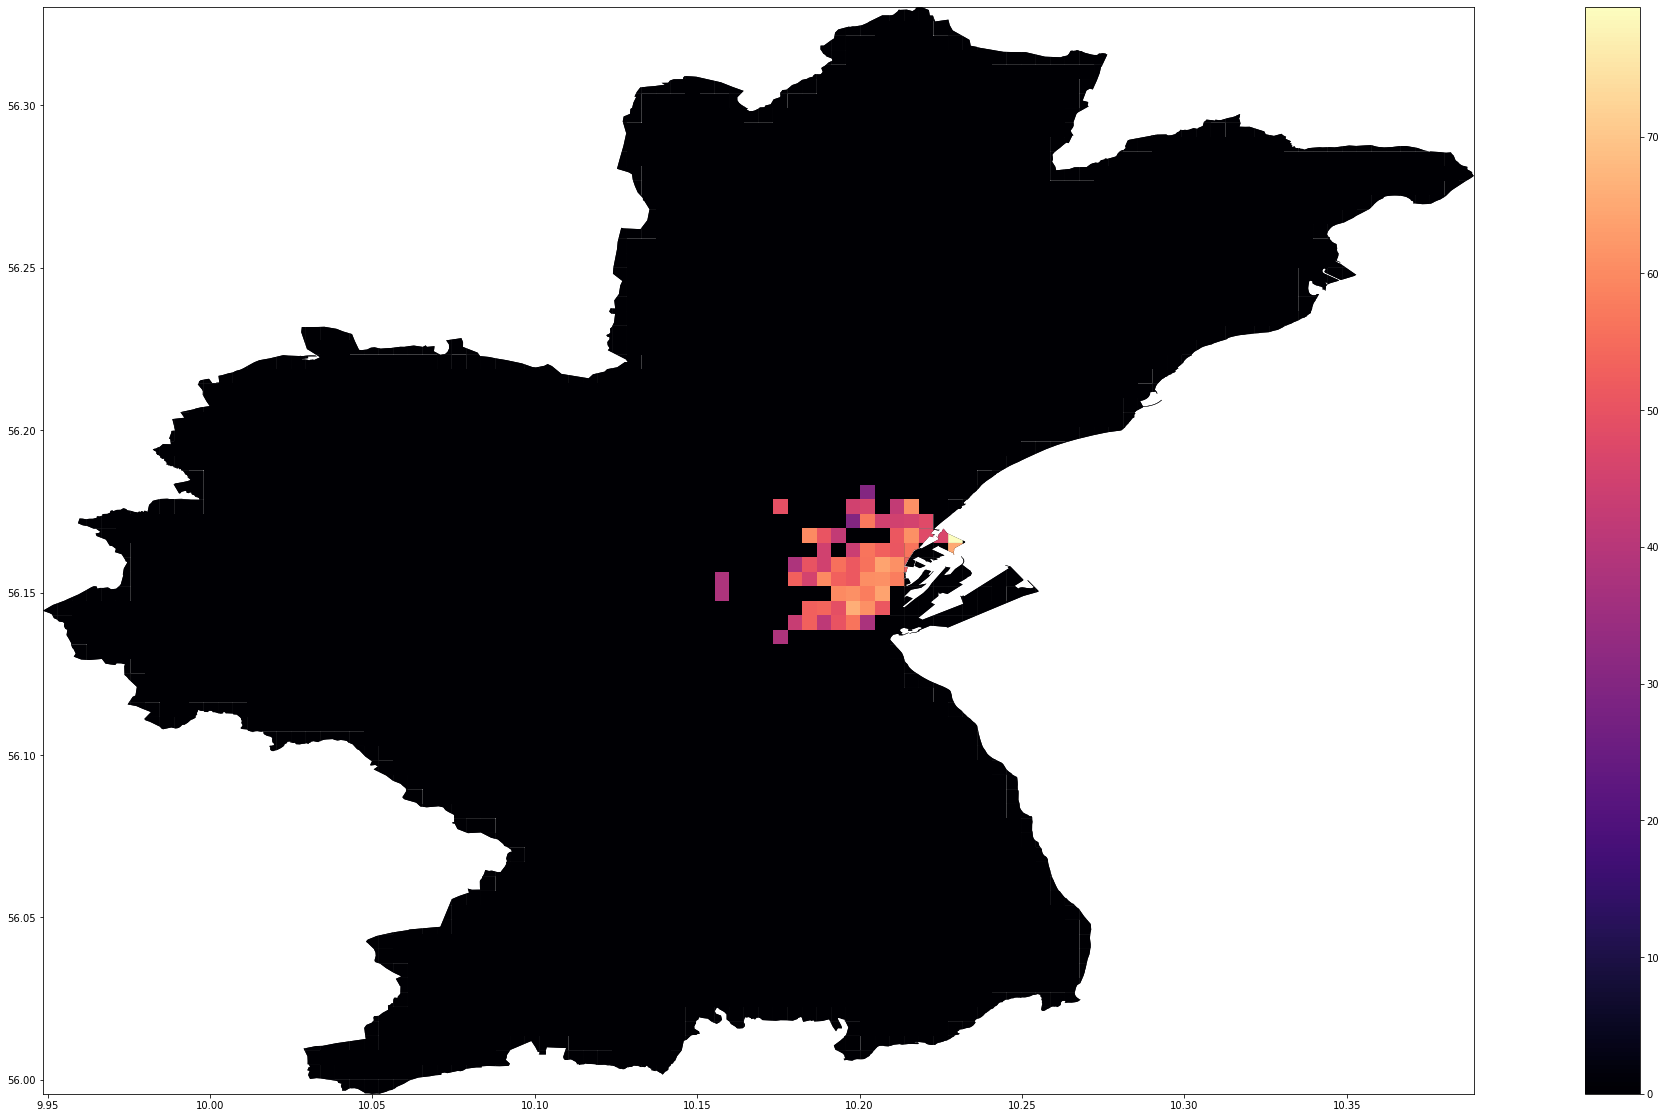

time: 15.8 s


In [6]:
data = pd.read_csv('data/Airbnb_Aarhus.csv', header=0, index_col=0)
data = data[['room_id','latitude', 'longitude', 'bedrooms', 'price']]
print(len(data))

data.reset_index(drop=True, inplace=True)
print("data max index:", data.index.max())
print("number of NA prices:", data.price.isna().sum())

data.loc[data.bedrooms == 0, 'bedrooms'] = 1

price_proom = np.divide(np.array(data[pd.notnull(data['bedrooms'])].price),np.array(data[pd.notnull(data['bedrooms'])].bedrooms))
mean_bed = np.mean(price_proom)
print("average bedroom price",mean_bed)

nan_list = data[data.bedrooms.isna()].index.tolist()
data.loc[data.bedrooms.isna(), 'bedrooms'] = np.ceil(data.loc[data.bedrooms.isna(), 'price']/mean_bed)

geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

meter_500 = 0.00899928/2


# make the geometry a multipolygon if it's not already
geometry = city['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=meter_500)

city['coords'] = city['geometry'].apply(lambda x: x.representative_point().coords[:])
city['coords'] = [coords[0] for coords in city['coords']]

polylist = [p for p in geometry_cut]

polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = city.geometry.crs
polyframe['center_lon'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][0])
polyframe['center_lat'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][1])


pointInPoly = gpd.sjoin(polyframe, gdf, op='contains')
print("pointinpoly length:",len(pointInPoly))

#pointInPoly.sort_values(['PlateID', 'Time'], inplace=True)
pointInPoly['index'] = pointInPoly.index
pointInPoly.reset_index(drop=True, inplace=True)


present_ind = list(pointInPoly['index_right'])
gdf_test_dropped = gdf.iloc[present_ind,:]
gdf_dropped = gdf_test_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)

print("check contains:",polyframe.iloc[pointInPoly.loc[len(pointInPoly)-1, 'index']].geometry.contains(gdf_dropped.loc[len(pointInPoly)-1,'geometry']))
gdf_dropped['pindex'] = pointInPoly['index']

print("check if there are NAs:", gdf_dropped.isna().values.any())

pindex = gdf_dropped.pindex.unique()
airbnb_dict = dict(gdf_dropped.pindex.value_counts())
counts = pd.DataFrame(list(airbnb_dict.items()), columns=['key', 'count'])
counts = counts[counts['count']>6]
counts = counts.copy()
airbnb_dict = dict(zip(list(counts['key']), list(counts['count'])))
polyair = polyframe.copy()
polyair['count'] = 0
polyair['count'].update(pd.Series(airbnb_dict))

# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='count',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


gdf_dropped = gdf_dropped[gdf_dropped.pindex.isin(airbnb_dict.keys())]
gdf_dropped = gdf_dropped.copy()
gdf_dropped = gdf_dropped[gdf_dropped['price'] > 0]
gdf_dropped = gdf_dropped.copy()
gdf_dropped['price_normalized'] = gdf_dropped.price.divide(gdf_dropped.bedrooms)
gdf_dropped = gdf_dropped[gdf_dropped.price_normalized<270]
gdf_dropped = gdf_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)
gdf_dropped.price_normalized.hist(bins=100)

prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].mean())
from scipy import stats
hmean_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].apply(lambda x: stats.hmean(x)))
median_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].median())

polyair['prices'] = 0
polyair['hmean_prices'] = 0
polyair['median_prices'] = 0
polyair['prices'].update(pd.Series(prices_dict))
polyair['hmean_prices'].update(pd.Series(hmean_prices_dict))
polyair['median_prices'].update(pd.Series(median_prices_dict))


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()



# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,30))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='hmean_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


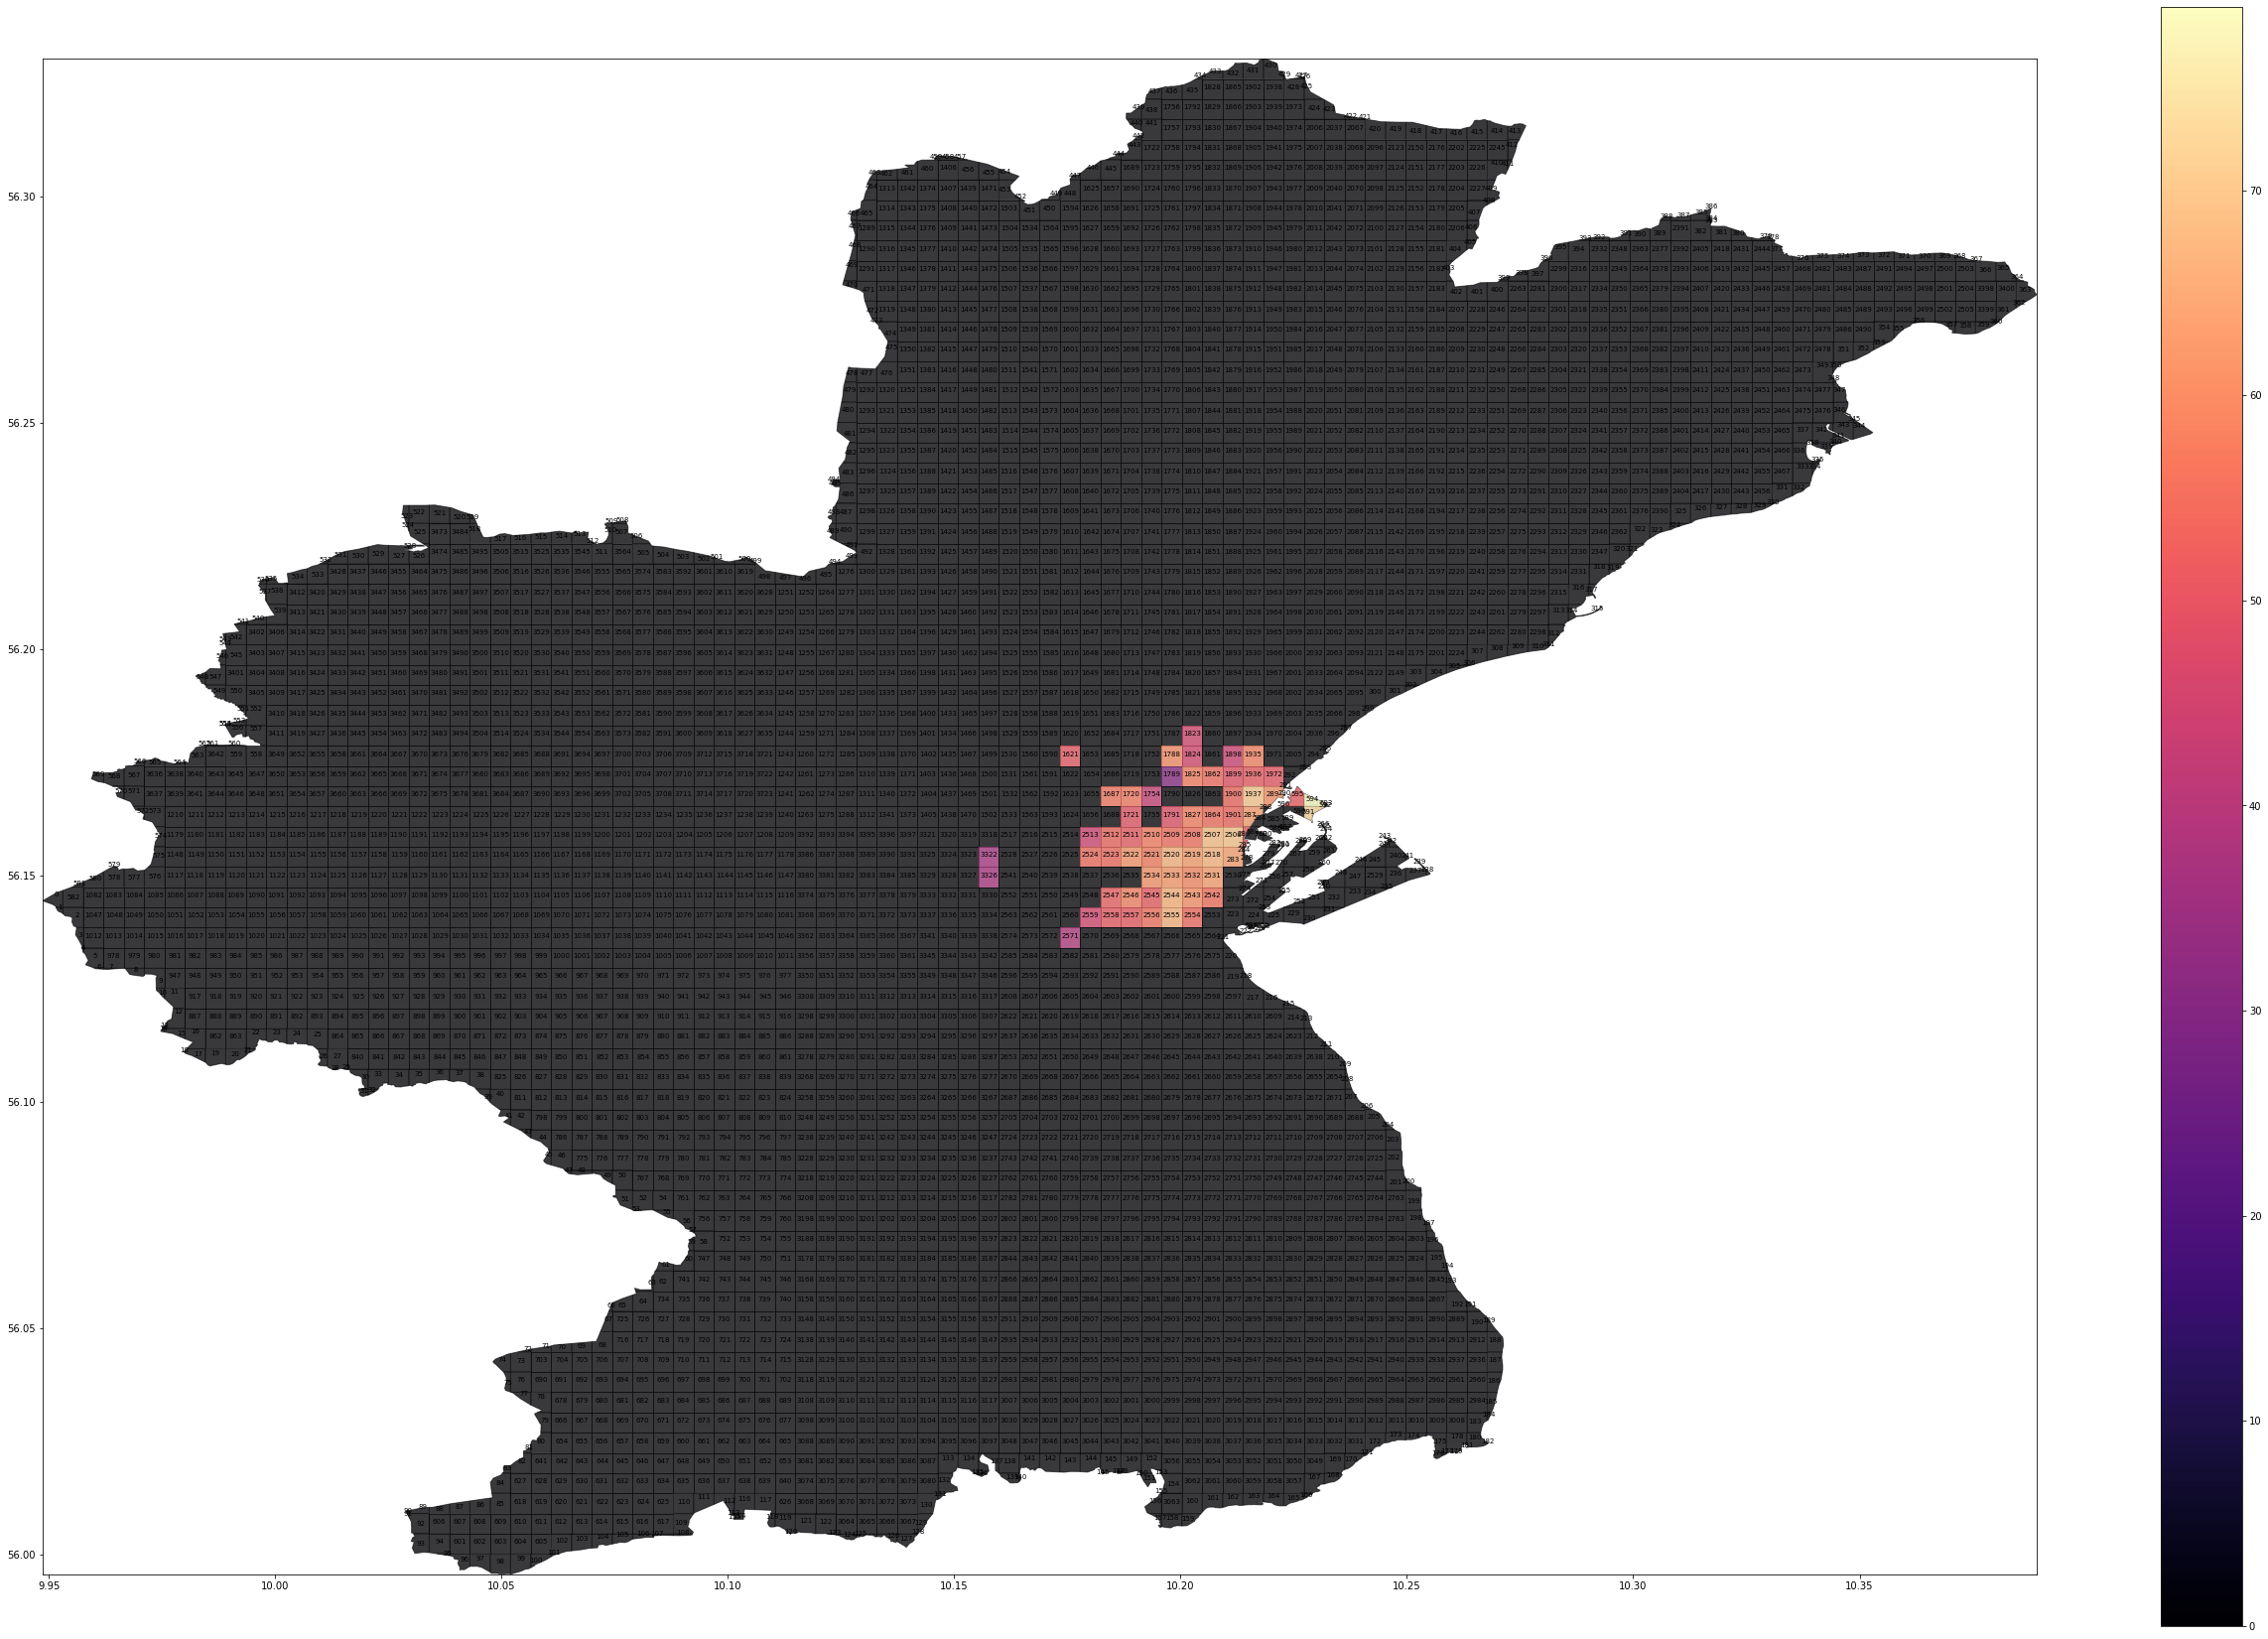

time: 31.9 s


In [7]:
# plot the city
west, south, east, north = city.unary_union.bounds
#fig, ax = plt.subplots(figsize=(40,20))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)


fig, ax = plt.subplots(figsize=(45,30))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5)
    ax.add_patch(patch)
    plt.annotate(s=n, xy=p,
                 horizontalalignment='center', size=7)
polyframe.plot(ax=ax, color='#000004', alpha=0.5)
polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax, alpha=0.7, zorder=2)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

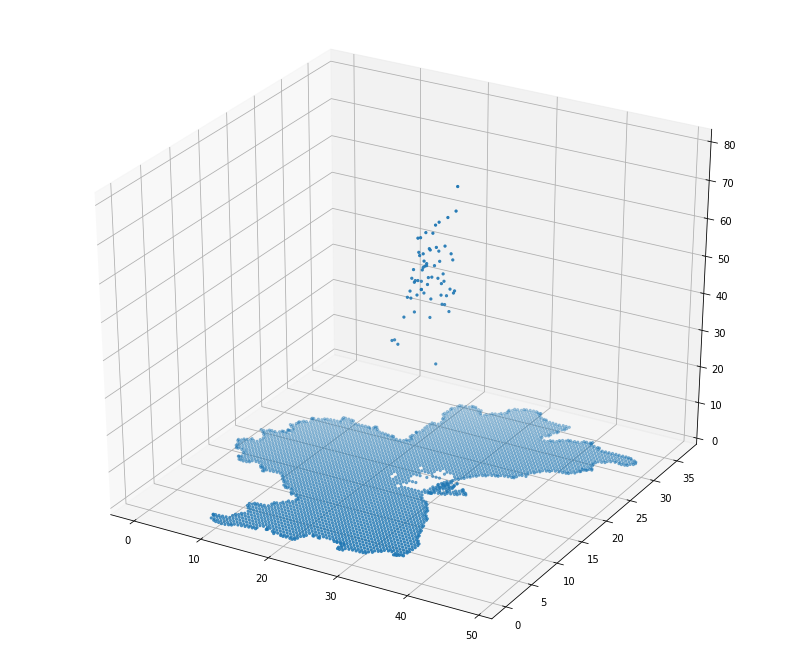

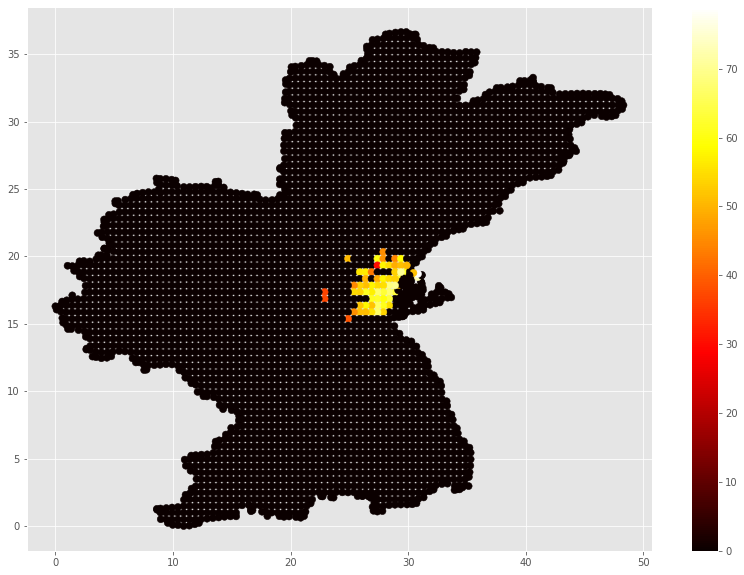

time: 2.16 s


In [8]:
import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
from mpl_toolkits.mplot3d import Axes3D
#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

y = np.array(polyair.center_lat)*500/meter_500 
y = y-y.min()
y = y/1000


# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, np.array(polyair.prices), cmap='plasma', s=5)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(30, 300)
plt.show()


plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,10))
scat = ax.scatter(x, y, c=np.array(polyair.prices), s=50, cmap='hot')
cbar = fig.colorbar(scat)
#cbar.set_clim(0, 250)
plt.savefig('images/Aarhus_observed.jpg')
plt.show()

In [9]:
polyair[polyair.prices==polyair.prices.max()]

geometry  center_lon  \
594  POLYGON ((10.22727115102491 56.16817910693783,...   10.229084   

     center_lat  count     prices  hmean_prices  median_prices  
594   56.166321     15  78.933333     69.587316           79.5

time: 14 ms


In [10]:
cdf = polyair[polyair.index.isin([594, 2506, 1788])]
cdf["cen_lon_km"] = cdf['center_lon'].apply(lambda x: (x*500/meter_500 - (polyair.center_lon*500/meter_500).min())/1000)
cdf["cen_lat_km"] = cdf['center_lat'].apply(lambda x: (x*500/meter_500 - (polyair.center_lat*500/meter_500).min())/1000)
cdf

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



geometry  center_lon  \
594   POLYGON ((10.22727115102491 56.16817910693783,...   10.229084   
1788  POLYGON ((10.19580695816776 56.17870125066217,...   10.198054   
2506  POLYGON ((10.21378649693428 56.16084862132884,...   10.211539   

      center_lat  count     prices  hmean_prices  median_prices  cen_lon_km  \
594    56.166321     15  78.933333     69.587316           79.5   30.838323   
1788   56.176470     11  59.833333     46.762974           45.0   27.390274   
2506   56.158617     49  69.841837     58.247018           61.0   28.888689   

      cen_lat_km  
594    18.704364  
1788   19.832074  
2506   17.848290

time: 374 ms


Fitted parameters:
[112.2357509   30.69805913  18.66137373   0.12337239   0.22420667
   5.4377863    1.87621535  48.16424311  27.4752014   17.87759617
   1.26186614   2.10393886   3.83120675   4.5247693 ]
RMS residual = 3.890463493487695


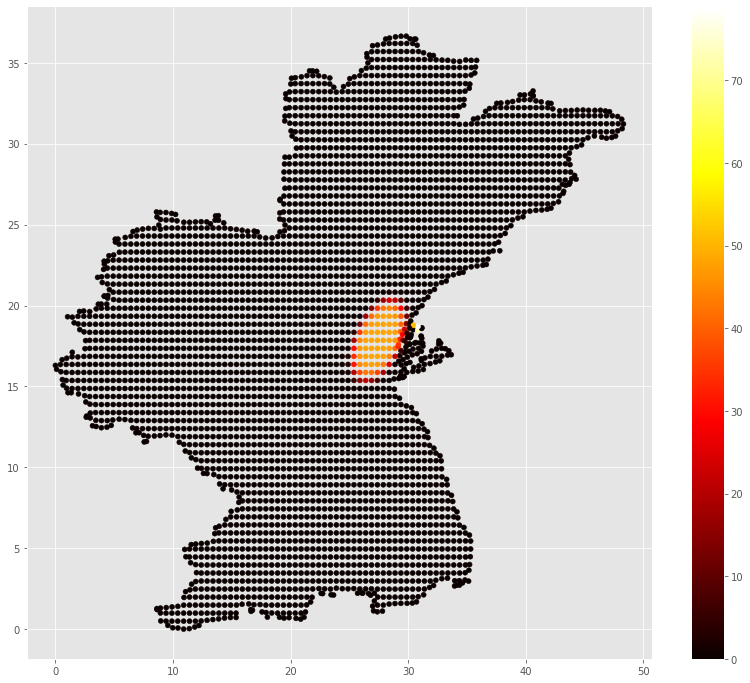

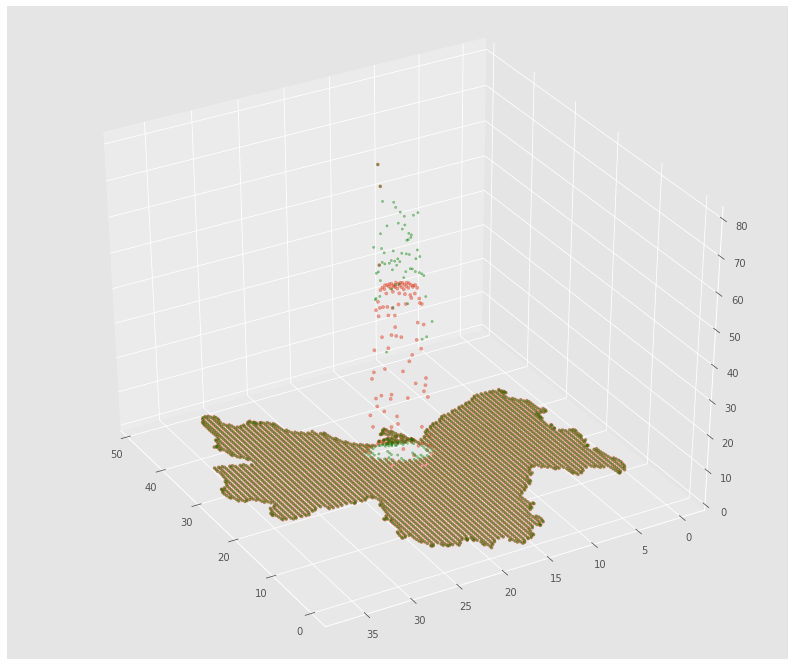

{'Aarhus': 3.2004923276174746}
time: 2.23 s


In [11]:
alphas = {}
xy = np.vstack([x, y])
zobs = np.array(polyair.prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//7):
        arr += twoD_Gaussian_alpha(xy, *args[i*7:i*7+7])
    return arr



guess_prms = [(79.5,30.838323,18.704364, 1, 1.8,3.8, 1),
              #(45,27.390274,19.832074,0.5, 1,0.5),
              (61,28.888689,17.848290, 3, 4,3, 2)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian_alpha(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, alpha):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2))**alpha)
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//7):
    zpred += twoD_Gaussian_alpha(xy, *popt[i*7:i*7+7])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=25, cmap='hot')
fig.colorbar(scat)
plt.savefig('Aarhus_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=10, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=5, alpha=0.4)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(35, 150)
plt.show()

alphas['Aarhus'] = np.mean(popt[6::7])
print(alphas)

In [12]:
import pickle
pickle_in = open("alphas.pickle","rb")
alphas_dict = pickle.load(pickle_in)
#prices_params_dict = {}
alphas_dict['Aarhus'] = 1.87621535
print(alphas_dict)
pickle_out = open("alphas.pickle","wb")
pickle.dump(alphas_dict, pickle_out)
pickle_out.close()

{'Paris': 1.9119263949210794, 'Amsterdam': 1.6077156181165682, 'Stockholm': 1.4869621148124246, 'Arezzo': 1.5291330654483044, 'Berlin': 1.3281036059479567, 'Bordeaux': 1.387341915093677, 'Denver': 0.9886695315944182, 'Edinburgh': 1.7431661910906637, 'Lyon': 1.840995035260712, 'Madrid': 1.561423826026336, 'Buenos_Aires': 2.0626361633770363, 'Los_Angeles': 1.7386638625850566, 'Beijing': 1.77233254047711, 'Florence': 1.052999973906332, 'Moscow': 1.822610958759147, 'Porto': 1.4172416677632145, 'Prague': 1.3671832768992007, 'Reykjavik': 1.4194582940670377, 'Riga': 1.4587192546215861, 'Rome': 1.8608390724186512, 'Seoul': 1.3208669147673713, 'Siena': 0.6212787996336754, 'Sydney': 2.584174464016137, 'Tallin': 2.014994948135572, 'Treviso': 1.07320426583068, 'Valencia': 1.5432619, 'Venezia': 1.3156028460923, 'Verona': 1.4364606330705336, 'Vicenza': 1.20971848439062, 'Vienna': 1.3399164167136137, 'Wellington': 1.46363348, 'Zurich': 1.72383878, 'Aarhus': 1.87621535, 'Milan': 2.1468310347956194, 'B

Fitted parameters:
[49.29136892 29.07595057 19.31271721  0.36379584  1.47114442  5.0369615
 75.94817917 27.35657973 17.26401176  1.01232414  1.32693606  3.95503188]
RMS residual = 4.242319313852713


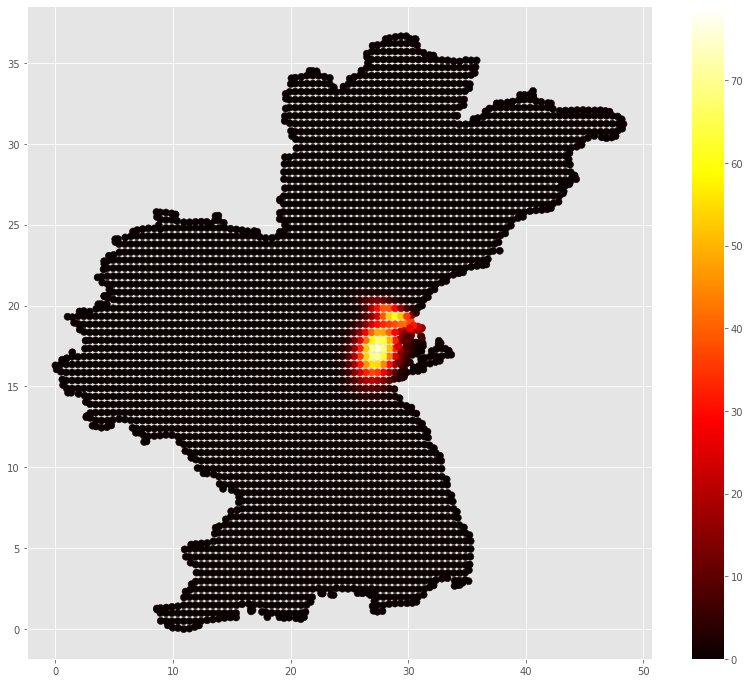

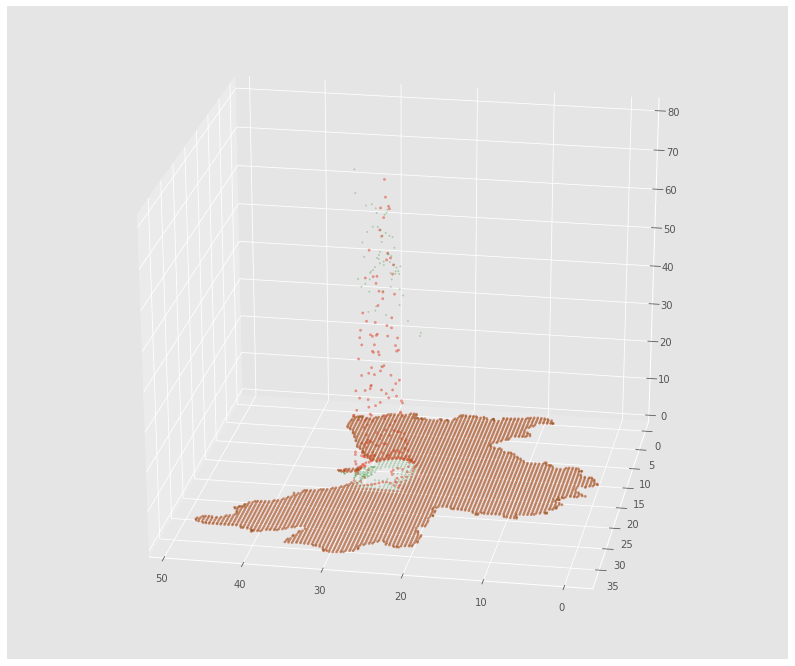

time: 1.89 s


In [13]:
xy = np.vstack([x, y])
zobs = np.array(polyair.prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//6):
        arr += twoD_Gaussian(xy, *args[i*6:i*6+6])
    return arr


guess_prms = [(79.5,30.838323,18.704364, 1, 1.8,3.8),
              #(45,27.390274,19.832074,0.5, 1,0.5),
              (61,28.888689,17.848290, 3, 4,3)
             ]


# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//6):
    zpred += twoD_Gaussian(xy, *popt[i*6:i*6+6])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=50, cmap='hot')
fig.colorbar(scat)
plt.savefig('Aarhus_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=2, alpha=0.2)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(25, 100)
plt.show()

In [14]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

sqrt_eigs_long = np.array([])
sqrt_eigs_short = np.array([])
for i in range(0, len(popt), 6):
    a = (np.cos(popt[i+5])**2)/(2*popt[i+3]**2) + (np.sin(popt[i+5])**2)/(2*popt[i+4]**2)
    b = -(np.sin(2*popt[i+5]))/(4*popt[i+3]**2) + (np.sin(2*popt[i+5]))/(4*popt[i+4]**2)
    c = (np.sin(popt[i+5])**2)/(2*popt[i+3]**2) + (np.cos(popt[i+5])**2)/(2*popt[i+4]**2)
    cov = np.array([a, b, b, c]).reshape(-1, 2)
    print("Is cov_{} positive definite?: ".format(i//6+1), is_pos_def(cov))
    eigenvalues = np.linalg.eigvals(cov)
    eigenvalues = eigenvalues[eigenvalues>0]
    if eigenvalues.size!=0:
        stds = np.sqrt(eigenvalues)/popt[i]
        #stds = stds[stds>=0]
        sqrt_eigs_long = np.append(sqrt_eigs_long,max(stds))
        sqrt_eigs_short = np.append(sqrt_eigs_short,min(stds))

print('long stds: ', sqrt_eigs_long, 'mean: ', np.mean(sqrt_eigs_long))
print('short stds: ', sqrt_eigs_short, 'mean: ', np.mean(sqrt_eigs_short))

Is cov_1 positive definite?:  True
Is cov_2 positive definite?:  True
long stds:  [0.03943269 0.00919704] mean:  0.024314864280088794
short stds:  [0.00975122 0.00701645] mean:  0.00838383509138684
time: 6 ms


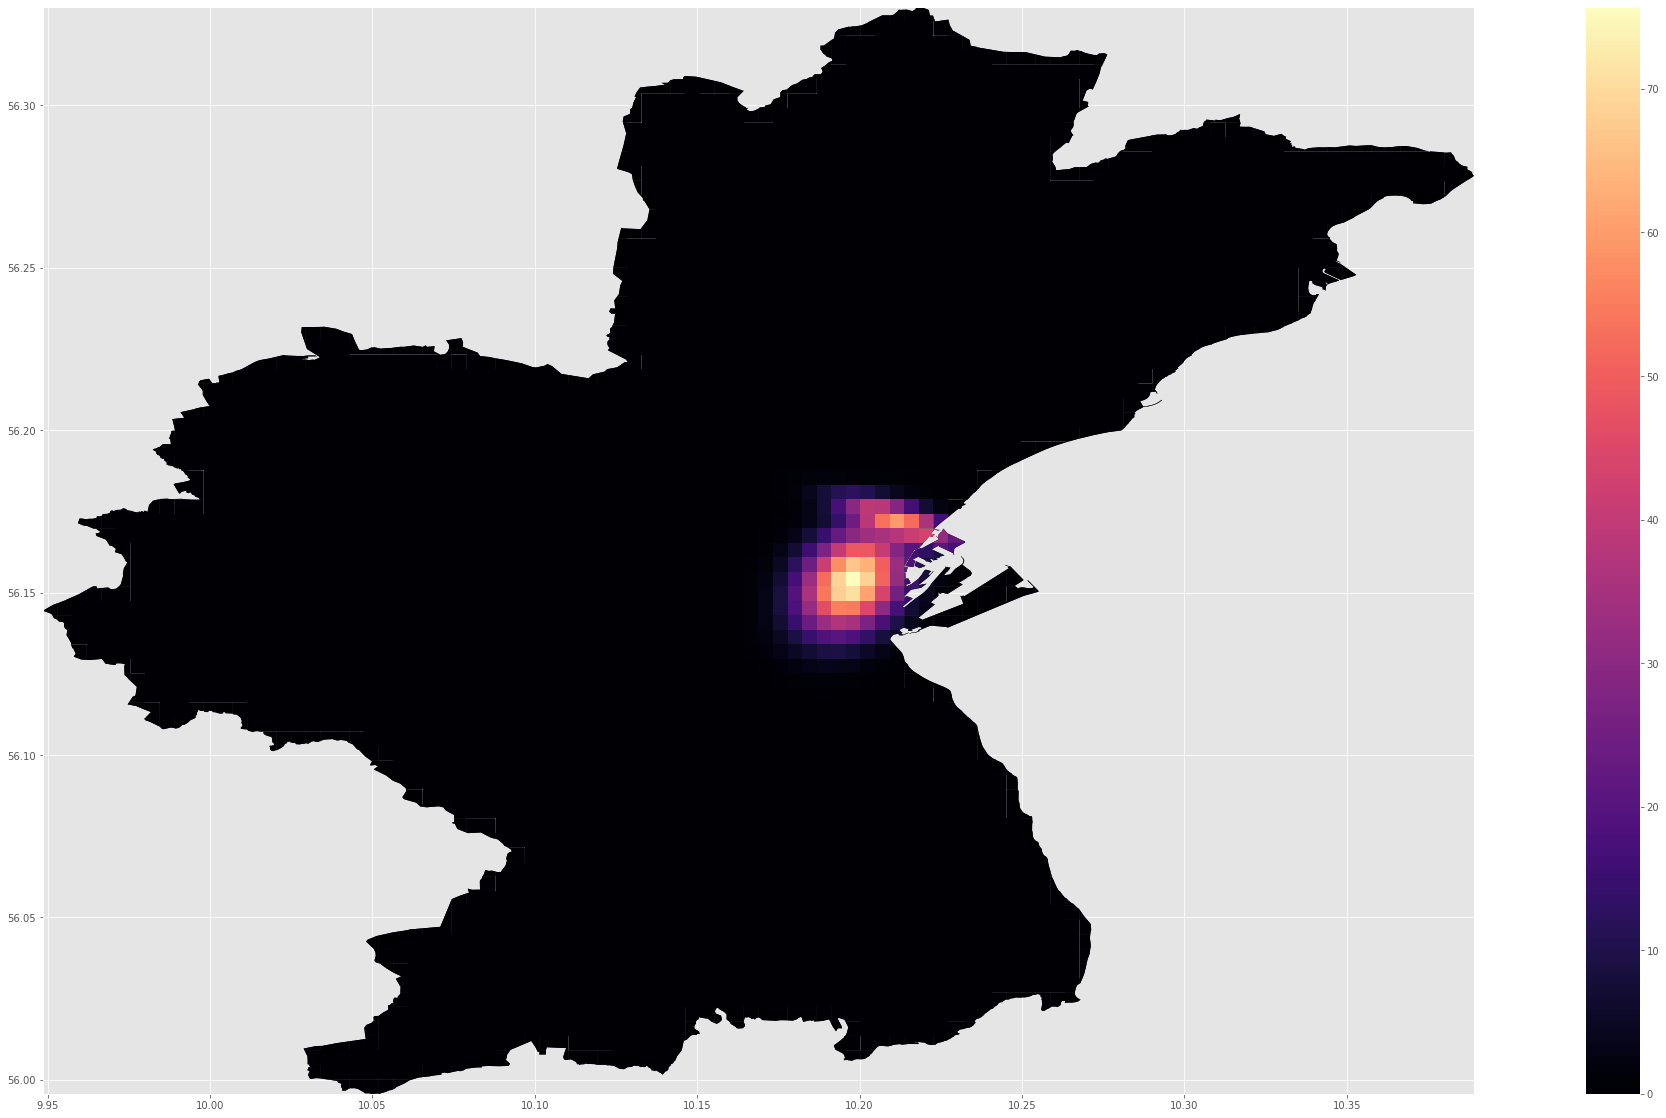

time: 1.85 s


In [15]:
polyair['zpred'] = zpred
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='zpred',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [16]:
import pickle
pickle_in = open("Prices_params.pickle","rb")
prices_params_dict = pickle.load(pickle_in)
#prices_params_dict = {}
prices_params_dict['Aarhus'] = popt
pickle_out = open("Prices_params.pickle","wb")
pickle.dump(prices_params_dict, pickle_out)
pickle_out.close()

#average_slopes = {}
pickle_in_long = open("Average_price_slopes_long.pickle","rb")
average_slopes_long = pickle.load(pickle_in_long)
average_slopes_long['Aarhus'] = np.mean(sqrt_eigs_long)
pickle_out_long = open("Average_price_slopes_long.pickle","wb")
pickle.dump(average_slopes_long, pickle_out_long)
pickle_out_long.close()

pickle_in_short = open("Average_price_slopes_short.pickle","rb")
average_slopes_short = pickle.load(pickle_in_short)
average_slopes_short['Aarhus'] = np.mean(sqrt_eigs_short)
pickle_out_short = open("Average_price_slopes_short.pickle","wb")
pickle.dump(average_slopes_short, pickle_out_short)
pickle_out_short.close()

print('long: ', average_slopes_long, '\n', '\n', ' short: ', average_slopes_short)

long:  {'Paris': 0.010453121182320417, 'Amsterdam': 0.017790862401138207, 'Stockholm': 0.01160078748441716, 'Arezzo': 0.012661960610292892, 'Berlin': 0.017168942092868542, 'Bordeaux': 0.0057209390468692745, 'Denver': 0.00873766709683174, 'Edinburgh': 0.012921100209712873, 'Lyon': 0.00594530194011358, 'Madrid': 0.01315080289968449, 'Buenos_Aires': 0.00938788752473718, 'Palermo': 0.02659431146972356, 'Los_Angeles': 0.0056655377791732745, 'Beijing': 0.03548021455387483, 'Florence': 0.011913882705309832, 'Moscow': 0.026524810524746, 'Porto': 0.03745056113103571, 'Prague': 0.01850581507565583, 'Reykjavik': 0.04000475004839031, 'Riga': 0.02150786435094239, 'Rome': 0.009635062558537275, 'Seoul': 0.013154650694260608, 'Siena': 0.013838139160990736, 'Sydney': 0.009200022664460229, 'Tallin': 0.024848430854086192, 'Treviso': 0.015264513943951563, 'Valencia': 0.01982718757582555, 'Venezia': 0.013133572970121148, 'Verona': 0.01119208328282184, 'Vicenza': 0.029546407262138693, 'Vienna': 0.0120270170

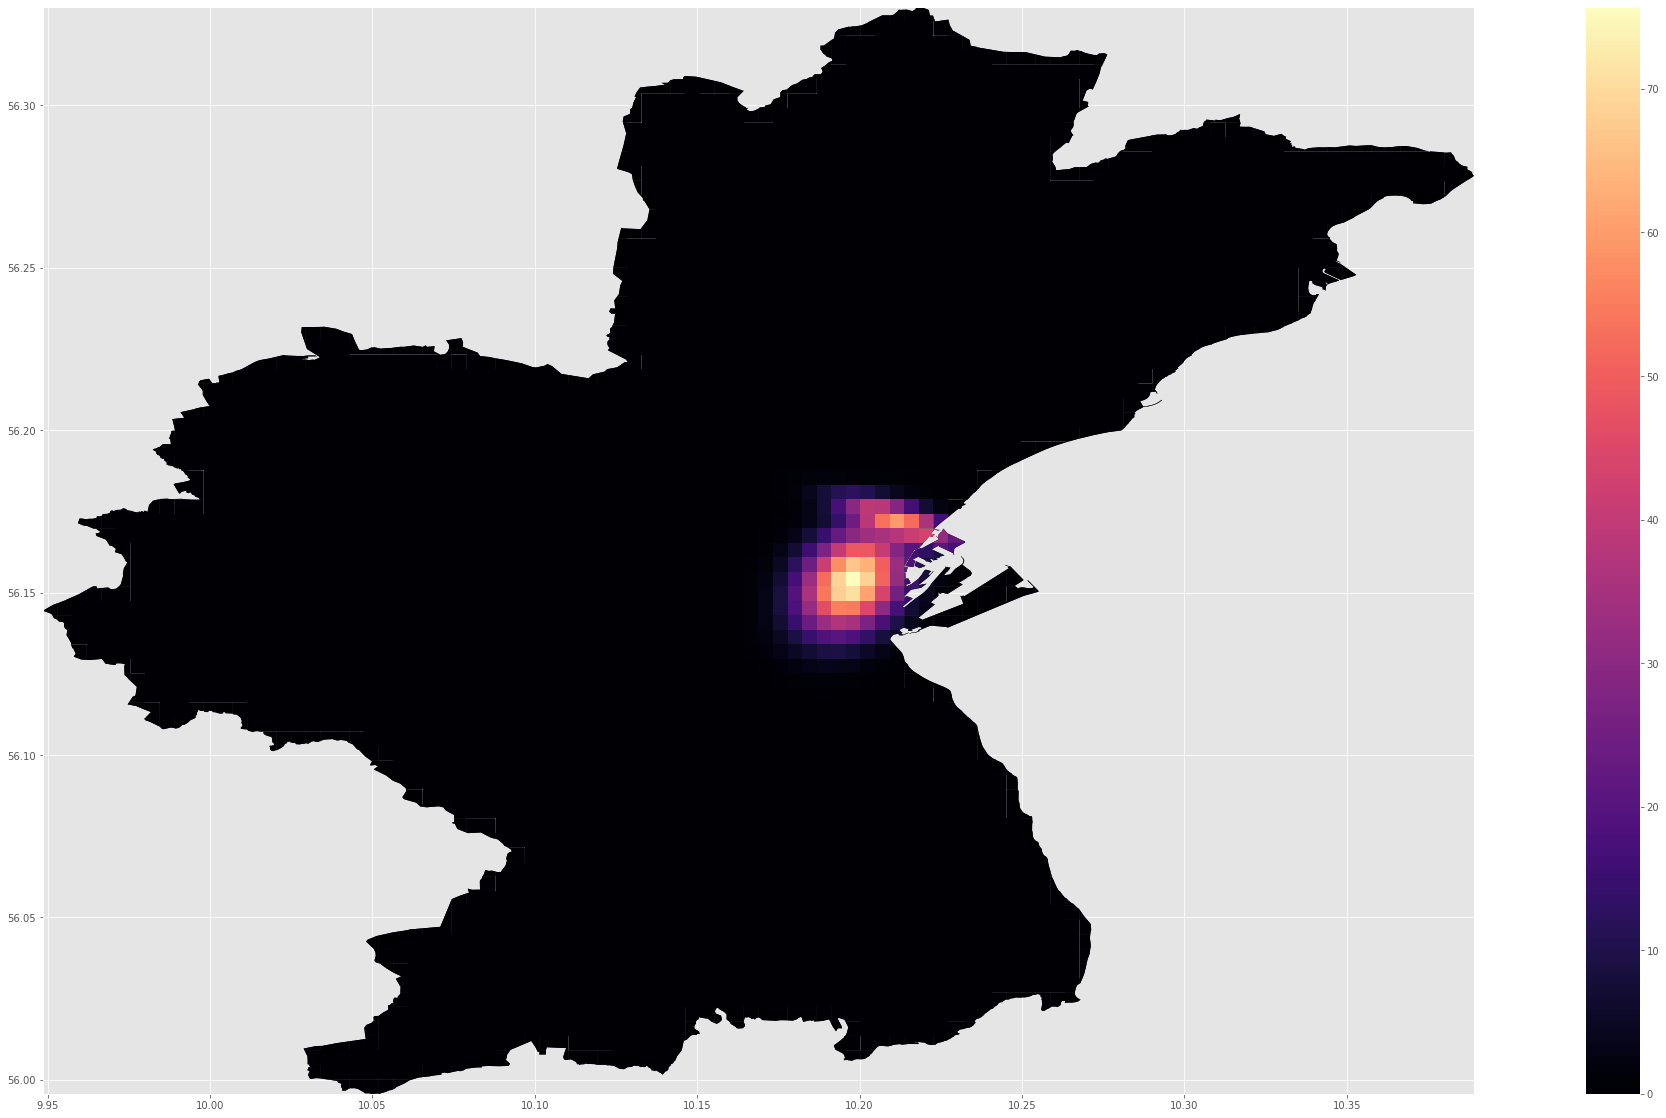

time: 2.12 s


In [17]:
polyair['zpred'] = zpred
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='zpred',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

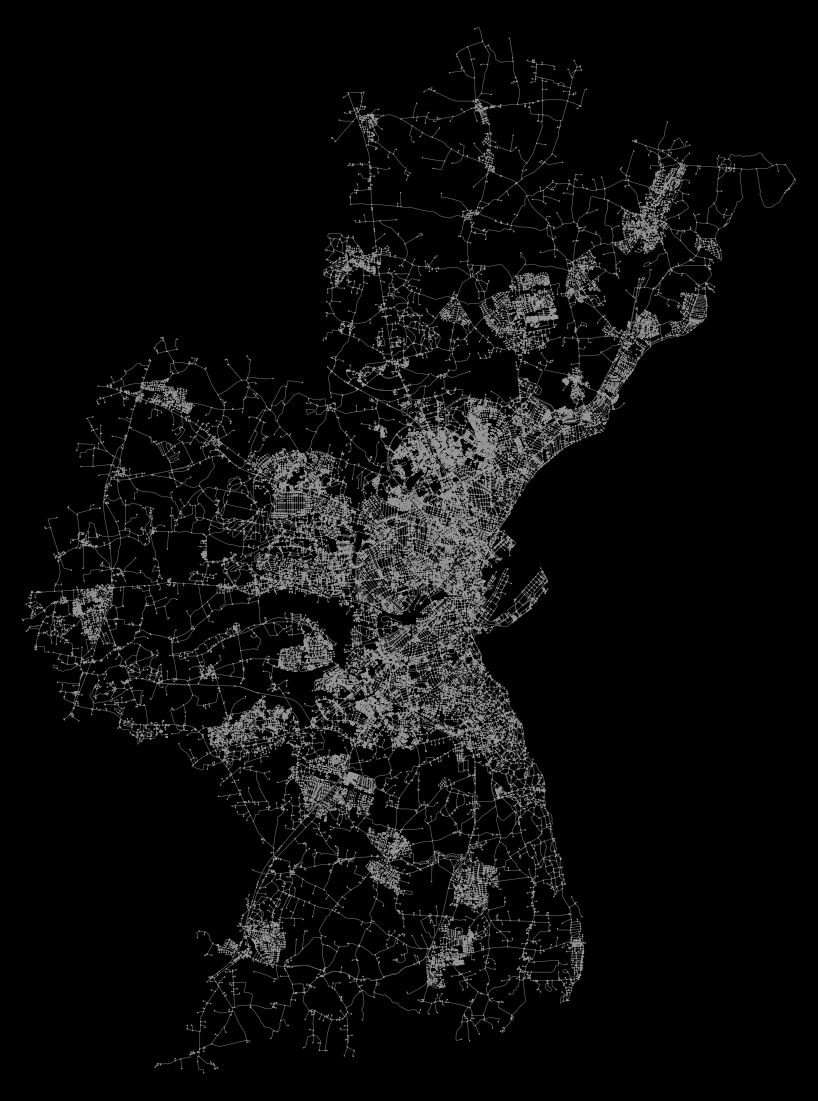

time: 1min 36s


In [18]:
# download and project a street network
G = ox.graph_from_place('Aarhus Municipality, Denmark', network_type="walk")
#G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, fig_height=20, bgcolor='k', node_size=2, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=0.5, edge_alpha=1)

In [19]:
centers = {}
for i in range(0, len(popt), 6):
    lon = popt[i+1]*1000 + (np.array(polyair.center_lon)*500/meter_500).min()
    lon = lon*meter_500/500
    lat = popt[i+2]*1000 + (np.array(polyair.center_lat)*500/meter_500).min()
    lat = lat*meter_500/500
    centers['center_node_{}'.format(i//6+1)] = ox.get_nearest_node(G, (lat,lon))

centers

{'center_node_1': 255957736, 'center_node_2': 3140118116}

time: 193 ms


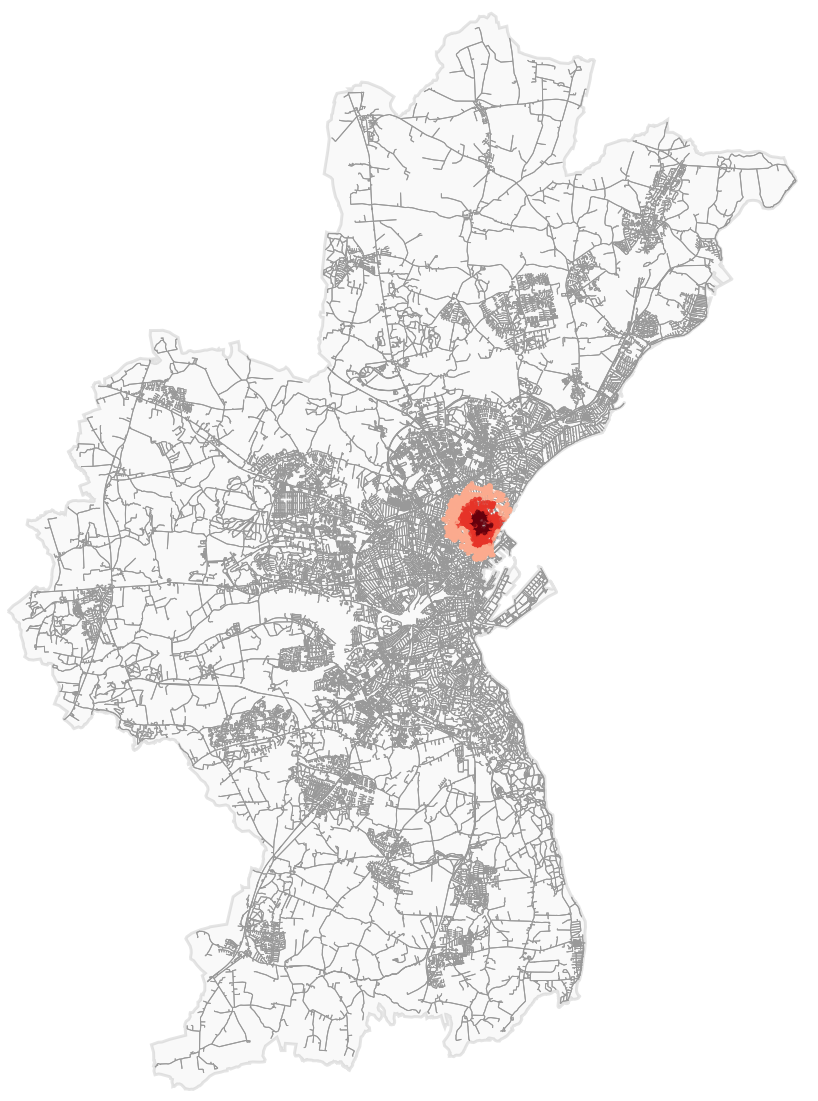

time: 23.1 s


In [20]:
import networkx as nx
#center_node = ox.get_nearest_node(G, (popt[8],popt[7]))
center_node = centers['center_node_1']
# list of distances from center
dists = np.arange(500, 2000, 500)
dists

# get one color for each isochrone
iso_colors = ox.get_colors(n=len(dists), cmap='Reds', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for dist, color in zip(sorted(dists, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=dist, distance='length')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=20,show=False, close=False, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)
plt.close()
# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in city['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='#cccccc', ec='k', linewidth=3, alpha=0.1, zorder=-1)
            ax.add_patch(patch)
            
fig

3724
3724 141
Number of cells with price above 5th percentile:  141



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes


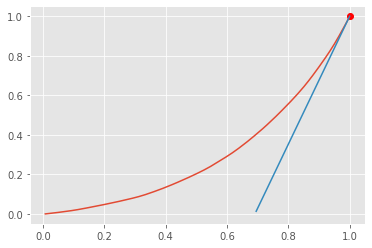

Loubar price:  31.946059838734993
Average price:  24.524524270690844
average city distance:  2857.919349359045
eta =  0.706750760235781
time: 6.16 s


In [21]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))



mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)
    
print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True

  
if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No") 
    
    
L1= L
F1 = np.arange(1, len(L1)+1)/len(L1)

L1 = (L1 - L1.min())/(L1.max()-L1.min())

from scipy import interpolate
tck = interpolate.splrep(F1,L1)
x0_1 =1
y0_1 = interpolate.splev(x0_1,tck)
dydx = interpolate.splev(x0_1,tck,der=1)
tngnt1 = lambda x: dydx*x + (y0_1-dydx*x0_1)
plt.plot(F1, L1)
plt.plot(x0_1,y0_1, "or")
plt.plot(F1[tngnt1(F1)>0],tngnt1(F1[tngnt1(F1)>0]), label="tangent")
plt.show()

indlist = poly_prices.index.tolist()

loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

print('Loubar price: ', loubar_val)
print('Average price: ', np.mean(vals_cut))

if loubar_val > np.mean(vals_cut):
    loubar_keys = keys[vals_cut>loubar_val]
else:
    loubar_keys = keys[vals_cut>np.mean(vals_cut)]
#loubar_keys = keys[vals_cut>loubar_val]
dist_mat = mat[keys.reshape(-1,1), keys]

total_dist = dist_mat.sum()
dist_corr = dist_mat[dist_mat>0]

loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]
loubar_dist = loubar_dist_mat.sum()

loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
eta_loubar = loubar_dist_corr.mean()/dist_corr.mean()

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

avg_dist_meters = (dist_corr.mean()/0.00899928)*1000
print('average city distance: ', avg_dist_meters)
print('eta = ', eta_loubar)

In [23]:
pickle_in = open("City_spreading_index.pickle","rb")
spreading_index_dict = pickle.load(pickle_in)
#spreading_index_dict = {}
spreading_index_dict['Aarhus'] = eta_loubar


pickle_out = open("City_spreading_index.pickle","wb")
pickle.dump(spreading_index_dict, pickle_out)
pickle_out.close()

spreading_index_dict

{'Paris': 0.7251609142253275,
 'Amsterdam': 0.6513935879350918,
 'Stockholm': 0.6839327295656318,
 'Arezzo': 0.5574311537992848,
 'Berlin': 0.7499866909236614,
 'Bordeaux': 0.5818334466519048,
 'Denver': 0.6312111392217781,
 'Edinburgh': 0.6813298654934006,
 'Lyon': 0.6138305864151811,
 'Madrid': 0.6426066210787698,
 'Buenos_Aires': 0.8337988194080271,
 'Palermo': 0.8841435007903967,
 'Los_Angeles': 0.7889452782510832,
 'Beijing': 0.6425383574699105,
 'Florence': 0.5049117106731263,
 'Moscow': 0.6925493573699144,
 'Porto': 0.7058843952576399,
 'Prague': 0.5522963433539414,
 'Reykjavik': 0.8276260142343259,
 'Riga': 0.6850021296374689,
 'Rome': 0.5803964773671335,
 'Seoul': 0.8924742030382572,
 'Siena': 0.5646389917673048,
 'Sydney': 0.7909301400958108,
 'Tallin': 0.5690189423395199,
 'Treviso': 0.5345662066021125,
 'Valencia': 0.6956994914059091,
 'Venezia': 0.656650370883064,
 'Verona': 0.5707647012625697,
 'Vicenza': 0.5117751186840898,
 'Vienna': 0.6189242538490607,
 'Wellington': 0

time: 8 ms


In [24]:
pickle_in = open("avg_distances_dict.pickle","rb")
avg_distances_dict = pickle.load(pickle_in)
#avg_distances_dict = {}
avg_distances_dict['Aarhus'] = avg_dist_meters


pickle_out = open("avg_distances_dict.pickle","wb")
pickle.dump(avg_distances_dict, pickle_out)
pickle_out.close()

avg_distances_dict

{'Venezia': 2398.636425932576,
 'Verona': 3141.8502884813342,
 'Vicenza': 1988.2224372858566,
 'Vienna': 5125.89366602888,
 'Wellington': 2806.4963410749997,
 'Zurich': 2068.4583585914684,
 'Aarhus': 2857.919349359045,
 'Milan': 6008.128043000454,
 'Busan': 7348.804402235624,
 'Valencia': 4090.433301180094,
 'Bologna': 2104.4589605649485,
 'Barcelona': 4218.232625020259,
 'Bremen': 3772.1380465457137,
 'Brno': 2231.9772664038364,
 'Budapest': 3463.3335339061914,
 'Dublin': 4138.1465107736385,
 'Boston': 5610.60832524716,
 'Rio': 8357.334811118957,
 'NY': 8563.096975538809,
 'Ottawa': 2220.3476963993976,
 'Nashville': 5606.900406329212,
 'New_Orleans': 5048.047130029565,
 'Shanghai': 5452.583570486633,
 'Portland': 5406.388840795854}

time: 5 ms


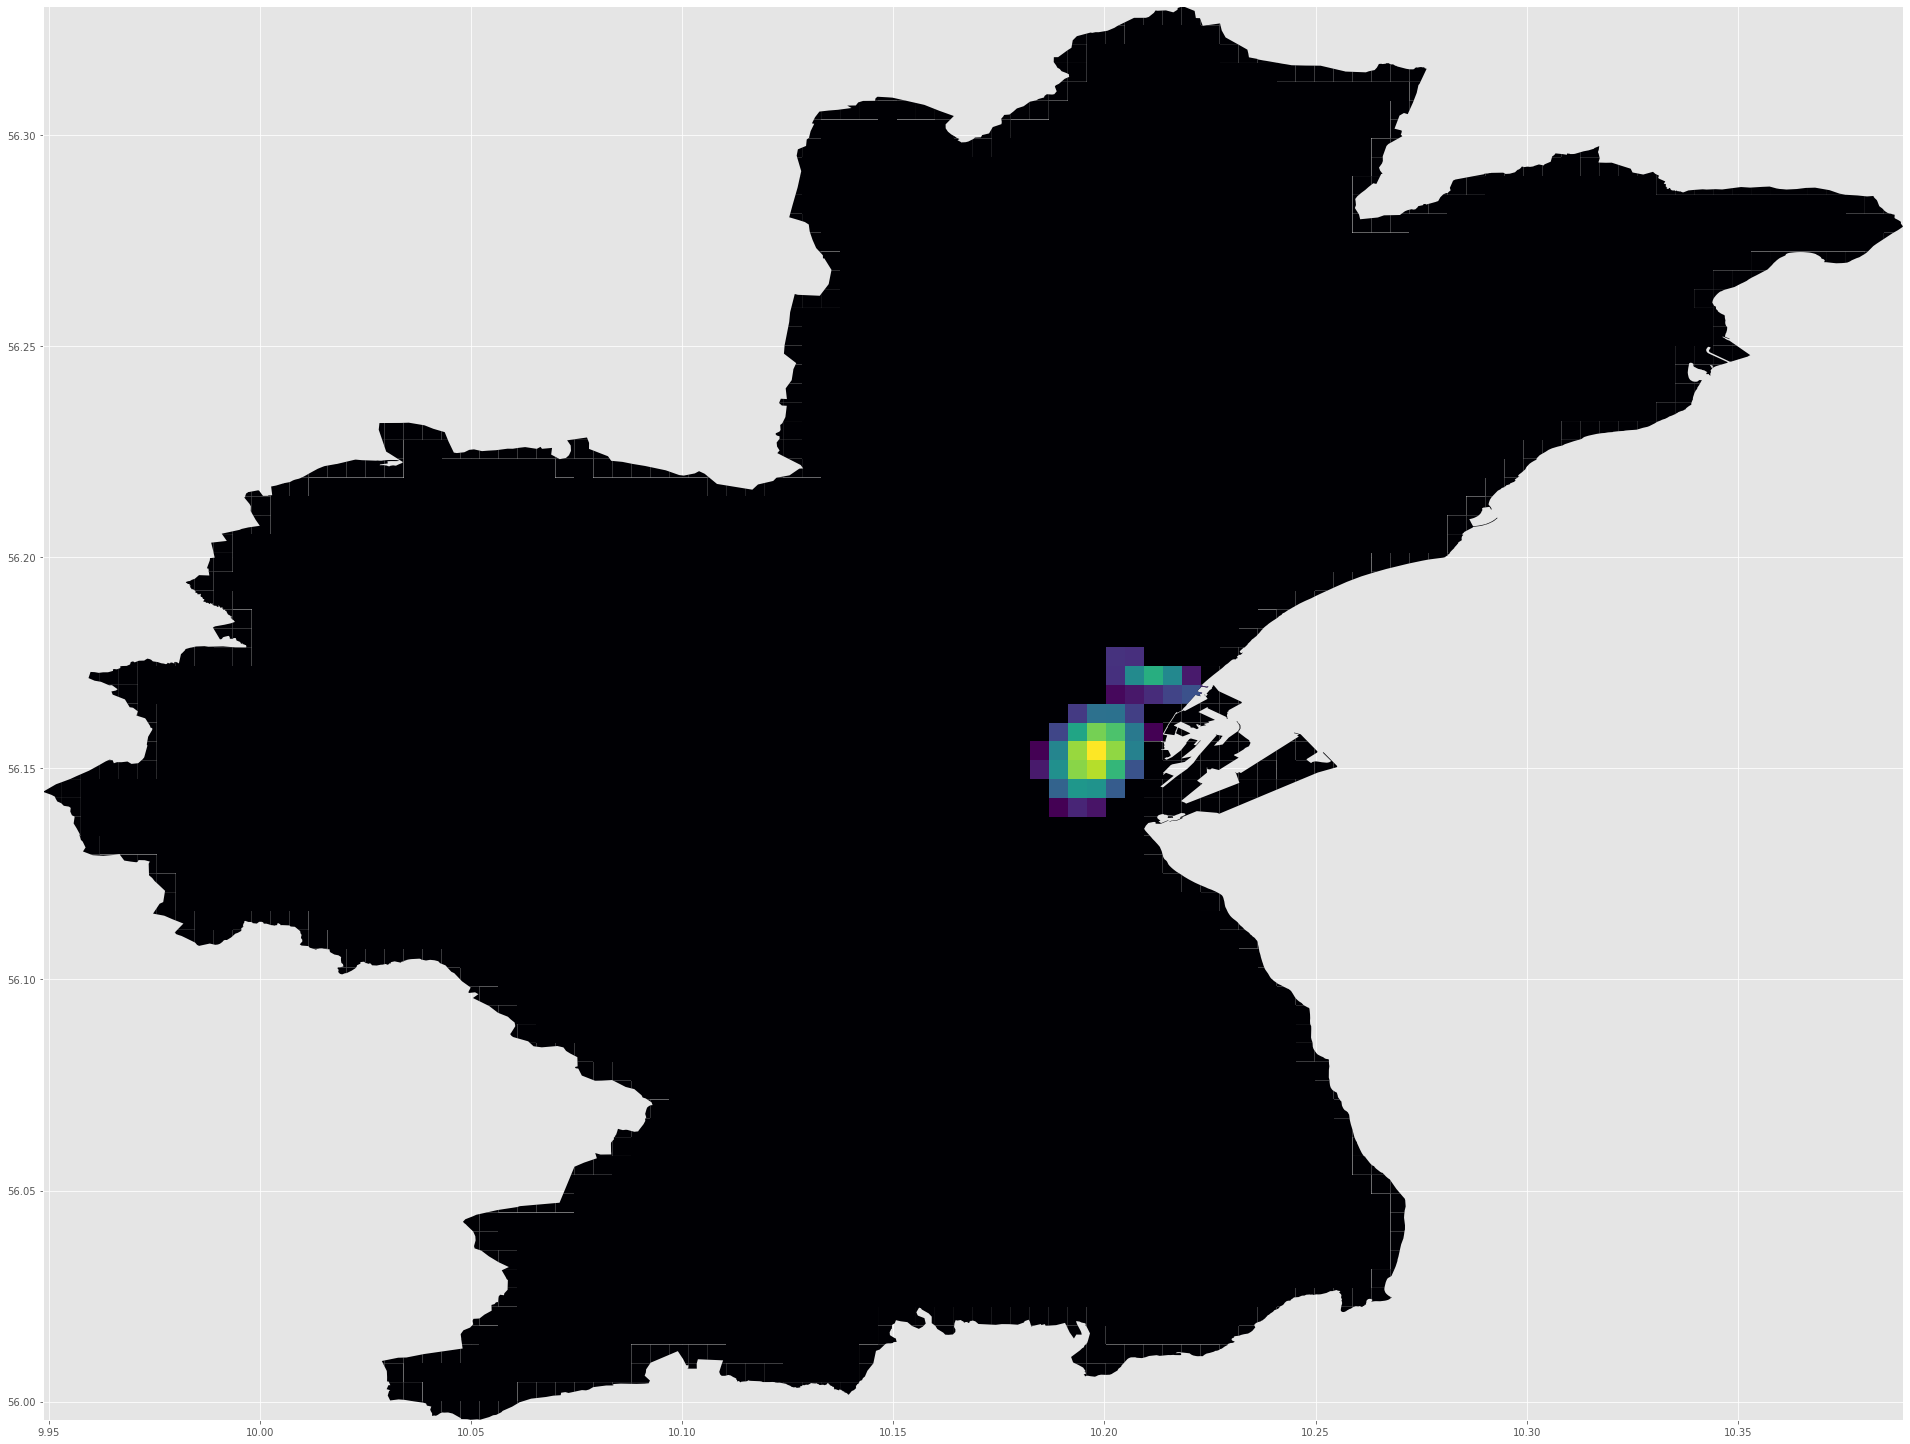

time: 1.34 s


In [25]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
#polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
poly_prices[poly_prices.index.isin(loubar_keys)].plot(ax=ax, column='zpred')
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [26]:
indlist = poly_prices.index.tolist()
mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(indlist), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)

print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True


if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No")


[[0.         0.00238815 0.00550268 ... 0.15978772 0.15896018 0.15825423]
 [0.         0.         0.00356409 ... 0.15935346 0.15846146 0.15769078]
 [0.         0.         0.         ... 0.15641745 0.15547053 0.15464667]
 ...
 [0.         0.         0.         ... 0.         0.00446316 0.00892631]
 [0.         0.         0.         ... 0.         0.         0.00446316]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Yes
time: 7min 42s


3724


3724 204
Number of cells with price above 1.0th percentile:  204
Loubar price:  22.911109493878726
Average price:  17.567890319822514
eta =  0.6427963276091704
3724 180
Number of cells with price above 2.0th percentile:  180
Loubar price:  24.689427148403997
Average price:  19.764135670625997
eta =  0.6708303378062945
3724 162
Number of cells with price above 3.0th percentile:  162
Loubar price:  28.89721609989773
Average price:  21.752251480379257
eta =  0.6818843210183376
3724 154
Number of cells with price above 4.0th percentile:  154
Loubar price:  29.779765348652735
Average price:  22.738898224453436
eta =  0.7014121395678797
3724 141
Number of cells with price above 5.0th percentile:  141
Loubar price:  31.946059838734993
Average price:  24.524524270690844
eta =  0.706750760235781
3724 136
Number of cells with price above 6.000000000000001th percentile:  136
Loubar price:  32.58201318118433
Average price:  25.27080628407624
eta =  0.7012822632257449
3724 130
Number of cells with 

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning:

Mean of empty slice.

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



eta =  nan
3724 6
Number of cells with price above 85.0th percentile:  6
Loubar price:  70.93407612502094
Average price:  69.8684879538773
eta =  nan
3724 6
Number of cells with price above 86.0th percentile:  6
Loubar price:  70.93407612502094
Average price:  69.8684879538773
eta =  nan
3724 6
Number of cells with price above 87.0th percentile:  6
Loubar price:  70.93407612502094
Average price:  69.8684879538773
eta =  nan
3724 6
Number of cells with price above 88.0th percentile:  6
Loubar price:  70.93407612502094
Average price:  69.8684879538773
eta =  nan
3724 5
Number of cells with price above 89.0th percentile:  5
Loubar price:  70.93407612502094
Average price:  70.50589720839712
eta =  nan
3724 4
Number of cells with price above 90.0th percentile:  4
Loubar price:  70.93407612502094
Average price:  71.10445792805692
eta =  nan
3724 3
Number of cells with price above 91.0th percentile:  3
Loubar price:  75.72964570605804
Average price:  71.9345046279487
eta =  nan
3724 2
Number 

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning:

invalid value encountered in true_divide



Loubar price:  75.72964570605804
Average price:  75.72964570605804
eta =  nan
3724 1
Number of cells with price above 95.0th percentile:  1
Loubar price:  75.72964570605804
Average price:  75.72964570605804
eta =  nan
3724 1
Number of cells with price above 96.00000000000001th percentile:  1
Loubar price:  75.72964570605804
Average price:  75.72964570605804
eta =  nan
3724 1
Number of cells with price above 97.0th percentile:  1
Loubar price:  75.72964570605804
Average price:  75.72964570605804
eta =  nan
3724 1
Number of cells with price above 98.0th percentile:  1
Loubar price:  75.72964570605804
Average price:  75.72964570605804
eta =  nan
3724 1
Number of cells with price above 99.0th percentile:  1
Loubar price:  75.72964570605804
Average price:  75.72964570605804
eta =  nan
3724 1
Number of cells with price above 100.0th percentile:  1
Loubar price:  75.72964570605804
Average price:  75.72964570605804
eta =  nan



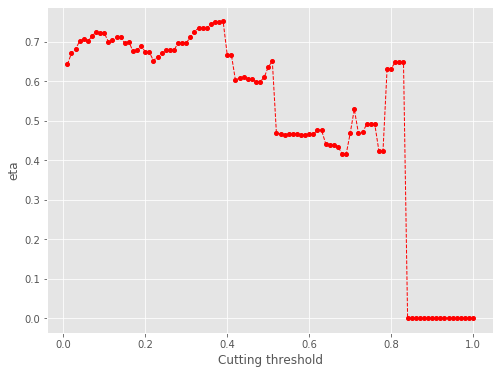

time: 2.28 s


In [27]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_cut = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    
    
        
    L1= L
    F1 = np.arange(1, len(L1)+1)/len(L1)

    L1 = (L1 - L1.min())/(L1.max()-L1.min())
    

    loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

    print('Loubar price: ', loubar_val)
    print('Average price: ', np.mean(vals_cut))
    
    
    loubar_keys = keys[vals_cut>loubar_val]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas_cut.append(eta)
    print('eta = ', eta)
etas_cut = np.array(etas_cut)
etas_cut = np.where(np.isnan(etas_cut), 0, etas_cut)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(perc_vals, etas_cut, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Cutting threshold")
plt.ylabel("eta")
plt.show()

In [28]:
pickle_in = open("etas_cut_dict.pickle","rb")
etas_cut_dict = pickle.load(pickle_in)
#etas_cut_dict = {}
etas_cut_dict['Aarhus'] = etas_cut


pickle_out = open("etas_cut_dict.pickle","wb")
pickle.dump(etas_cut_dict, pickle_out)
pickle_out.close()

etas_cut_dict

{'Boston': array([0.54176111, 0.69697859, 0.70601119, 0.71142664, 0.72735905,
        0.71723297, 0.69152614, 0.68969459, 0.69338651, 0.68627389,
        0.68571239, 0.68565242, 0.66080855, 0.68568495, 0.66662135,
        0.65169235, 0.66853925, 0.64080339, 0.6392735 , 0.64870117,
        0.66369008, 0.64936606, 0.65513408, 0.65817401, 0.54708479,
        0.54484174, 0.5177247 , 0.54225619, 0.54660686, 0.55128317,
        0.55836993, 0.56571414, 0.52792612, 0.52759205, 0.55096732,
        0.46941853, 0.48021089, 0.47484233, 0.46129546, 0.46439344,
        0.4699713 , 0.50255475, 0.51573036, 0.52765377, 0.52765377,
        0.53943229, 0.54404083, 0.54813213, 0.6100999 , 0.50092562,
        0.52536404, 0.56707558, 0.56150998, 0.61316219, 0.66467806,
        0.74541769, 0.74541769, 0.77652679, 0.74895419, 0.92876367,
        0.92876367, 0.90963119, 0.90963119, 1.05344906, 1.15130075,
        1.15130075, 1.22651104, 1.26738008, 0.62257449, 0.62257449,
        0.64231201, 0.64231201, 0.6240

time: 13 ms


100
100
100
100
100
100
100
100
100
100


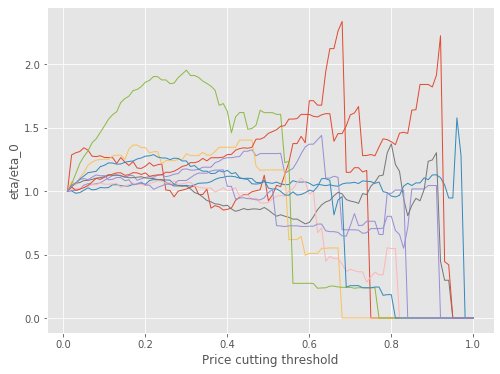

time: 201 ms


In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_dict:
    print(len(etas_cut_dict[key]))
    etas = etas_cut_dict[key]#[1:]
    vals = etas/etas[0]
    plt.plot(np.linspace(0.01, 1, 100), vals, linestyle='-', linewidth=1)
plt.xlabel("Price cutting threshold")
plt.ylabel("eta/eta_0")
plt.show()

3724 141
Number of cells with price above 5th percentile:  141


eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  0.992779510978206
eta =  0.9723749703573742
eta =  0.9641216660655754
eta =  0.9602463430027554
eta =  0.9344599100803861
eta =  0.9202137197987305
eta =  0.8916957142212941
eta =  0.8837591183745668
eta =  0.8837591183745668
eta =  0.8766383931646989
eta =  0.8726324581709434
eta =  0.8680186187523785
eta =  0.8676295450693985
eta =  0.8506427311424156
eta =  0.8507811817101809
eta =  0.852250376259136
eta =  0.8236755808518835
eta =  0.8118753207579613
eta =  0.791865450544586
eta =  0.78284010348793
eta =  0.7745503304346848
eta =  0.7683754533690152
eta =  0.7622290600244404
eta =  0.7622290600244404
eta =  0.7631059495470258
eta =  0.7460576648144519
eta =  0.7462483512462761
eta =  0.7426259021400775
eta =  0.7433388268563668
eta =  0.7433388268563668
eta =  0.7322761137715466
eta =  0.7322761137715466
eta =  0.7307435060135936
eta =  0.7280028797487792
eta =  0.7275954758900551
eta =  0.7134251188191372
eta

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan



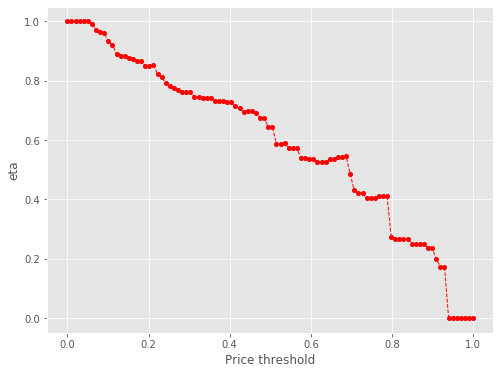

time: 676 ms


In [30]:
lval = np.linspace(0, max(vals_cut), 100)
etas = []

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)
vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

for i in tqdm_notebook(lval):
    loubar_keys = keys[vals_cut>=i]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas.append(eta)
    print('eta = ', eta)
etas = np.array(etas)
etas = np.where(np.isnan(etas), 0, etas)
lval = lval/lval.max()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lval, etas, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

etas_cut_threshold = etas

In [31]:
pickle_in = open("etas_cut_threshold_dict.pickle","rb")
etas_cut_threshold_dict = pickle.load(pickle_in)
#etas_cut_threshold_dict = {}
etas_cut_threshold_dict['Aarhus'] = etas_cut_threshold


pickle_out = open("etas_cut_threshold_dict.pickle","wb")
pickle.dump(etas_cut_threshold_dict, pickle_out)
pickle_out.close()

etas_cut_threshold_dict

{'NY': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99991145, 0.98955316, 0.97868522, 0.96344498, 0.95205618,
        0.94615067, 0.93194961, 0.92540239, 0.92150344, 0.91822455,
        0.91569734, 0.91218202, 0.90337978, 0.898264  , 0.89376519,
        0.89441924, 0.88573077, 0.88617046, 0.87902683, 0.87195329,
        0.87101443, 0.87158631, 0.86935351, 0.86321974, 0.86053312,
        0.86079304, 0.86069179, 0.86140605, 0.85888874, 0.8617884 ,
        0.85709178, 0.8579834 , 0.85179248, 0.84947743, 0.84847717,
        0.84228408, 0.82983947, 0.82767187, 0.82334824, 0.81678545,
        0.81788964, 0.81304395, 0.807866  , 0.79902867, 0.79698224,
        0.78820712, 0.76853775, 0.76312442, 0.75071909, 0.7481045 ,
        0.73389742, 0.71700231, 0.70245218, 0.68328343, 0.67990807,
        0.66811743, 0.61552082, 0.58620924, 0.57826542, 0.57372339,
        0.55441141, 0.5326264 , 0.53706259, 0.53126932, 0.52772792,
        0.5331439 , 0.51700595, 0.49034259

time: 14 ms


In [75]:
import math
# Euclidean distance.
def euc_dist(pt1,pt2):
    return math.sqrt((pt2[0]-pt1[0])*(pt2[0]-pt1[0])+(pt2[1]-pt1[1])*(pt2[1]-pt1[1]))

def _c(ca,i,j,P,Q):
    if ca[i,j] > -1:
        return ca[i,j]
    elif i == 0 and j == 0:
        ca[i,j] = euc_dist(P[0],Q[0])
    elif i > 0 and j == 0:
        ca[i,j] = max(_c(ca,i-1,0,P,Q),euc_dist(P[i],Q[0]))
    elif i == 0 and j > 0:
        ca[i,j] = max(_c(ca,0,j-1,P,Q),euc_dist(P[0],Q[j]))
    elif i > 0 and j > 0:
        ca[i,j] = max(min(_c(ca,i-1,j,P,Q),_c(ca,i-1,j-1,P,Q),_c(ca,i,j-1,P,Q)),euc_dist(P[i],Q[j]))
    else:
        ca[i,j] = float("inf")
    return ca[i,j]

""" Computes the discrete frechet distance between two polygonal lines
Algorithm: http://www.kr.tuwien.ac.at/staff/eiter/et-archive/cdtr9464.pdf
P and Q are arrays of 2-element arrays (points)
"""
def frechetDist(P,Q):
    ca = np.ones((len(P),len(Q)))
    ca = np.multiply(ca,-1)
    return _c(ca,len(P)-1,len(Q)-1,P,Q)

time: 4.01 ms


In [76]:
etas_dict['Paris']

a = []

for i in range(0, 50):
    a.append(())

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99892229, 0.98804671, 0.97772318, 0.9741773 , 0.96402975,
       0.95612064, 0.94309786, 0.92621716, 0.90956978, 0.89431961,
       0.88163262, 0.86599252, 0.85303151, 0.83093605, 0.81937564,
       0.80452759, 0.79397664, 0.77891966, 0.76472821, 0.75139472,
       0.73760156, 0.72993045, 0.71599406, 0.6973232 , 0.68569382,
       0.66444837, 0.64913859, 0.63622062, 0.61622269, 0.60796744,
       0.59875293, 0.57553903, 0.55531623, 0.5196119 , 0.51294782,
       0.48889127, 0.47120143, 0.44129376, 0.4340038 , 0.42753283,
       0.28637398, 0.12703126, 0.11051098, 0.08187494, 0.        ])

time: 3 ms


In [77]:
frechetDist(etas_dict['Paris'], etas_dict['Aarhus'])

IndexError: invalid index to scalar variable.

time: 773 ms


20.368045439206643 0.7242948447964968 5.987289955969654 7.518058509307406 39.503257518667866


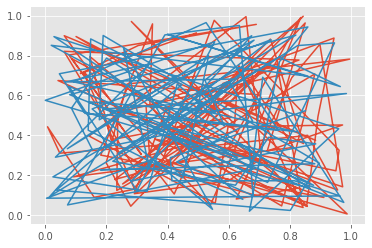

time: 359 ms


In [78]:
import numpy as np
import similaritymeasures
import matplotlib.pyplot as plt

# Generate random experimental data
x = np.random.random(100)
y = np.random.random(100)
exp_data = np.zeros((100, 2))
exp_data[:, 0] = x
exp_data[:, 1] = y

# Generate random numerical data
x = np.random.random(100)
y = np.random.random(100)
num_data = np.zeros((100, 2))
num_data[:, 0] = x
num_data[:, 1] = y

# quantify the difference between the two curves using PCM
pcm = similaritymeasures.pcm(exp_data, num_data)

# quantify the difference between the two curves using
# Discrete Frechet distance
df = similaritymeasures.frechet_dist(exp_data, num_data)

# quantify the difference between the two curves using
# area between two curves
area = similaritymeasures.area_between_two_curves(exp_data, num_data)

# quantify the difference between the two curves using
# Curve Length based similarity measure
cl = similaritymeasures.curve_length_measure(exp_data, num_data)

# quantify the difference between the two curves using
# Dynamic Time Warping distance
dtw, d = similaritymeasures.dtw(exp_data, num_data)

# print the results
print(pcm, df, area, cl, dtw)

# plot the data
plt.figure()
plt.plot(exp_data[:, 0], exp_data[:, 1])
plt.plot(num_data[:, 0], num_data[:, 1])
plt.show()

In [80]:
paris_data = np.zeros((50, 2))
paris_data[:,0] = np.arange(50)
paris_data[:,1] = etas_dict['Paris']
paris_data

array([[ 0.        ,  1.        ],
       [ 1.        ,  1.        ],
       [ 2.        ,  1.        ],
       [ 3.        ,  1.        ],
       [ 4.        ,  1.        ],
       [ 5.        ,  0.99892229],
       [ 6.        ,  0.98804671],
       [ 7.        ,  0.97772318],
       [ 8.        ,  0.9741773 ],
       [ 9.        ,  0.96402975],
       [10.        ,  0.95612064],
       [11.        ,  0.94309786],
       [12.        ,  0.92621716],
       [13.        ,  0.90956978],
       [14.        ,  0.89431961],
       [15.        ,  0.88163262],
       [16.        ,  0.86599252],
       [17.        ,  0.85303151],
       [18.        ,  0.83093605],
       [19.        ,  0.81937564],
       [20.        ,  0.80452759],
       [21.        ,  0.79397664],
       [22.        ,  0.77891966],
       [23.        ,  0.76472821],
       [24.        ,  0.75139472],
       [25.        ,  0.73760156],
       [26.        ,  0.72993045],
       [27.        ,  0.71599406],
       [28.        ,

time: 4 ms


In [81]:
Aarhus_data = np.zeros((50, 2))
Aarhus_data[:,0] = np.arange(50)
Aarhus_data[:,1] = etas_dict['Aarhus']
Aarhus_data

array([[ 0.        ,  1.        ],
       [ 1.        ,  1.        ],
       [ 2.        ,  1.        ],
       [ 3.        ,  0.99277951],
       [ 4.        ,  0.96412167],
       [ 5.        ,  0.93445991],
       [ 6.        ,  0.89169571],
       [ 7.        ,  0.88185377],
       [ 8.        ,  0.87263246],
       [ 9.        ,  0.86762955],
       [10.        ,  0.8480859 ],
       [11.        ,  0.81836082],
       [12.        ,  0.79186545],
       [13.        ,  0.77455033],
       [14.        ,  0.76222906],
       [15.        ,  0.75282328],
       [16.        ,  0.7426259 ],
       [17.        ,  0.74333883],
       [18.        ,  0.73227611],
       [19.        ,  0.73074351],
       [20.        ,  0.72759548],
       [21.        ,  0.70675076],
       [22.        ,  0.69936343],
       [23.        ,  0.68767598],
       [24.        ,  0.66296478],
       [25.        ,  0.62942971],
       [26.        ,  0.58852092],
       [27.        ,  0.57246582],
       [28.        ,

time: 4 ms


1.6672166465928924 0.2383838240150425 0.04454771287616954 1.0138545361406648 5.5160271131033785


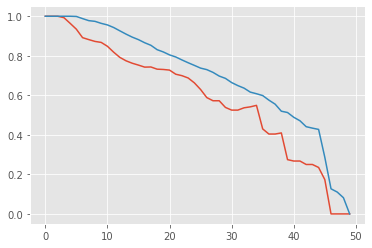

time: 208 ms


In [82]:
# quantify the difference between the two curves using PCM
pcm = similaritymeasures.pcm(Aarhus_data, paris_data)

# quantify the difference between the two curves using
# Discrete Frechet distance
df = similaritymeasures.frechet_dist(Aarhus_data, paris_data)

# quantify the difference between the two curves using
# area between two curves
area = similaritymeasures.area_between_two_curves(Aarhus_data, paris_data)

# quantify the difference between the two curves using
# Curve Length based similarity measure
cl = similaritymeasures.curve_length_measure(Aarhus_data, paris_data)

# quantify the difference between the two curves using
# Dynamic Time Warping distance
dtw, d = similaritymeasures.dtw(Aarhus_data, paris_data)

# print the results
print(pcm, df, area, cl, dtw)

# plot the data
plt.figure()
plt.plot(Aarhus_data[:, 0], Aarhus_data[:, 1])
plt.plot(paris_data[:, 0], paris_data[:, 1])
plt.show()

---------- Paris ----------
PCM distance:  0.0 

Discrete Frechet distance:  0.0 

Are between the curves:  3.375077994860476e-14 

Curve Length based similarity measure:  0.0 

Dynamic Time Warping distance:  0.0 



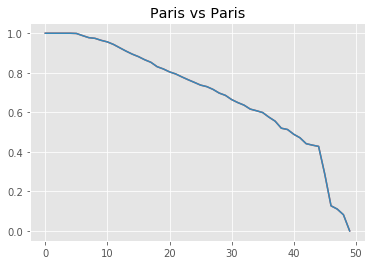

---------- Amsterdam ----------
PCM distance:  1.7370585815149753 

Discrete Frechet distance:  0.19222384918290925 

Are between the curves:  0.03523878790032331 

Curve Length based similarity measure:  1.1515308435780118 

Dynamic Time Warping distance:  5.650988097327833 



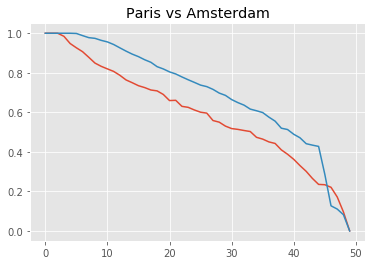

---------- Stockholm ----------
PCM distance:  1.1634008505678834 

Discrete Frechet distance:  0.34502509458330477 

Are between the curves:  0.031240569817935437 

Curve Length based similarity measure:  0.7038110972527443 

Dynamic Time Warping distance:  3.869877401824722 



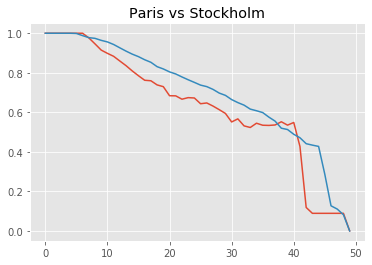

---------- Arezzo ----------
PCM distance:  3.1718912973009536 

Discrete Frechet distance:  0.4275328257554531 

Are between the curves:  0.0495979412708476 

Curve Length based similarity measure:  1.9087345779653966 

Dynamic Time Warping distance:  9.313988640355264 



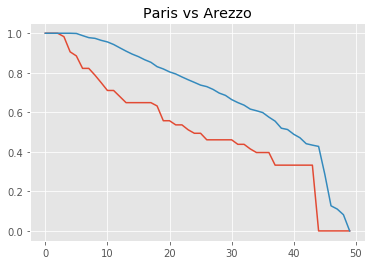

---------- Berlin ----------
PCM distance:  1.6382461680172642 

Discrete Frechet distance:  0.5572881461769552 

Are between the curves:  0.2689849646208371 

Curve Length based similarity measure:  1.116245411115929 

Dynamic Time Warping distance:  4.821097797397905 



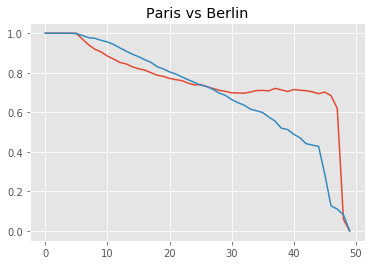

---------- Bordeaux ----------
PCM distance:  2.6423270342773506 

Discrete Frechet distance:  0.2260545648855054 

Are between the curves:  0.04911581249285568 

Curve Length based similarity measure:  1.708158562193396 

Dynamic Time Warping distance:  8.236970924690139 



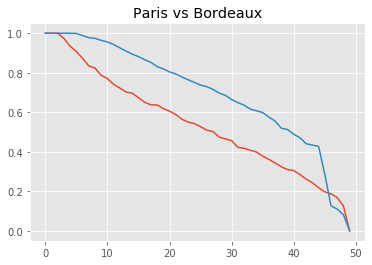

---------- Denver ----------
PCM distance:  3.221786868185207 

Discrete Frechet distance:  0.3299618278025608 

Are between the curves:  0.05855109822043225 

Curve Length based similarity measure:  1.8824070408329963 

Dynamic Time Warping distance:  9.328043513328637 



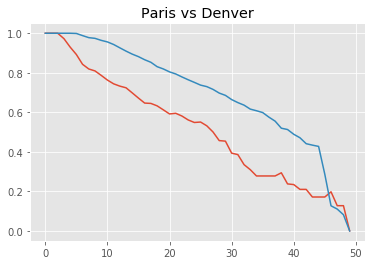

---------- Edinburgh ----------
PCM distance:  1.6348967697554255 

Discrete Frechet distance:  0.16656806465055807 

Are between the curves:  0.21315268149153166 

Curve Length based similarity measure:  1.2377192702174566 

Dynamic Time Warping distance:  4.3983276623164445 



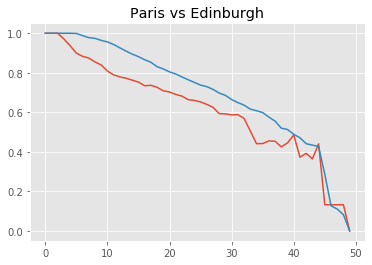

---------- Lyon ----------
PCM distance:  2.372958588160602 

Discrete Frechet distance:  0.21512954481535873 

Are between the curves:  0.03731840660464503 

Curve Length based similarity measure:  1.4955623462829268 

Dynamic Time Warping distance:  7.261953147852341 



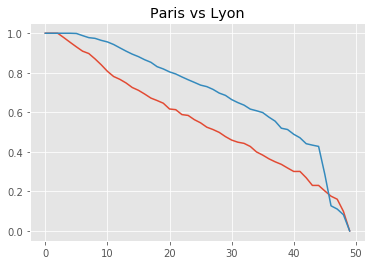

---------- Madrid ----------
PCM distance:  2.2832893716939715 

Discrete Frechet distance:  0.26431758841520886 

Are between the curves:  0.05520552427708836 

Curve Length based similarity measure:  1.4850280448155038 

Dynamic Time Warping distance:  7.472758974206044 



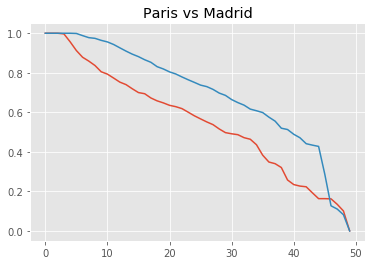

---------- Buenos_Aires ----------
PCM distance:  7.2092759792600845 

Discrete Frechet distance:  0.6801682205786693 

Are between the curves:  0.39760748157624115 

Curve Length based similarity measure:  3.5376208310181716 

Dynamic Time Warping distance:  16.626075458394638 



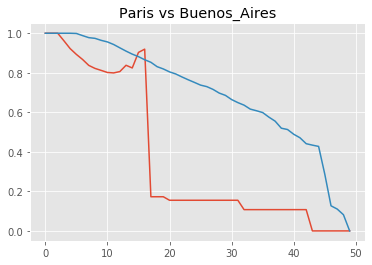

---------- Palermo ----------
PCM distance:  2.3942904103690745 

Discrete Frechet distance:  0.6813616703343508 

Are between the curves:  0.3782739507281463 

Curve Length based similarity measure:  1.8589372309031766 

Dynamic Time Warping distance:  7.086967781410408 



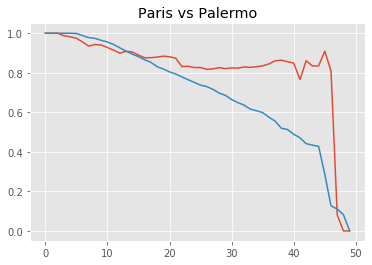

---------- Los_Angeles ----------
PCM distance:  1.7450206233215637 

Discrete Frechet distance:  0.39634976325419063 

Are between the curves:  0.3561319118739601 

Curve Length based similarity measure:  1.6374489790270688 

Dynamic Time Warping distance:  4.317308071439563 



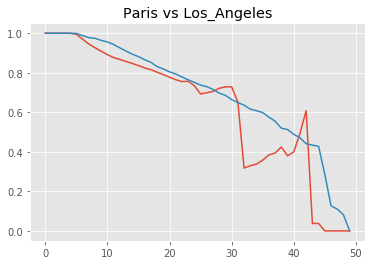

---------- Beijing ----------
PCM distance:  6.373944660933636 

Discrete Frechet distance:  0.6491385908500316 

Are between the curves:  0.07241288327807571 

Curve Length based similarity measure:  3.6206151938934794 

Dynamic Time Warping distance:  17.451562818356308 



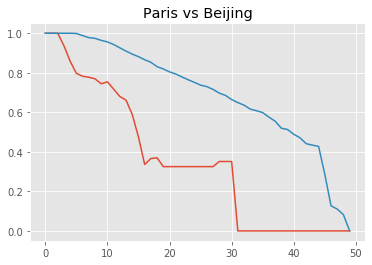

---------- Florence ----------
PCM distance:  4.484943346847069 

Discrete Frechet distance:  0.45718373624756076 

Are between the curves:  0.061407652106412636 

Curve Length based similarity measure:  2.638415392491581 

Dynamic Time Warping distance:  13.074558604017648 



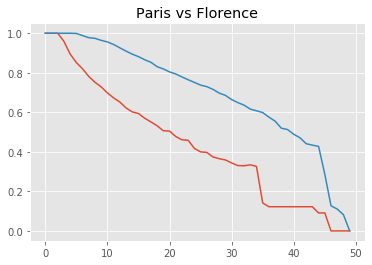

---------- Moscow ----------
PCM distance:  3.7132673004622947 

Discrete Frechet distance:  0.49089112473192964 

Are between the curves:  0.04102333278425074 

Curve Length based similarity measure:  2.093626986508136 

Dynamic Time Warping distance:  11.388862972848626 



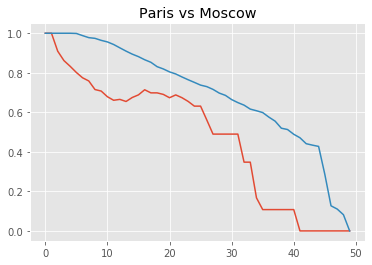

---------- Porto ----------
PCM distance:  2.200172293125195 

Discrete Frechet distance:  0.8416036547779737 

Are between the curves:  0.42604767123253784 

Curve Length based similarity measure:  2.3379129614220044 

Dynamic Time Warping distance:  5.333115886773875 



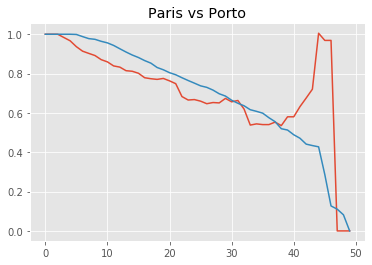

---------- Prague ----------
PCM distance:  3.369364228353512 

Discrete Frechet distance:  0.29555250508017444 

Are between the curves:  0.0703958820068209 

Curve Length based similarity measure:  2.2203036126468705 

Dynamic Time Warping distance:  10.595565007773509 



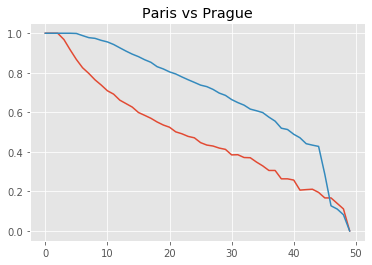

---------- Reykjavik ----------
PCM distance:  0.7683044352692363 

Discrete Frechet distance:  0.25868414810530754 

Are between the curves:  0.10356484461838211 

Curve Length based similarity measure:  0.6075194840913806 

Dynamic Time Warping distance:  2.5448483666898642 



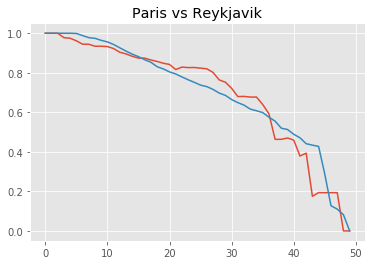

---------- Riga ----------
PCM distance:  2.4528814468129396 

Discrete Frechet distance:  0.28720845334359013 

Are between the curves:  0.14988192478328366 

Curve Length based similarity measure:  1.5077739145002764 

Dynamic Time Warping distance:  6.81132482653703 



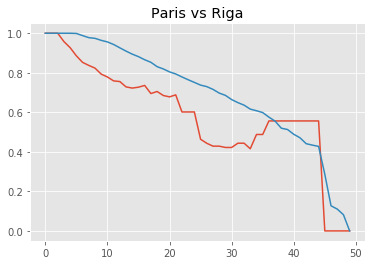

---------- Rome ----------
PCM distance:  2.914980663447558 

Discrete Frechet distance:  0.2628748448785143 

Are between the curves:  0.07348159150711542 

Curve Length based similarity measure:  1.8693690159139316 

Dynamic Time Warping distance:  8.957499760759022 



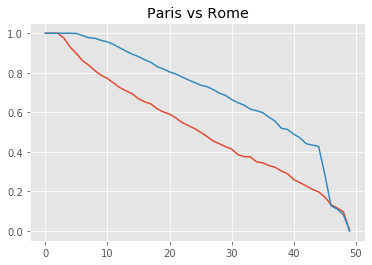

---------- Seoul ----------
PCM distance:  2.3415312960396832 

Discrete Frechet distance:  0.7728337178258036 

Are between the curves:  0.4006666364684741 

Curve Length based similarity measure:  2.407461778528519 

Dynamic Time Warping distance:  8.439389613073356 



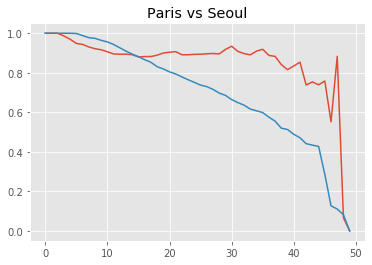

---------- Siena ----------
PCM distance:  3.05716488779223 

Discrete Frechet distance:  0.27955302780681884 

Are between the curves:  0.1360828126372431 

Curve Length based similarity measure:  1.883632324907251 

Dynamic Time Warping distance:  8.987454616975498 



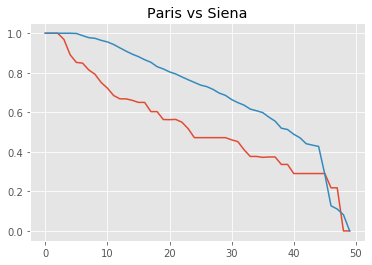

---------- Sydney ----------
PCM distance:  2.523144697616192 

Discrete Frechet distance:  0.8670386274262996 

Are between the curves:  0.44510751300420925 

Curve Length based similarity measure:  2.36580219156124 

Dynamic Time Warping distance:  7.162329589516231 



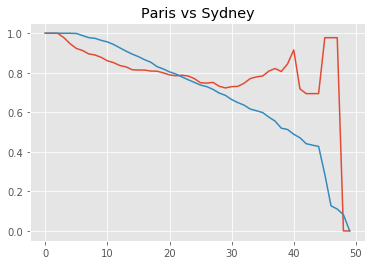

---------- Tallin ----------
PCM distance:  3.272533173750114 

Discrete Frechet distance:  0.260796546501434 

Are between the curves:  0.10662203806069304 

Curve Length based similarity measure:  1.9414329248025795 

Dynamic Time Warping distance:  9.441399571807011 



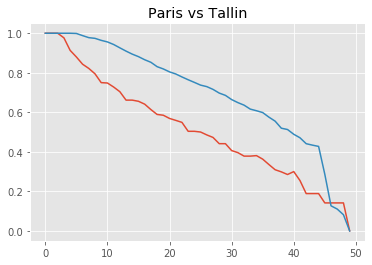

---------- Treviso ----------
PCM distance:  3.095713496192001 

Discrete Frechet distance:  0.4412937624807163 

Are between the curves:  0.05904034777673872 

Curve Length based similarity measure:  1.831678447425786 

Dynamic Time Warping distance:  9.442068466437053 



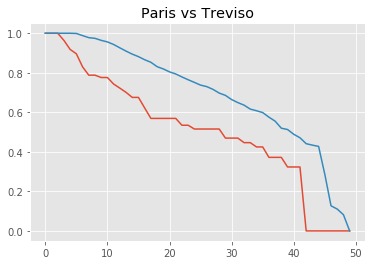

---------- Valencia ----------
PCM distance:  1.6922119618460927 

Discrete Frechet distance:  0.25867498262470573 

Are between the curves:  0.08625946655857408 

Curve Length based similarity measure:  1.0303507239404095 

Dynamic Time Warping distance:  5.470444164773849 



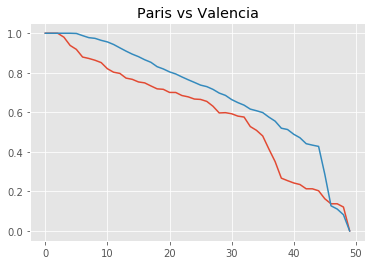

---------- Venezia ----------
PCM distance:  0.8269648097107076 

Discrete Frechet distance:  0.20122759225441939 

Are between the curves:  0.08527595815771716 

Curve Length based similarity measure:  0.49352498423550717 

Dynamic Time Warping distance:  2.5560970448689906 



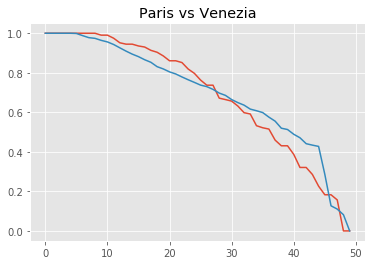

---------- Verona ----------
PCM distance:  3.137424180180336 

Discrete Frechet distance:  0.2603590309144178 

Are between the curves:  0.04777957235547703 

Curve Length based similarity measure:  1.881328122780501 

Dynamic Time Warping distance:  9.080874890711101 



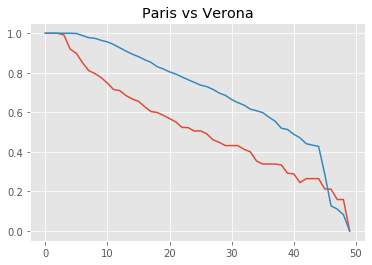

---------- Vicenza ----------
PCM distance:  3.465353880933632 

Discrete Frechet distance:  0.33418455697281424 

Are between the curves:  0.16283221967636385 

Curve Length based similarity measure:  2.3134604686836306 

Dynamic Time Warping distance:  10.91772450245779 



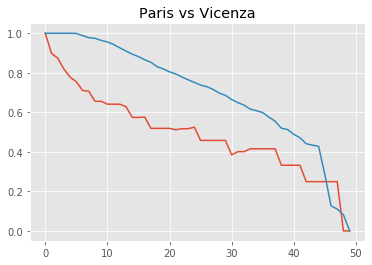

---------- Vienna ----------
PCM distance:  1.8945997653061637 

Discrete Frechet distance:  0.7278813451634529 

Are between the curves:  0.4476288258928627 

Curve Length based similarity measure:  2.6320170709639354 

Dynamic Time Warping distance:  5.799105441807985 



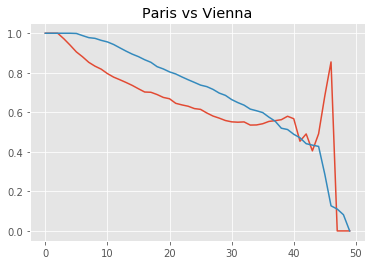

---------- Wellington ----------
PCM distance:  2.1551871757672383 

Discrete Frechet distance:  0.2694613414505114 

Are between the curves:  0.1491428499934433 

Curve Length based similarity measure:  1.3368679724159598 

Dynamic Time Warping distance:  6.307306494650563 



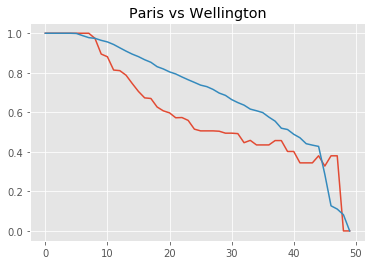

---------- Zurich ----------
PCM distance:  2.903588294236418 

Discrete Frechet distance:  0.39975264193236476 

Are between the curves:  0.2328551558789036 

Curve Length based similarity measure:  1.8086077953822857 

Dynamic Time Warping distance:  9.073108304907151 



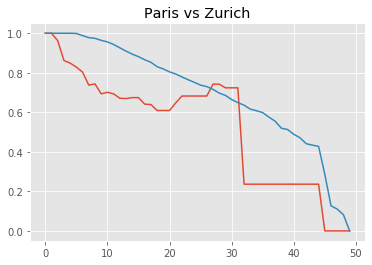

---------- Aarhus ----------
PCM distance:  1.6672166465928924 

Discrete Frechet distance:  0.2383838240150425 

Are between the curves:  0.04454771287616954 

Curve Length based similarity measure:  1.0138545361406648 

Dynamic Time Warping distance:  5.5160271131033785 



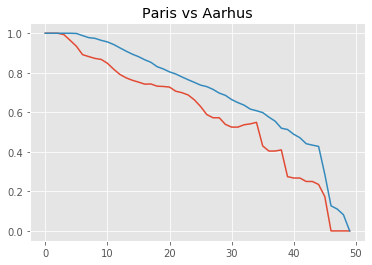

time: 8.36 s


In [85]:
for key in etas_dict:
    curve = np.zeros((50, 2))
    curve[:,0] = np.arange(50)
    curve[:,1] = etas_dict[key]
    
        # quantify the difference between the two curves using PCM
    pcm = similaritymeasures.pcm(curve, paris_data)

    # quantify the difference between the two curves using
    # Discrete Frechet distance
    df = similaritymeasures.frechet_dist(curve, paris_data)

    # quantify the difference between the two curves using
    # area between two curves
    area = similaritymeasures.area_between_two_curves(curve, paris_data)

    # quantify the difference between the two curves using
    # Curve Length based similarity measure
    cl = similaritymeasures.curve_length_measure(curve, paris_data)

    # quantify the difference between the two curves using
    # Dynamic Time Warping distance
    dtw, d = similaritymeasures.dtw(curve, paris_data)

    # print the results
    print('----------', key, '----------')
    print('PCM distance: ', pcm, '\n')
    print('Discrete Frechet distance: ', df, '\n')
    print('Are between the curves: ', area, '\n')
    print('Curve Length based similarity measure: ', cl, '\n')
    print('Dynamic Time Warping distance: ', dtw, '\n')

    # plot the data
    plt.figure()
    plt.plot(curve[:, 0], curve[:, 1])
    plt.plot(paris_data[:, 0], paris_data[:, 1])
    plt.title('Paris vs {}'.format(key))
    plt.show()
    

NameError: name 'etas_dict' is not defined

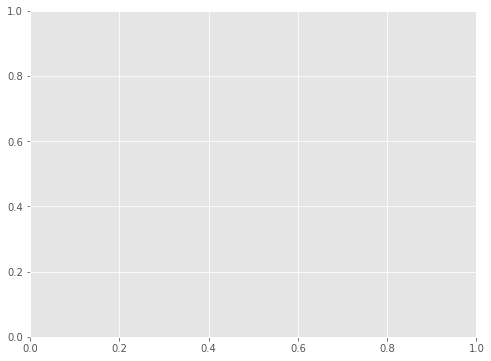

time: 415 ms


In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_dict:
    plt.plot(np.arange(50), etas_dict[key], linestyle='-', linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

3724 204
Number of cells with price above 1.0th percentile:  204


eta =  1.0
eta =  0.932493783623231
eta =  0.8979007507387802
eta =  0.8697078915747812
eta =  0.8423421780301014
eta =  0.836260055581041
eta =  0.8190724503927859
eta =  0.8121203440796868
eta =  0.8088559960103807
eta =  0.7871349959389251
eta =  0.7746051091875888
eta =  0.758217265625151
eta =  0.7444275806255948
eta =  0.7444275806255948
eta =  0.7384294934431608
eta =  0.7384294934431608
eta =  0.7311686938905587
eta =  0.7308409607170231
eta =  0.7235829406760742
eta =  0.7166488736287773
eta =  0.717886438165094
eta =  0.6938166827649844
eta =  0.6853851506608706
eta =  0.6768909007838645
eta =  0.6670216683185141
eta =  0.652436412332287
eta =  0.652436412332287
eta =  0.642057686578824
eta =  0.642057686578824
eta =  0.642057686578824
eta =  0.6358285766298226
eta =  0.6284358383158567
eta =  0.6255451198702418
eta =  0.6261456464285324
eta =  0.6261456464285324
eta =  0.6171168975754224
eta =  0.6168270565937428
eta =  0.6168270565937428
eta =  0.6155360764368429
eta =  0.6

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan


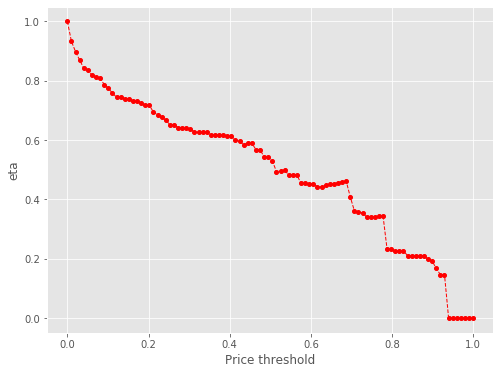

3724 180
Number of cells with price above 2.0th percentile:  180


eta =  1.0
eta =  0.9629026664928119
eta =  0.9320075093522883
eta =  0.9033220304774119
eta =  0.8967996036732051
eta =  0.8783677326086364
eta =  0.8709123410176208
eta =  0.8674116763197584
eta =  0.844118223373554
eta =  0.8325834113867794
eta =  0.8192055786761417
eta =  0.7983190812630411
eta =  0.7983190812630411
eta =  0.7965979375668091
eta =  0.7918867733079915
eta =  0.7841003411835971
eta =  0.7866300285797956
eta =  0.7759654309593059
eta =  0.7685293845544126
eta =  0.769856540357541
eta =  0.7440442981497851
eta =  0.7391356440128948
eta =  0.7258932045142282
eta =  0.715309506650846
eta =  0.6996683771952098
eta =  0.6996683771952098
eta =  0.6885383021901665
eta =  0.6885383021901665
eta =  0.6885383021901665
eta =  0.6800418560070369
eta =  0.6739303246334271
eta =  0.6708303378062945
eta =  0.6708303378062945
eta =  0.6714743384085905
eta =  0.6654890467399639
eta =  0.6614811459622217
eta =  0.6614811459622217
eta =  0.6600967076103822
eta =  0.6576210395280704
eta 

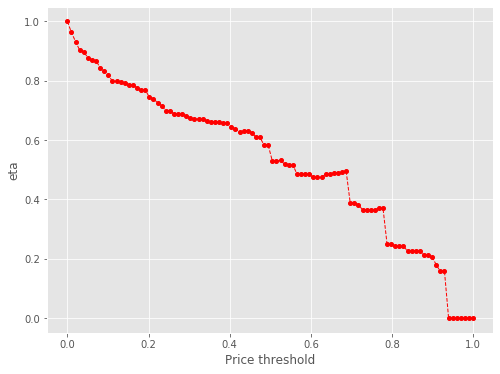

3724 162
Number of cells with price above 3.0th percentile:  162


eta =  1.0
eta =  0.9625859948208458
eta =  0.9381239266556287
eta =  0.9277026169997249
eta =  0.9122082253733105
eta =  0.9044656031432043
eta =  0.9008300698544526
eta =  0.8766392001468775
eta =  0.8632745081799674
eta =  0.8365210848072757
eta =  0.8290755743472652
eta =  0.8290755743472652
eta =  0.8223954516527482
eta =  0.8223954516527482
eta =  0.8143090350341765
eta =  0.8139440357029409
eta =  0.8058607146510572
eta =  0.7981381829106708
eta =  0.7995164694699577
eta =  0.7727097701991248
eta =  0.7676120024727469
eta =  0.753859377249577
eta =  0.7428679258478156
eta =  0.7266241973798012
eta =  0.7266241973798012
eta =  0.715065318801157
eta =  0.715065318801157
eta =  0.715065318801157
eta =  0.7062415337200787
eta =  0.6998945460272625
eta =  0.6966751273518281
eta =  0.6966751273518281
eta =  0.6973439390860833
eta =  0.6973439390860833
eta =  0.6869657432474872
eta =  0.6869657432474872
eta =  0.6855279672395734
eta =  0.6829569201665302
eta =  0.6825747248588493
eta =

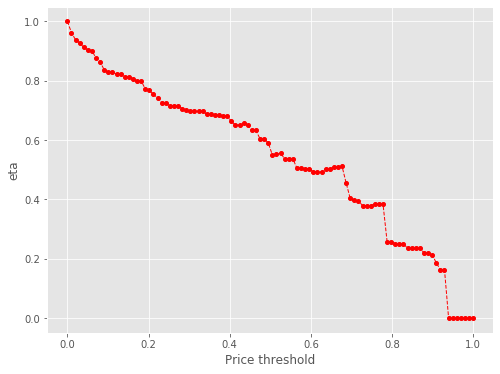

3724 154
Number of cells with price above 4.0th percentile:  154


eta =  1.0
eta =  0.9634744024775349
eta =  0.9565176461316662
eta =  0.9368583935491818
eta =  0.9289065461281757
eta =  0.9251727715558178
eta =  0.900328203503911
eta =  0.8871303922007105
eta =  0.8737566214388871
eta =  0.8514792885100088
eta =  0.8514792885100088
eta =  0.8496435335540173
eta =  0.8446186520432246
eta =  0.8407590362187521
eta =  0.8372210838033658
eta =  0.8353541234991472
eta =  0.8195724971092972
eta =  0.817109051726415
eta =  0.8161029811237012
eta =  0.7884697053459611
eta =  0.7742305599612379
eta =  0.7629420918060489
eta =  0.7542464009434848
eta =  0.746259416804335
eta =  0.740310080813117
eta =  0.7343881881580607
eta =  0.7343881881580607
eta =  0.7343881881580607
eta =  0.7287815412604267
eta =  0.7189911843168514
eta =  0.7155010473287514
eta =  0.7161879320437897
eta =  0.7161879320437897
eta =  0.7058608124559838
eta =  0.7055292911646122
eta =  0.7055292911646122
eta =  0.704052662820786
eta =  0.7014121395678797
eta =  0.7010196163785285
eta = 

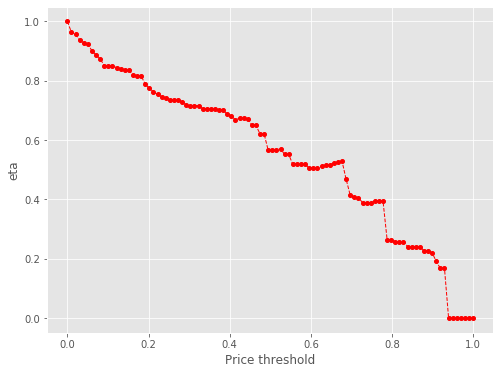

3724 141
Number of cells with price above 5.0th percentile:  141


eta =  1.0
eta =  0.9893948089761059
eta =  0.9723749703573742
eta =  0.9641216660655754
eta =  0.9602463430027554
eta =  0.9344599100803861
eta =  0.9202137197987305
eta =  0.9001297636529556
eta =  0.8837591183745668
eta =  0.8837591183745668
eta =  0.8818537694091237
eta =  0.8766383931646989
eta =  0.8680186187523785
eta =  0.8708190457439151
eta =  0.867022643622984
eta =  0.8495245800553777
eta =  0.8504587804025089
eta =  0.8470416847869812
eta =  0.8183608234099874
eta =  0.8035818678424003
eta =  0.791865450544586
eta =  0.78284010348793
eta =  0.7745503304346848
eta =  0.7683754533690152
eta =  0.7622290600244404
eta =  0.7622290600244404
eta =  0.7622290600244404
eta =  0.7564098634965235
eta =  0.7462483512462761
eta =  0.7426259021400775
eta =  0.7433388268563668
eta =  0.7433388268563668
eta =  0.7326202031324254
eta =  0.7322761137715466
eta =  0.7322761137715466
eta =  0.7307435060135936
eta =  0.7280028797487792
eta =  0.7275954758900551
eta =  0.7134251188191372
eta =

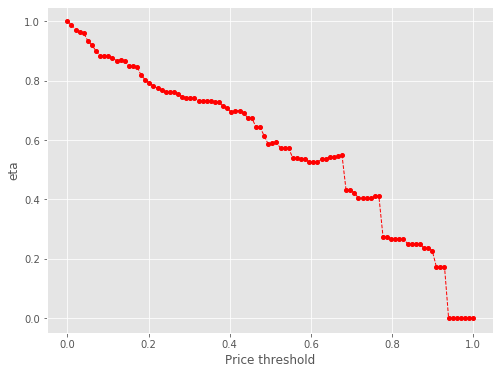

3724 136
Number of cells with price above 6.000000000000001th percentile:  136


eta =  1.0
eta =  0.9794470570804521
eta =  0.9711337264762914
eta =  0.9672302181746327
eta =  0.941256240431114
eta =  0.9283940447526936
eta =  0.9134767403116084
eta =  0.8901867016814043
eta =  0.8901867016814043
eta =  0.8882674951059527
eta =  0.8830141874109882
eta =  0.8789791172373418
eta =  0.8752803329758131
eta =  0.8733285024876156
eta =  0.8568294588435451
eta =  0.8542540276501481
eta =  0.8584487963690913
eta =  0.8243127646778686
eta =  0.8177800929412856
eta =  0.8032569931043672
eta =  0.7885337024296377
eta =  0.780183637826595
eta =  0.780183637826595
eta =  0.7677727547715005
eta =  0.7677727547715005
eta =  0.7677727547715005
eta =  0.7582985688459838
eta =  0.751483744944883
eta =  0.7480270230480008
eta =  0.7480270230480008
eta =  0.7487451328683645
eta =  0.7487451328683645
eta =  0.7376019606307346
eta =  0.7376019606307346
eta =  0.7360582062109411
eta =  0.7332976473612586
eta =  0.7328872804527768
eta =  0.7328872804527768
eta =  0.7209609261451074
eta =

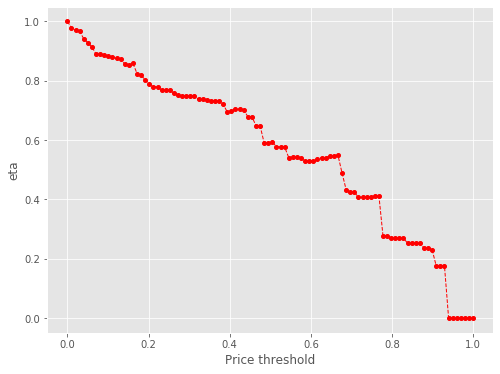

3724 130
Number of cells with price above 6.999999999999999th percentile:  130


eta =  1.0
eta =  0.9915122205492748
eta =  0.9875268001292123
eta =  0.9610077784467721
eta =  0.9463568559981823
eta =  0.9257023176173832
eta =  0.9088665847186105
eta =  0.9088665847186105
eta =  0.9069071050697846
eta =  0.9015435607546649
eta =  0.8926788998212882
eta =  0.8936474173344903
eta =  0.89165462918521
eta =  0.8736594482097316
eta =  0.8721798911689205
eta =  0.8711060142525783
eta =  0.8416103338295694
eta =  0.8349405790027432
eta =  0.8143622313247676
eta =  0.8050804754879848
eta =  0.7965551912036737
eta =  0.7965551912036737
eta =  0.7838838753164332
eta =  0.7838838753164332
eta =  0.7838838753164332
eta =  0.7742108808885797
eta =  0.7672530531511474
eta =  0.7637237946048141
eta =  0.7637237946048141
eta =  0.7644569734072542
eta =  0.7644569734072542
eta =  0.7530799702736232
eta =  0.7530799702736232
eta =  0.7515038213550741
eta =  0.7515038213550741
eta =  0.7486853343018675
eta =  0.7482663561595421
eta =  0.7336934213320342
eta =  0.726829445204694
eta 

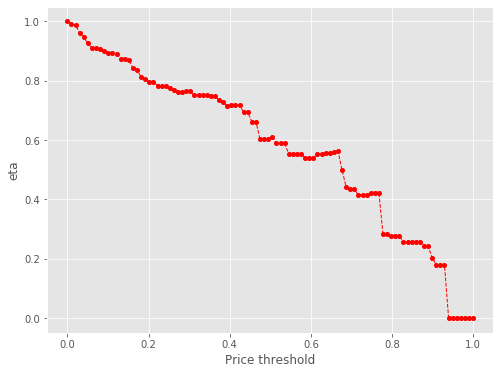

3724 127
Number of cells with price above 8.0th percentile:  127


eta =  1.0
eta =  0.9959804626332748
eta =  0.969234426494911
eta =  0.9544580857247755
eta =  0.9248788255741208
eta =  0.9166468812811197
eta =  0.9166468812811197
eta =  0.91467062762714
eta =  0.9092611690204188
eta =  0.90032062270172
eta =  0.9012974311495933
eta =  0.8992875838597874
eta =  0.8822981176366994
eta =  0.8796461335451347
eta =  0.8839655888421551
eta =  0.8488148873882128
eta =  0.8420880365349461
eta =  0.8271332476722272
eta =  0.811972317438497
eta =  0.8033740529818185
eta =  0.8033740529818185
eta =  0.7905942650733843
eta =  0.7905942650733843
eta =  0.7905942650733843
eta =  0.7808384655709889
eta =  0.7738210757766627
eta =  0.7740188583164974
eta =  0.7702616052293625
eta =  0.7710010603638981
eta =  0.7710010603638981
eta =  0.7595266650938849
eta =  0.7595266650938849
eta =  0.7595266650938849
eta =  0.7579370236493488
eta =  0.7550944091108763
eta =  0.7546718443319033
eta =  0.7399741587910889
eta =  0.733051424017797
eta =  0.7197857927467749
eta =  0

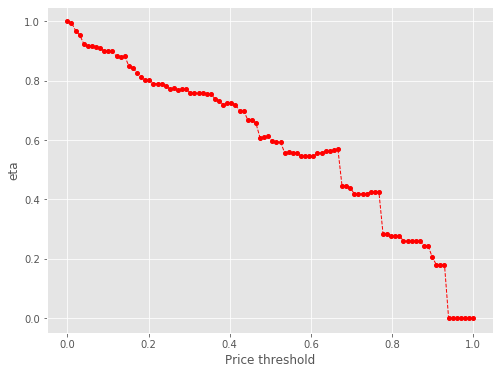

3724 124
Number of cells with price above 9.0th percentile:  124


eta =  1.0
eta =  0.9731460232988408
eta =  0.9583100487747339
eta =  0.9286114138512636
eta =  0.9203462474129213
eta =  0.9203462474129213
eta =  0.9183620180749736
eta =  0.9129307281956328
eta =  0.9039540999844118
eta =  0.9049348505960159
eta =  0.9029168920464153
eta =  0.8858588604278337
eta =  0.8860030427710149
eta =  0.8875330611456341
eta =  0.8577752853254241
eta =  0.8473512640587194
eta =  0.8368497039307072
eta =  0.8246482335651173
eta =  0.806616277248829
eta =  0.806616277248829
eta =  0.8001857637554267
eta =  0.7937849131931067
eta =  0.7937849131931067
eta =  0.7855596272671537
eta =  0.776944031342498
eta =  0.7771426120850478
eta =  0.7733701956290049
eta =  0.7741126350264411
eta =  0.7741126350264411
eta =  0.7672124608277019
eta =  0.7625919318595575
eta =  0.7625919318595575
eta =  0.7609958750048547
eta =  0.758141788358459
eta =  0.7577175182097697
eta =  0.7577175182097697
eta =  0.7360098430843521
eta =  0.7226906749191965
eta =  0.7226906749191965
eta =

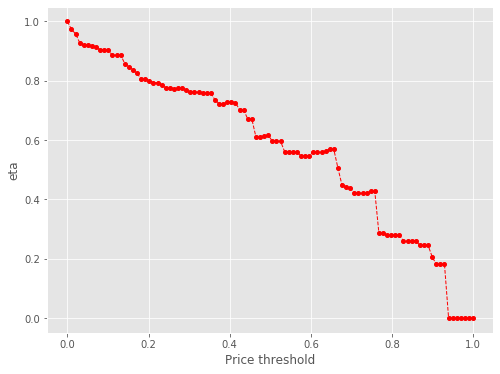

3724 115
Number of cells with price above 10.0th percentile:  115


eta =  1.0
eta =  0.9847546265730863
eta =  0.9542364574469404
eta =  0.9457432136372145
eta =  0.9457432136372145
eta =  0.9437042294658345
eta =  0.9381230630742489
eta =  0.9288987246951108
eta =  0.9299065391321255
eta =  0.9278328949910748
eta =  0.910304146776334
eta =  0.9104523078330811
eta =  0.9120245470839107
eta =  0.8814456050672389
eta =  0.8707339328031232
eta =  0.8599425819918511
eta =  0.8474044118987046
eta =  0.8288748635220261
eta =  0.8288748635220261
eta =  0.822266899928234
eta =  0.8156894178144789
eta =  0.8156894178144789
eta =  0.8156894178144789
eta =  0.8094620810768158
eta =  0.798383811618278
eta =  0.7947113558635103
eta =  0.7947113558635103
eta =  0.7954742828854174
eta =  0.7883836982932424
eta =  0.7836356657703519
eta =  0.7836356657703519
eta =  0.7819955657067535
eta =  0.7757559588598381
eta =  0.7786267426148483
eta =  0.7786267426148483
eta =  0.7634625211024467
eta =  0.7563200439224658
eta =  0.7426333331449758
eta =  0.7484145891386175
eta 

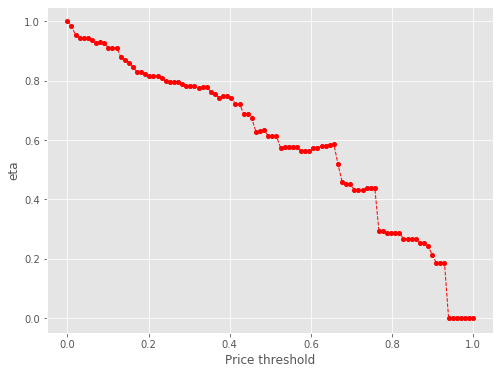

3724 107
Number of cells with price above 11.0th percentile:  107


eta =  1.0
eta =  0.9861852194935322
eta =  0.9610414026397986
eta =  0.9610414026397986
eta =  0.9589694361908012
eta =  0.9532979897558779
eta =  0.9489417468552519
eta =  0.9439244399735672
eta =  0.9435013428758998
eta =  0.9250290791749105
eta =  0.9251796368609078
eta =  0.9267773083991381
eta =  0.900308022780465
eta =  0.8897945354624072
eta =  0.873852873877623
eta =  0.8611118883763766
eta =  0.8512972997466235
eta =  0.8422826090271556
eta =  0.8330924662935189
eta =  0.828883877686036
eta =  0.828883877686036
eta =  0.828883877686036
eta =  0.8186555908406686
eta =  0.8112983388077114
eta =  0.8075664780036343
eta =  0.8075664780036343
eta =  0.808341746009445
eta =  0.808341746009445
eta =  0.7963116293419176
eta =  0.7963116293419176
eta =  0.7963116293419176
eta =  0.7946449992854053
eta =  0.7916647128534046
eta =  0.7912216826569534
eta =  0.7758121671541442
eta =  0.7685541544204629
eta =  0.7546460496268399
eta =  0.7546460496268399
eta =  0.7605208222808052
eta =  0

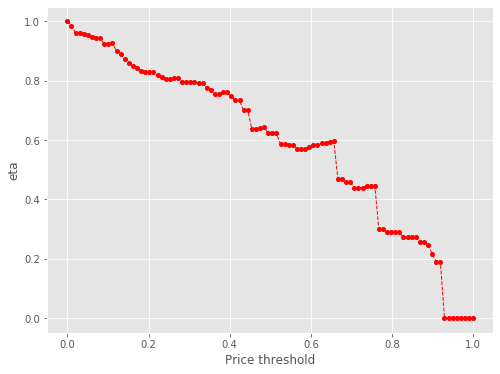

3724 101
Number of cells with price above 12.0th percentile:  101


eta =  1.0
eta =  0.9818130163678261
eta =  0.9818130163678261
eta =  0.979696267158567
eta =  0.9739022400582303
eta =  0.9694518428427239
eta =  0.9647692470448408
eta =  0.9638938518690205
eta =  0.9450223351023201
eta =  0.9451761468896378
eta =  0.9468083499433316
eta =  0.9150631543492113
eta =  0.909026244249528
eta =  0.8927400251506633
eta =  0.8797236604320187
eta =  0.8696969427063111
eta =  0.8604874116053695
eta =  0.8510986363316109
eta =  0.8467990847576475
eta =  0.8467990847576475
eta =  0.8467990847576475
eta =  0.8363497272873645
eta =  0.828833458174697
eta =  0.8290453014438833
eta =  0.8250209382326306
eta =  0.8258129626107559
eta =  0.8258129626107559
eta =  0.8135228311968974
eta =  0.8135228311968974
eta =  0.8135228311968974
eta =  0.8118201791795557
eta =  0.8087754778759434
eta =  0.8083228721793262
eta =  0.8083228721793262
eta =  0.7851654158924893
eta =  0.7709567061720978
eta =  0.7709567061720978
eta =  0.7769584541134679
eta =  0.7769584541134679
eta 

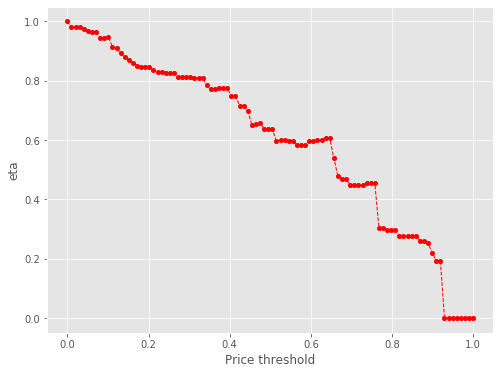

3724 98
Number of cells with price above 13.0th percentile:  98


eta =  1.0
eta =  0.9919426854424264
eta =  0.9919426854424264
eta =  0.9821891516648353
eta =  0.9832547838813636
eta =  0.9810621758761993
eta =  0.9625278126769886
eta =  0.9626844736549482
eta =  0.9643469114373807
eta =  0.932013671742148
eta =  0.9258649346618264
eta =  0.9092770316422526
eta =  0.8960195533835124
eta =  0.8858071019711233
eta =  0.8764269746480899
eta =  0.8668642828552149
eta =  0.8624850869163899
eta =  0.8624850869163899
eta =  0.8624850869163899
eta =  0.8518421668327472
eta =  0.8441866672749255
eta =  0.8444024347027907
eta =  0.8403035246820816
eta =  0.8411102204224329
eta =  0.8411102204224329
eta =  0.8336128527544107
eta =  0.828592428124949
eta =  0.828592428124949
eta =  0.8268582363909257
eta =  0.8202606666098867
eta =  0.8232961457057076
eta =  0.8232961457057076
eta =  0.8072619608511509
eta =  0.7997097235450943
eta =  0.7852378134323561
eta =  0.7913507370148659
eta =  0.7913507370148659
eta =  0.7835278266901685
eta =  0.7632395864529276
eta 

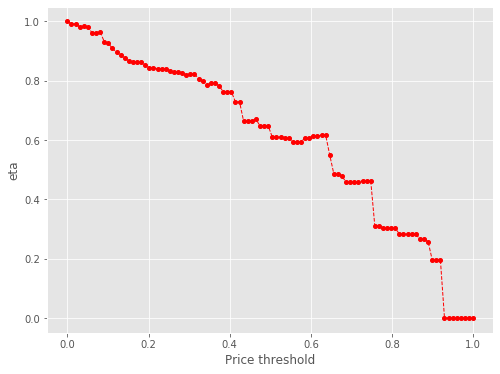

3724 98
Number of cells with price above 14.000000000000002th percentile:  98


eta =  1.0
eta =  0.9919426854424264
eta =  0.9919426854424264
eta =  0.9821891516648353
eta =  0.9832547838813636
eta =  0.9810621758761993
eta =  0.9625278126769886
eta =  0.9626844736549482
eta =  0.9643469114373807
eta =  0.932013671742148
eta =  0.9258649346618264
eta =  0.9092770316422526
eta =  0.8960195533835124
eta =  0.8858071019711233
eta =  0.8764269746480899
eta =  0.8668642828552149
eta =  0.8624850869163899
eta =  0.8624850869163899
eta =  0.8624850869163899
eta =  0.8518421668327472
eta =  0.8441866672749255
eta =  0.8444024347027907
eta =  0.8403035246820816
eta =  0.8411102204224329
eta =  0.8411102204224329
eta =  0.8336128527544107
eta =  0.828592428124949
eta =  0.828592428124949
eta =  0.8268582363909257
eta =  0.8202606666098867
eta =  0.8232961457057076
eta =  0.8232961457057076
eta =  0.8072619608511509
eta =  0.7997097235450943
eta =  0.7852378134323561
eta =  0.7913507370148659
eta =  0.7913507370148659
eta =  0.7835278266901685
eta =  0.7632395864529276
eta 

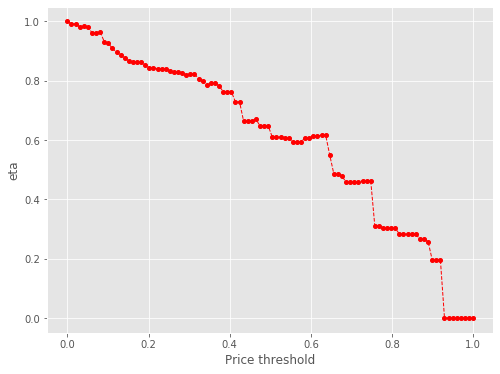

3724 96
Number of cells with price above 15.000000000000002th percentile:  96


eta =  1.0
eta =  0.9940858944812139
eta =  0.9843112870447724
eta =  0.9853792216852532
eta =  0.983181876292169
eta =  0.9646074674176187
eta =  0.9647644668800784
eta =  0.966430496555202
eta =  0.9340273970862291
eta =  0.9278653749350249
eta =  0.9112416317966541
eta =  0.8979555091941904
eta =  0.8877209925773331
eta =  0.8783205983840876
eta =  0.8783205983840876
eta =  0.8643485875613635
eta =  0.8643485875613635
eta =  0.8643485875613635
eta =  0.8553921131383526
eta =  0.8460106320284139
eta =  0.8462268656472278
eta =  0.842119099448501
eta =  0.842119099448501
eta =  0.8429275381500412
eta =  0.8429275381500412
eta =  0.8303826996875003
eta =  0.8303826996875003
eta =  0.824240435462
eta =  0.8286447610279197
eta =  0.8255369597575904
eta =  0.8250749740261044
eta =  0.8090061454260832
eta =  0.8014375906215511
eta =  0.7869344122419892
eta =  0.7869344122419892
eta =  0.7930605435161004
eta =  0.7930605435161004
eta =  0.7910134727058552
eta =  0.7648886555014248
eta =  0.

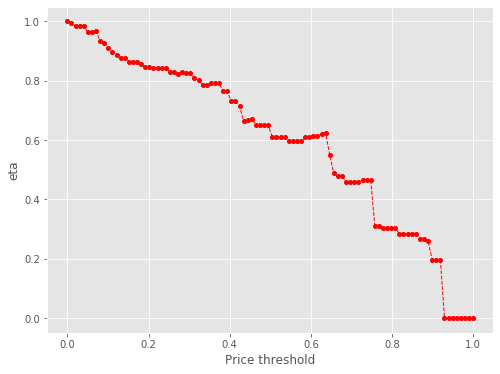

3724 95
Number of cells with price above 16.0th percentile:  95


eta =  1.0
eta =  0.9901672405868484
eta =  0.9912415286804723
eta =  0.9890311106418672
eta =  0.9703461972177172
eta =  0.970504130715548
eta =  0.9721800720847724
eta =  0.9395841971720887
eta =  0.9333855153625857
eta =  0.9166628727512587
eta =  0.9032977071491481
eta =  0.893002302422378
eta =  0.8835459825556211
eta =  0.8835459825556211
eta =  0.8694908481851492
eta =  0.8694908481851492
eta =  0.8694908481851492
eta =  0.8604810890961875
eta =  0.8510437948321594
eta =  0.8512613148875333
eta =  0.847129110395415
eta =  0.847129110395415
eta =  0.8479423587334391
eta =  0.8479423587334391
eta =  0.8353228873857568
eta =  0.8353228873857568
eta =  0.8353228873857568
eta =  0.8335746092246553
eta =  0.8304483187425323
eta =  0.8299835845238388
eta =  0.8138191577985132
eta =  0.8062055754646829
eta =  0.7916161134674069
eta =  0.7916161134674069
eta =  0.7977786908745718
eta =  0.7977786908745718
eta =  0.7898922369095341
eta =  0.7694392001212322
eta =  0.7694392001212322
eta =

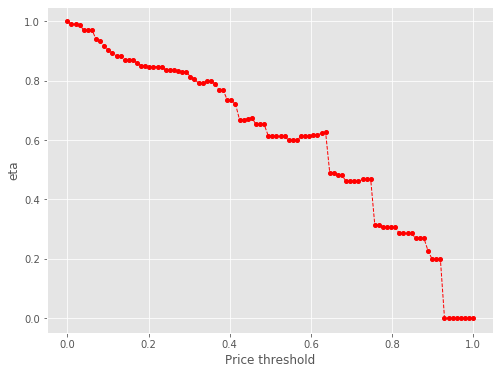

3724 93
Number of cells with price above 17.0th percentile:  93


eta =  1.0
eta =  0.9995517680444006
eta =  0.9896251668351381
eta =  0.9801416275298641
eta =  0.9818342116717421
eta =  0.9758335437602157
eta =  0.9427917854875447
eta =  0.9353201685061627
eta =  0.9281606220711764
eta =  0.912267817115203
eta =  0.8923199499429658
eta =  0.8923199499429658
eta =  0.8852061888642637
eta =  0.8781252424285648
eta =  0.8781252424285648
eta =  0.8781252424285648
eta =  0.867289325471426
eta =  0.85949500240764
eta =  0.8597146825247534
eta =  0.8555414435780989
eta =  0.8563627677995932
eta =  0.8563627677995932
eta =  0.848729444161968
eta =  0.8436179800199015
eta =  0.8436179800199015
eta =  0.8418523407526749
eta =  0.8418523407526749
eta =  0.8386950049471901
eta =  0.8382256557305688
eta =  0.8219007097388742
eta =  0.814211521466681
eta =  0.799477180236982
eta =  0.799477180236982
eta =  0.8057009545193067
eta =  0.8057009545193067
eta =  0.7977361848907302
eta =  0.7770800412112242
eta =  0.7770800412112242
eta =  0.7422043112691099
eta =  0.

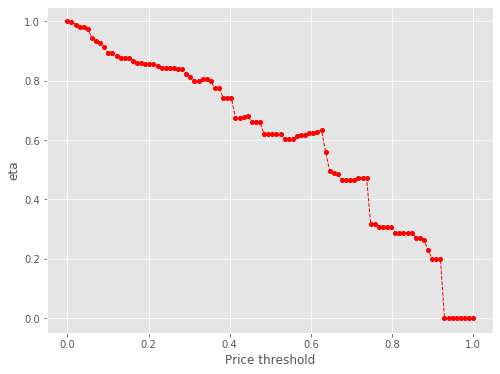

3724 89
Number of cells with price above 18.000000000000004th percentile:  89


eta =  1.0
eta =  0.9804215819718032
eta =  0.9805811553387455
eta =  0.9822744984911361
eta =  0.9655576455746461
eta =  0.9432145643962939
eta =  0.9261808480462991
eta =  0.9191216335771417
eta =  0.9126769080705378
eta =  0.8927200956172272
eta =  0.8927200956172272
eta =  0.885603144493605
eta =  0.8785190227281535
eta =  0.8785190227281535
eta =  0.8785190227281535
eta =  0.8676782465887255
eta =  0.8598804282935956
eta =  0.8601002069225137
eta =  0.8559250965579757
eta =  0.8567467890883197
eta =  0.8567467890883197
eta =  0.8491100424167995
eta =  0.8439962861257503
eta =  0.8439962861257503
eta =  0.842229855087685
eta =  0.842229855087685
eta =  0.8390711034287669
eta =  0.8386015437404882
eta =  0.8222692771049802
eta =  0.8145766407473487
eta =  0.7951799181390902
eta =  0.7998356921534341
eta =  0.8060622573812676
eta =  0.8060622573812676
eta =  0.79809391608749
eta =  0.7774285095123816
eta =  0.7774285095123816
eta =  0.7774285095123816
eta =  0.7425371401435416
eta = 

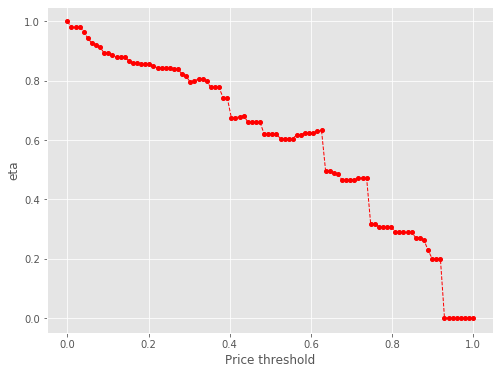

3724 87
Number of cells with price above 19.0th percentile:  87


eta =  1.0
eta =  0.9904170390738922
eta =  0.9921273675887692
eta =  0.986063791082609
eta =  0.9526756362741174
eta =  0.9451256898582673
eta =  0.9354710603754929
eta =  0.921831666865014
eta =  0.9016746742573672
eta =  0.9016746742573672
eta =  0.894486335361892
eta =  0.8873311551249706
eta =  0.8873311551249706
eta =  0.8873311551249706
eta =  0.8763816387623334
eta =  0.8685056031429963
eta =  0.8687275862983115
eta =  0.8645105967890404
eta =  0.8645105967890404
eta =  0.8653405314441189
eta =  0.8653405314441189
eta =  0.8524621324231542
eta =  0.8524621324231542
eta =  0.8524621324231542
eta =  0.8506779829023077
eta =  0.84748754685511
eta =  0.8470132771696266
eta =  0.8470132771696266
eta =  0.8305171869944925
eta =  0.8227473883577181
eta =  0.8078585782066788
eta =  0.814147600041308
eta =  0.814147600041308
eta =  0.814147600041308
eta =  0.8120460987109219
eta =  0.7852266365621623
eta =  0.7852266365621623
eta =  0.7499852834611207
eta =  0.7500403360596958
eta =  0.

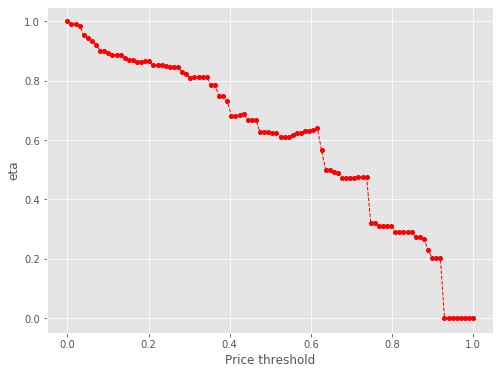

3724 84
Number of cells with price above 20.0th percentile:  84


eta =  1.0
eta =  1.0017268771107535
eta =  0.9681403380316763
eta =  0.9617532639190367
eta =  0.9445223814507698
eta =  0.9307510174976289
eta =  0.920142711565763
eta =  0.9103989922270469
eta =  0.9103989922270469
eta =  0.9031411012458933
eta =  0.8959166897559496
eta =  0.8959166897559496
eta =  0.8959166897559496
eta =  0.884861229348205
eta =  0.8769089877079543
eta =  0.8771331187018261
eta =  0.8728753269404745
eta =  0.8737132917798663
eta =  0.8737132917798663
eta =  0.8659253115296421
eta =  0.8607102854573914
eta =  0.8607102854573914
eta =  0.8607102854573914
eta =  0.8589088730720442
eta =  0.8556875673782519
eta =  0.8552087088098181
eta =  0.8552087088098181
eta =  0.8385530077017687
eta =  0.830708030959406
eta =  0.8156751614068373
eta =  0.8220250338206941
eta =  0.8220250338206941
eta =  0.8220250338206941
eta =  0.8199031990304212
eta =  0.7928242402780176
eta =  0.7928242402780176
eta =  0.7572419030294635
eta =  0.7572974882995095
eta =  0.7441863133399869
eta 

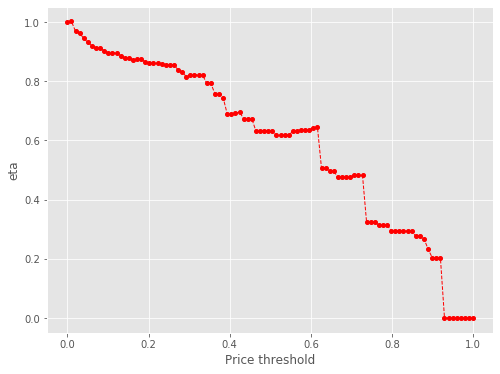

3724 81
Number of cells with price above 21.000000000000004th percentile:  81


eta =  1.0
eta =  0.96647136076058
eta =  0.954726422207813
eta =  0.9428941191784964
eta =  0.9291464956816993
eta =  0.9185564774099892
eta =  0.908829555270474
eta =  0.908829555270474
eta =  0.8943722188427363
eta =  0.8943722188427363
eta =  0.8943722188427363
eta =  0.8943722188427363
eta =  0.885695205853157
eta =  0.8753972841750965
eta =  0.8756210287895151
eta =  0.871370577036007
eta =  0.872207097307689
eta =  0.872207097307689
eta =  0.8644325427577634
eta =  0.8592265068697253
eta =  0.8592265068697253
eta =  0.8592265068697253
eta =  0.8574281999394542
eta =  0.8542124474550211
eta =  0.8537344143909439
eta =  0.8537344143909439
eta =  0.8371074260484838
eta =  0.8292759732626809
eta =  0.8142690188761443
eta =  0.8206079447440132
eta =  0.8206079447440132
eta =  0.8206079447440132
eta =  0.8184897677850473
eta =  0.7914574904536188
eta =  0.7914574904536188
eta =  0.7559364936014799
eta =  0.7559364936014799
eta =  0.7429034104449888
eta =  0.6880406010693391
eta =  0.6

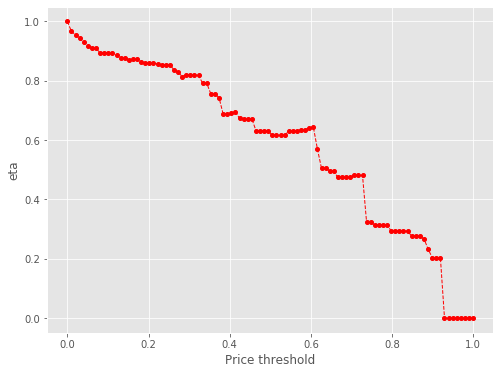

3724 77
Number of cells with price above 22.0th percentile:  77


eta =  1.0
eta =  0.9878476082896815
eta =  0.9756048212711351
eta =  0.9613802678544894
eta =  0.9504228626982972
eta =  0.9403584960399199
eta =  0.9403584960399199
eta =  0.9253996084673382
eta =  0.9253996084673382
eta =  0.9253996084673382
eta =  0.9253996084673382
eta =  0.9164215742059288
eta =  0.9057663990024378
eta =  0.9059979057221428
eta =  0.9015999981109301
eta =  0.902465538783572
eta =  0.902465538783572
eta =  0.902465538783572
eta =  0.889034628189648
eta =  0.889034628189648
eta =  0.889034628189648
eta =  0.8871739347399673
eta =  0.8838466219865895
eta =  0.8833520050910603
eta =  0.8833520050910603
eta =  0.866148196455308
eta =  0.8580450564102271
eta =  0.8425174836379449
eta =  0.8425174836379449
eta =  0.8490763183072727
eta =  0.8490763183072727
eta =  0.8406827608285775
eta =  0.8189145820428333
eta =  0.8189145820428333
eta =  0.8189145820428333
eta =  0.7821612975749054
eta =  0.7822187120507438
eta =  0.7455210425570757
eta =  0.7119099737501529
eta =  0

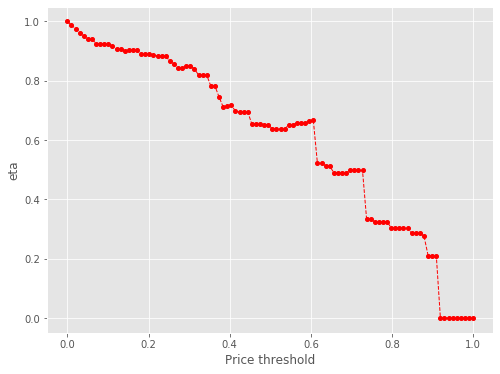

3724 74
Number of cells with price above 23.0th percentile:  74


eta =  1.0
eta =  0.9876066035734569
eta =  0.9732070612783923
eta =  0.9621148593393064
eta =  0.9519266819585844
eta =  0.9519266819585844
eta =  0.9367837718102459
eta =  0.9367837718102459
eta =  0.9367837718102459
eta =  0.9367837718102459
eta =  0.9276952907671491
eta =  0.9169090367801206
eta =  0.9171433914698139
eta =  0.9126913812869608
eta =  0.9135675697449565
eta =  0.9135675697449565
eta =  0.9135675697449565
eta =  0.8999714335785918
eta =  0.8999714335785918
eta =  0.8999714335785918
eta =  0.8980878500844716
eta =  0.8947196050986497
eta =  0.894218903480932
eta =  0.894218903480932
eta =  0.8768034554994987
eta =  0.8686006315243409
eta =  0.8528820402740507
eta =  0.8528820402740507
eta =  0.8595215610000092
eta =  0.8595215610000092
eta =  0.8510247469081803
eta =  0.8289887784014258
eta =  0.8289887784014258
eta =  0.8289887784014258
eta =  0.7917833591044545
eta =  0.7918414798868064
eta =  0.7735726257921385
eta =  0.7206678112859172
eta =  0.7206678112859172
eta

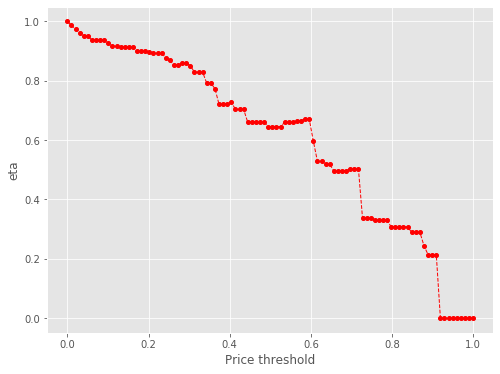

3724 72
Number of cells with price above 24.000000000000004th percentile:  72


eta =  1.0
eta =  0.9854197589982057
eta =  0.9638723338971491
eta =  0.9638723338971491
eta =  0.9533555260815995
eta =  0.9485393965782338
eta =  0.9485393965782338
eta =  0.9485393965782338
eta =  0.9485393965782338
eta =  0.9393368649120705
eta =  0.9284152550848371
eta =  0.9286525506728226
eta =  0.9241446725695937
eta =  0.9250318562466016
eta =  0.9250318562466016
eta =  0.9250318562466016
eta =  0.9112651032528795
eta =  0.9112651032528795
eta =  0.9112651032528795
eta =  0.90935788281986
eta =  0.9059473699966016
eta =  0.9059473699966016
eta =  0.9054403851142548
eta =  0.8878063920663964
eta =  0.8795006315080147
eta =  0.8635847889109567
eta =  0.8635847889109567
eta =  0.8703076284524651
eta =  0.8703076284524651
eta =  0.8617041885189077
eta =  0.8393916924025172
eta =  0.8393916924025172
eta =  0.8393916924025172
eta =  0.8017193852689368
eta =  0.8017782354043467
eta =  0.7878969603631094
eta =  0.7297114141180556
eta =  0.7297114141180556
eta =  0.7323720765823915
eta

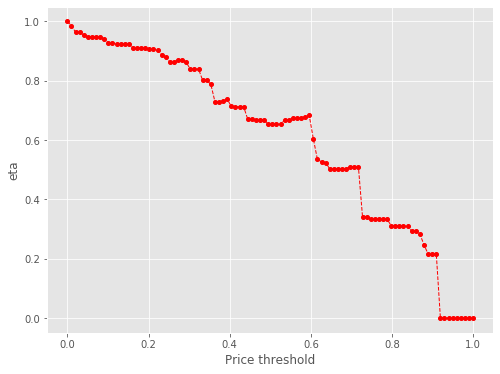

3724 69
Number of cells with price above 25.0th percentile:  69


eta =  1.0
eta =  0.9781337598477201
eta =  0.9781337598477201
eta =  0.9703358731468635
eta =  0.9625739568511749
eta =  0.9625739568511749
eta =  0.9625739568511749
eta =  0.9636813287184313
eta =  0.9552252380455811
eta =  0.9421520591678411
eta =  0.9423928657741819
eta =  0.9378182892426419
eta =  0.9387185996625484
eta =  0.9387185996625484
eta =  0.9387185996625484
eta =  0.9247481542071847
eta =  0.9247481542071847
eta =  0.9247481542071847
eta =  0.9228127145982221
eta =  0.919351739930203
eta =  0.919351739930203
eta =  0.9188372537148441
eta =  0.9009423486382651
eta =  0.8925136962974336
eta =  0.8763623633738495
eta =  0.8763623633738495
eta =  0.8831846738462343
eta =  0.8831846738462343
eta =  0.87445393767518
eta =  0.8684252858580485
eta =  0.8518113065399225
eta =  0.8518113065399225
eta =  0.8135816010874172
eta =  0.8136413219676537
eta =  0.7995546600000174
eta =  0.7405082021694923
eta =  0.7405082021694923
eta =  0.7432082317153182
eta =  0.7480268993518935
eta =

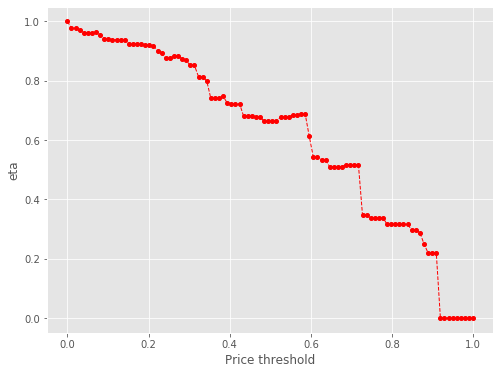

3724 67
Number of cells with price above 26.0th percentile:  67


eta =  1.0
eta =  0.9840923566537897
eta =  0.9840923566537897
eta =  0.9840923566537897
eta =  0.9840923566537897
eta =  0.971948823431394
eta =  0.9632139261960646
eta =  0.9634601160488494
eta =  0.9587832745785662
eta =  0.9587832745785662
eta =  0.9597037114930907
eta =  0.9597037114930907
eta =  0.9511492421706094
eta =  0.9454209558733084
eta =  0.9454209558733084
eta =  0.9454209558733084
eta =  0.9434422493932624
eta =  0.9399039044244127
eta =  0.9393779168381761
eta =  0.9393779168381761
eta =  0.9210829700618118
eta =  0.9124658946812998
eta =  0.8959534977202762
eta =  0.8959534977202762
eta =  0.9029283213614181
eta =  0.9029283213614181
eta =  0.8940024090481434
eta =  0.8878389863501372
eta =  0.8708536005060658
eta =  0.8708536005060658
eta =  0.8317692676450292
eta =  0.8317692676450292
eta =  0.8318303235892038
eta =  0.757062308415546
eta =  0.757062308415546
eta =  0.7598226972873566
eta =  0.7598226972873566
eta =  0.764749086534289
eta =  0.7390944136889986
eta =

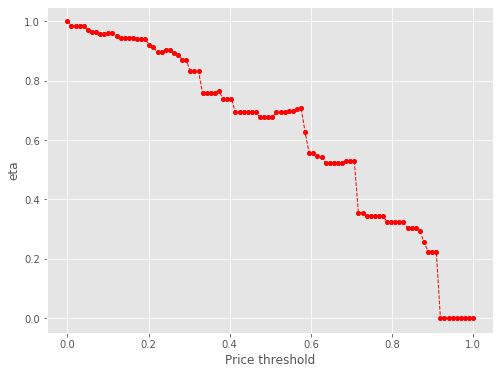

3724 67
Number of cells with price above 27.0th percentile:  67


eta =  1.0
eta =  0.9840923566537897
eta =  0.9840923566537897
eta =  0.9840923566537897
eta =  0.9840923566537897
eta =  0.971948823431394
eta =  0.9632139261960646
eta =  0.9634601160488494
eta =  0.9587832745785662
eta =  0.9587832745785662
eta =  0.9597037114930907
eta =  0.9597037114930907
eta =  0.9511492421706094
eta =  0.9454209558733084
eta =  0.9454209558733084
eta =  0.9454209558733084
eta =  0.9434422493932624
eta =  0.9399039044244127
eta =  0.9393779168381761
eta =  0.9393779168381761
eta =  0.9210829700618118
eta =  0.9124658946812998
eta =  0.8959534977202762
eta =  0.8959534977202762
eta =  0.9029283213614181
eta =  0.9029283213614181
eta =  0.8940024090481434
eta =  0.8878389863501372
eta =  0.8708536005060658
eta =  0.8708536005060658
eta =  0.8317692676450292
eta =  0.8317692676450292
eta =  0.8318303235892038
eta =  0.757062308415546
eta =  0.757062308415546
eta =  0.7598226972873566
eta =  0.7598226972873566
eta =  0.764749086534289
eta =  0.7390944136889986
eta =

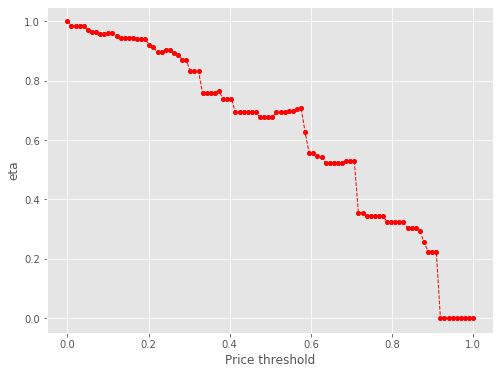

3724 64
Number of cells with price above 28.000000000000004th percentile:  64


eta =  1.0
eta =  0.9902982082775258
eta =  0.9787840741607647
eta =  0.9790342436200845
eta =  0.9742818020035416
eta =  0.9742818020035416
eta =  0.9752171175847482
eta =  0.9752171175847482
eta =  0.9665243670876617
eta =  0.9607034842624166
eta =  0.9607034842624166
eta =  0.9607034842624166
eta =  0.9586927924135598
eta =  0.9550972508519109
eta =  0.9550972508519109
eta =  0.9545627607883714
eta =  0.9359720800939572
eta =  0.9272157115252461
eta =  0.9272157115252461
eta =  0.9104363951842772
eta =  0.9175239653640297
eta =  0.9175239653640297
eta =  0.9175239653640297
eta =  0.9084537675793163
eta =  0.8849307634775564
eta =  0.8849307634775564
eta =  0.8849307634775564
eta =  0.8452146407002847
eta =  0.8452766836007928
eta =  0.8452766836007928
eta =  0.7693000593864846
eta =  0.7693000593864846
eta =  0.7721050693564805
eta =  0.7721050693564805
eta =  0.7771110926363315
eta =  0.7510417174686147
eta =  0.7510417174686147
eta =  0.7510417174686147
eta =  0.7510417174686147
e

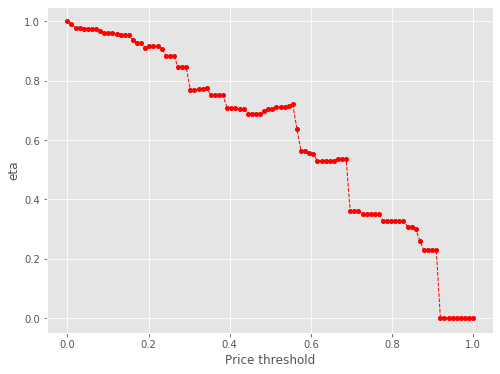

3724 64
Number of cells with price above 29.000000000000004th percentile:  64


eta =  1.0
eta =  0.9902982082775258
eta =  0.9787840741607647
eta =  0.9790342436200845
eta =  0.9742818020035416
eta =  0.9742818020035416
eta =  0.9752171175847482
eta =  0.9752171175847482
eta =  0.9665243670876617
eta =  0.9607034842624166
eta =  0.9607034842624166
eta =  0.9607034842624166
eta =  0.9586927924135598
eta =  0.9550972508519109
eta =  0.9550972508519109
eta =  0.9545627607883714
eta =  0.9359720800939572
eta =  0.9272157115252461
eta =  0.9272157115252461
eta =  0.9104363951842772
eta =  0.9175239653640297
eta =  0.9175239653640297
eta =  0.9175239653640297
eta =  0.9084537675793163
eta =  0.8849307634775564
eta =  0.8849307634775564
eta =  0.8849307634775564
eta =  0.8452146407002847
eta =  0.8452766836007928
eta =  0.8452766836007928
eta =  0.7693000593864846
eta =  0.7693000593864846
eta =  0.7721050693564805
eta =  0.7721050693564805
eta =  0.7771110926363315
eta =  0.7510417174686147
eta =  0.7510417174686147
eta =  0.7510417174686147
eta =  0.7510417174686147
e

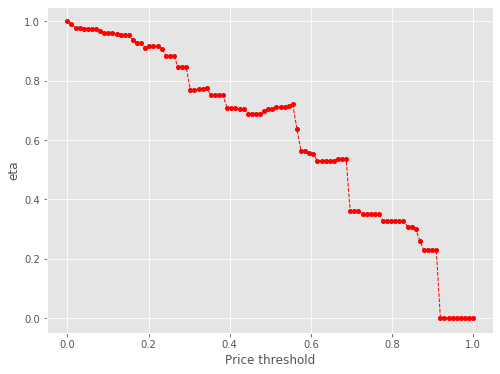

3724 64
Number of cells with price above 30.0th percentile:  64


eta =  1.0
eta =  0.9902982082775258
eta =  0.9787840741607647
eta =  0.9790342436200845
eta =  0.9742818020035416
eta =  0.9742818020035416
eta =  0.9752171175847482
eta =  0.9752171175847482
eta =  0.9665243670876617
eta =  0.9607034842624166
eta =  0.9607034842624166
eta =  0.9607034842624166
eta =  0.9586927924135598
eta =  0.9550972508519109
eta =  0.9550972508519109
eta =  0.9545627607883714
eta =  0.9359720800939572
eta =  0.9272157115252461
eta =  0.9272157115252461
eta =  0.9104363951842772
eta =  0.9175239653640297
eta =  0.9175239653640297
eta =  0.9175239653640297
eta =  0.9084537675793163
eta =  0.8849307634775564
eta =  0.8849307634775564
eta =  0.8849307634775564
eta =  0.8452146407002847
eta =  0.8452766836007928
eta =  0.8452766836007928
eta =  0.7693000593864846
eta =  0.7693000593864846
eta =  0.7721050693564805
eta =  0.7721050693564805
eta =  0.7771110926363315
eta =  0.7510417174686147
eta =  0.7510417174686147
eta =  0.7510417174686147
eta =  0.7510417174686147
e

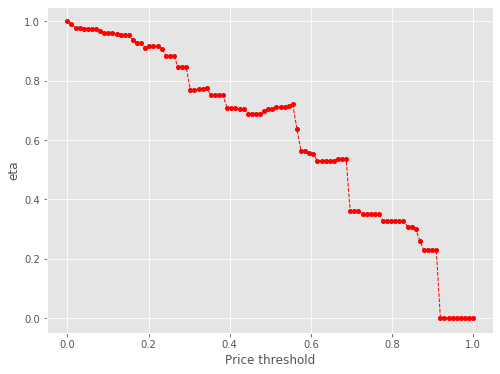

3724 59
Number of cells with price above 31.0th percentile:  59


eta =  1.0
eta =  0.9883730637695608
eta =  0.9886256840986988
eta =  0.983826683578634
eta =  0.983826683578634
eta =  0.9847711622956393
eta =  0.9847711622956393
eta =  0.9705711889302295
eta =  0.9701153412500011
eta =  0.9701153412500011
eta =  0.9701153412500011
eta =  0.9680849509776062
eta =  0.9644541844755615
eta =  0.9644541844755615
eta =  0.9639144580991308
eta =  0.9451416475062994
eta =  0.9482285734396602
eta =  0.9362994942079093
eta =  0.9193557936127581
eta =  0.9193557936127581
eta =  0.9265127995737003
eta =  0.9265127995737003
eta =  0.9173537425251272
eta =  0.8936002873485552
eta =  0.8936002873485552
eta =  0.8936002873485552
eta =  0.8534950721262113
eta =  0.8534950721262113
eta =  0.8535577228510026
eta =  0.8135131947357995
eta =  0.7768367679111183
eta =  0.7768367679111183
eta =  0.7796692581110903
eta =  0.7847243245930929
eta =  0.7602893809680509
eta =  0.758399551964189
eta =  0.758399551964189
eta =  0.758399551964189
eta =  0.7137729332515252
eta = 

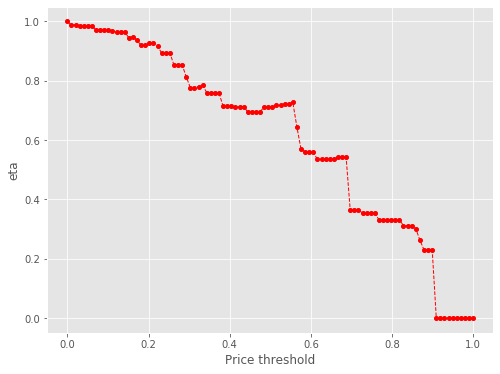

3724 57
Number of cells with price above 32.0th percentile:  57


eta =  1.0
eta =  0.9954001375011301
eta =  0.9954001375011301
eta =  0.9963557267939049
eta =  0.9963557267939049
eta =  0.9963557267939049
eta =  0.9815274988879943
eta =  0.9815274988879943
eta =  0.9815274988879943
eta =  0.9794732236888593
eta =  0.9794732236888593
eta =  0.9757997458947587
eta =  0.9752536703325896
eta =  0.9752536703325896
eta =  0.9562600217994803
eta =  0.9473138519547993
eta =  0.9331968494903106
eta =  0.9301708305428951
eta =  0.9374120294619004
eta =  0.9374120294619004
eta =  0.9374120294619004
eta =  0.9281452279025365
eta =  0.9041123439164244
eta =  0.9041123439164244
eta =  0.9041123439164244
eta =  0.8635353424860269
eta =  0.8635353424860269
eta =  0.8635987302159113
eta =  0.8230831297983149
eta =  0.785975252045353
eta =  0.785975252045353
eta =  0.788841062844738
eta =  0.7939555956737925
eta =  0.7692332064052612
eta =  0.7673211459969632
eta =  0.7673211459969632
eta =  0.7673211459969632
eta =  0.720090818735818
eta =  0.7221695525870194
eta =

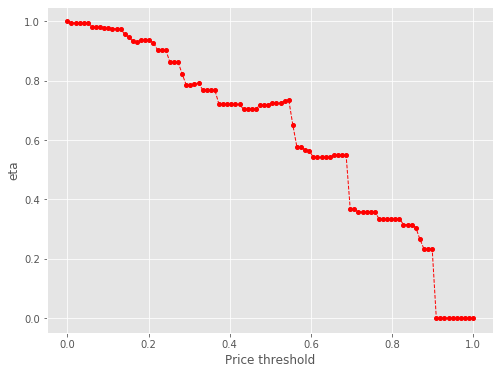

3724 55
Number of cells with price above 33.0th percentile:  55


eta =  1.0
eta =  1.0009600051846224
eta =  1.0009600051846224
eta =  0.9920377914275651
eta =  0.9860632542728376
eta =  0.9860632542728376
eta =  0.9860632542728376
eta =  0.983999486023526
eta =  0.976148073305086
eta =  0.980309032651355
eta =  0.9797604336090242
eta =  0.9797604336090242
eta =  0.9606790131655921
eta =  0.951691502005367
eta =  0.9344692606513118
eta =  0.9344692606513118
eta =  0.9417439220123034
eta =  0.9417439220123034
eta =  0.9417439220123034
eta =  0.9324342974600832
eta =  0.9082903546568959
eta =  0.9082903546568959
eta =  0.9082903546568959
eta =  0.8675258420737826
eta =  0.8675258420737826
eta =  0.8675895227259106
eta =  0.826886694896986
eta =  0.7896073372246853
eta =  0.7896073372246853
eta =  0.7924863912768371
eta =  0.7976245589707799
eta =  0.7727879245992045
eta =  0.7708670283322038
eta =  0.7708670283322038
eta =  0.7708670283322038
eta =  0.7234184441078606
eta =  0.7255067840355803
eta =  0.7255067840355803
eta =  0.7255067840355803
eta = 

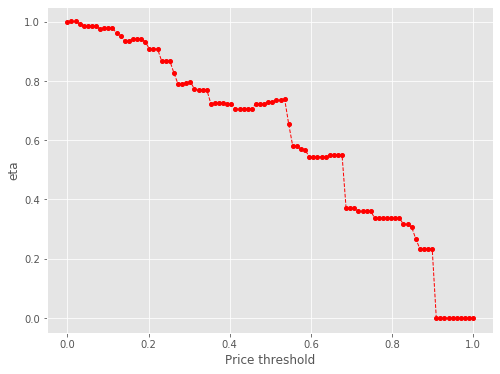

3724 54
Number of cells with price above 34.0th percentile:  54


eta =  1.0
eta =  0.9851175363304979
eta =  0.9851175363304979
eta =  0.9851175363304979
eta =  0.9830557474092404
eta =  0.9830557474092404
eta =  0.9793688334935438
eta =  0.9788207606040285
eta =  0.9788207606040285
eta =  0.959757640854391
eta =  0.959757640854391
eta =  0.9507787494764409
eta =  0.93357302570641
eta =  0.93357302570641
eta =  0.940840710052749
eta =  0.940840710052749
eta =  0.940840710052749
eta =  0.9384121848028351
eta =  0.9074192274938757
eta =  0.9074192274938757
eta =  0.9074192274938757
eta =  0.8666938115212421
eta =  0.8666938115212421
eta =  0.8667574310982463
eta =  0.8260936407189123
eta =  0.7888500370991807
eta =  0.7888500370991807
eta =  0.7917263298953355
eta =  0.7968595696524975
eta =  0.7720467557109512
eta =  0.7701277017457067
eta =  0.7701277017457067
eta =  0.7701277017457067
eta =  0.7701277017457067
eta =  0.7248109617544249
eta =  0.7248109617544249
eta =  0.7248109617544249
eta =  0.7227745446037939
eta =  0.7227745446037939
eta =  0.7

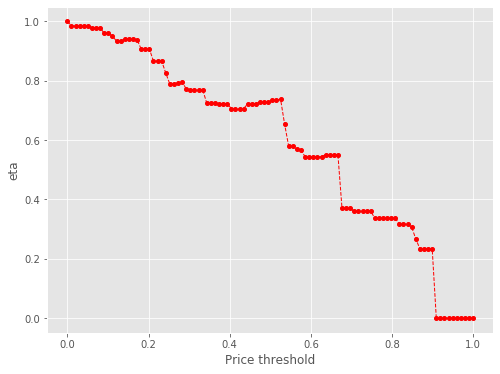

3724 54
Number of cells with price above 35.0th percentile:  54


eta =  1.0
eta =  0.9851175363304979
eta =  0.9851175363304979
eta =  0.9851175363304979
eta =  0.9830557474092404
eta =  0.9830557474092404
eta =  0.9793688334935438
eta =  0.9788207606040285
eta =  0.9788207606040285
eta =  0.959757640854391
eta =  0.959757640854391
eta =  0.9507787494764409
eta =  0.93357302570641
eta =  0.93357302570641
eta =  0.940840710052749
eta =  0.940840710052749
eta =  0.940840710052749
eta =  0.9384121848028351
eta =  0.9074192274938757
eta =  0.9074192274938757
eta =  0.9074192274938757
eta =  0.8666938115212421
eta =  0.8666938115212421
eta =  0.8667574310982463
eta =  0.8260936407189123
eta =  0.7888500370991807
eta =  0.7888500370991807
eta =  0.7917263298953355
eta =  0.7968595696524975
eta =  0.7720467557109512
eta =  0.7701277017457067
eta =  0.7701277017457067
eta =  0.7701277017457067
eta =  0.7701277017457067
eta =  0.7248109617544249
eta =  0.7248109617544249
eta =  0.7248109617544249
eta =  0.7227745446037939
eta =  0.7227745446037939
eta =  0.7

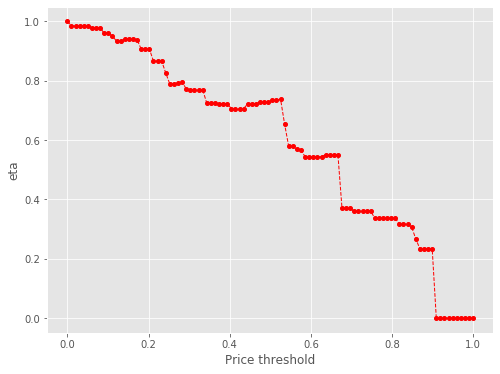

3724 52
Number of cells with price above 36.00000000000001th percentile:  52


eta =  1.0
eta =  0.9995303305049361
eta =  0.9995303305049361
eta =  0.9995303305049361
eta =  0.9974383765137684
eta =  0.9894797337843217
eta =  0.9936975210840432
eta =  0.9931414295962816
eta =  0.9931414295962816
eta =  0.9737994062527667
eta =  0.9646891489123072
eta =  0.9417179429034024
eta =  0.9472316962407247
eta =  0.9546057106794086
eta =  0.9546057106794086
eta =  0.9546057106794086
eta =  0.945168940710306
eta =  0.9206952540323063
eta =  0.9206952540323063
eta =  0.9206952540323063
eta =  0.9206952540323063
eta =  0.8793740035359382
eta =  0.8794385539012342
eta =  0.8642127371984217
eta =  0.8003913332388873
eta =  0.8003913332388873
eta =  0.8033097077304009
eta =  0.8033097077304009
eta =  0.8085180495188835
eta =  0.78334221089547
eta =  0.7813950801487343
eta =  0.7813950801487343
eta =  0.7813950801487343
eta =  0.7332984708630318
eta =  0.7354153321182457
eta =  0.7354153321182457
eta =  0.7333491211002201
eta =  0.7333491211002201
eta =  0.7333491211002201
eta 

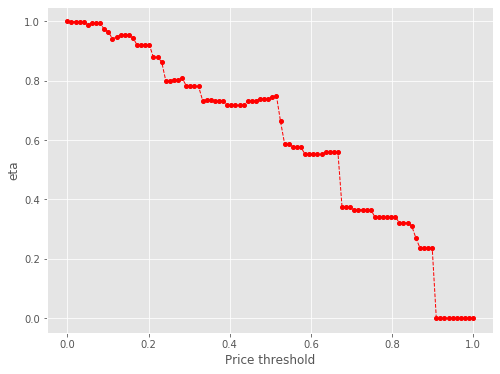

3724 51
Number of cells with price above 37.0th percentile:  51


eta =  1.0
eta =  0.9979070630201777
eta =  0.9941644497991907
eta =  0.9941644497991907
eta =  0.9936080970094954
eta =  0.9936080970094954
eta =  0.9742569850389924
eta =  0.9651424468779971
eta =  0.947676791120694
eta =  0.947676791120694
eta =  0.95505427053641
eta =  0.95505427053641
eta =  0.95505427053641
eta =  0.9456130663216911
eta =  0.9525890568331192
eta =  0.9211278796984536
eta =  0.9211278796984536
eta =  0.9211278796984536
eta =  0.879787212751915
eta =  0.8798517934487943
eta =  0.8798517934487943
eta =  0.8385736830917254
eta =  0.8007674292730576
eta =  0.8007674292730576
eta =  0.80368717508011
eta =  0.8088979642172957
eta =  0.8088979642172957
eta =  0.7817622500299658
eta =  0.7817622500299658
eta =  0.7817622500299658
eta =  0.7817622500299658
eta =  0.735760896567024
eta =  0.735760896567024
eta =  0.735760896567024
eta =  0.7336937146567144
eta =  0.7336937146567144
eta =  0.7336937146567144
eta =  0.7171360683929688
eta =  0.7171360683929688
eta =  0.717136

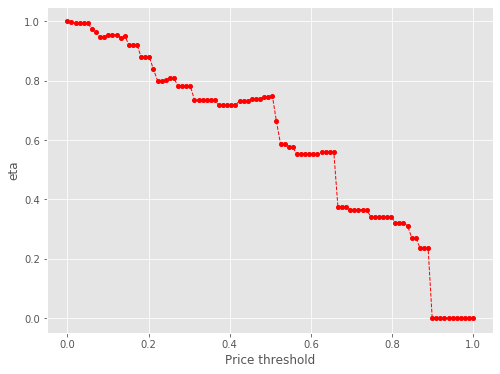

3724 51
Number of cells with price above 38.0th percentile:  51


eta =  1.0
eta =  0.9979070630201777
eta =  0.9941644497991907
eta =  0.9941644497991907
eta =  0.9936080970094954
eta =  0.9936080970094954
eta =  0.9742569850389924
eta =  0.9651424468779971
eta =  0.947676791120694
eta =  0.947676791120694
eta =  0.95505427053641
eta =  0.95505427053641
eta =  0.95505427053641
eta =  0.9456130663216911
eta =  0.9525890568331192
eta =  0.9211278796984536
eta =  0.9211278796984536
eta =  0.9211278796984536
eta =  0.879787212751915
eta =  0.8798517934487943
eta =  0.8798517934487943
eta =  0.8385736830917254
eta =  0.8007674292730576
eta =  0.8007674292730576
eta =  0.80368717508011
eta =  0.8088979642172957
eta =  0.8088979642172957
eta =  0.7817622500299658
eta =  0.7817622500299658
eta =  0.7817622500299658
eta =  0.7817622500299658
eta =  0.735760896567024
eta =  0.735760896567024
eta =  0.735760896567024
eta =  0.7336937146567144
eta =  0.7336937146567144
eta =  0.7336937146567144
eta =  0.7171360683929688
eta =  0.7171360683929688
eta =  0.717136

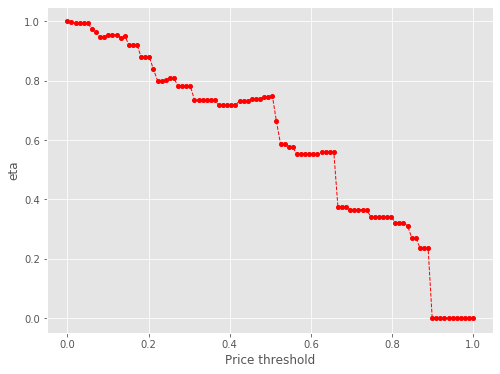

3724 49
Number of cells with price above 39.0th percentile:  49


eta =  1.0
eta =  0.9962495372969303
eta =  0.9956920176537567
eta =  0.9956920176537567
eta =  0.9763003200823049
eta =  0.9671666657584143
eta =  0.9671666657584143
eta =  0.9496643788175412
eta =  0.9496643788175412
eta =  0.9570573312167234
eta =  0.9570573312167234
eta =  0.9570573312167234
eta =  0.947596325713721
eta =  0.9230597856584448
eta =  0.9230597856584448
eta =  0.9230597856584448
eta =  0.8816324138334369
eta =  0.8816324138334369
eta =  0.8816971299771266
eta =  0.8664322102975475
eta =  0.8024469000645463
eta =  0.8024469000645463
eta =  0.8024469000645463
eta =  0.8053727695320054
eta =  0.8105944873956059
eta =  0.7853539921267074
eta =  0.7834018607544002
eta =  0.7834018607544002
eta =  0.7834018607544002
eta =  0.7834018607544002
eta =  0.7373040274314071
eta =  0.7373040274314071
eta =  0.7373040274314071
eta =  0.735232509965589
eta =  0.735232509965589
eta =  0.735232509965589
eta =  0.7186401369106938
eta =  0.7186401369106938
eta =  0.7186401369106938
eta =

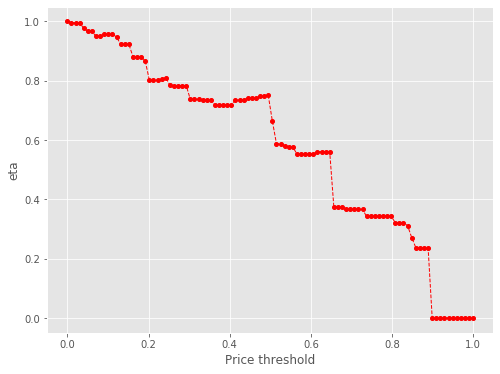

3724 47
Number of cells with price above 40.0th percentile:  47


eta =  1.0
eta =  0.9994403815286216
eta =  0.9994403815286216
eta =  0.9799756823287944
eta =  0.9708076436176573
eta =  0.9532394678889528
eta =  0.9532394678889528
eta =  0.9606602516608992
eta =  0.9606602516608992
eta =  0.9606602516608992
eta =  0.9511636294304162
eta =  0.9581805676370049
eta =  0.9265347195672811
eta =  0.9265347195672811
eta =  0.9265347195672811
eta =  0.8849513910194852
eta =  0.8849513910194852
eta =  0.8850163507923803
eta =  0.8645978263847769
eta =  0.8054677769204108
eta =  0.8054677769204108
eta =  0.8084046610623072
eta =  0.8084046610623072
eta =  0.8136460365090336
eta =  0.7883105213354134
eta =  0.7863510410052104
eta =  0.7863510410052104
eta =  0.7863510410052104
eta =  0.7863510410052104
eta =  0.7400796686258887
eta =  0.7400796686258887
eta =  0.7400796686258887
eta =  0.7380003527634806
eta =  0.7380003527634806
eta =  0.7380003527634806
eta =  0.7213455163658505
eta =  0.7213455163658505
eta =  0.7213455163658505
eta =  0.7213455163658505
e

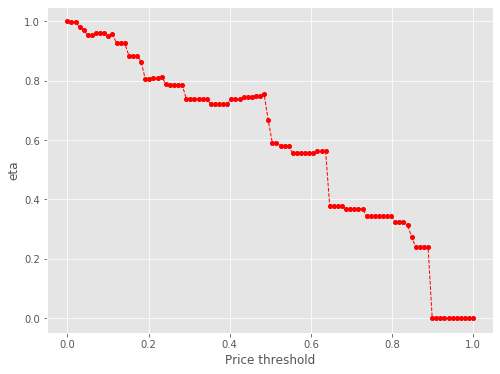

3724 46
Number of cells with price above 41.0th percentile:  46


eta =  1.0
eta =  0.9805244018957325
eta =  0.971351229707998
eta =  0.9537732169986912
eta =  0.9537732169986912
eta =  0.9611981559035978
eta =  0.9611981559035978
eta =  0.9611981559035978
eta =  0.9516962162121495
eta =  0.9587170834257159
eta =  0.9270535158387008
eta =  0.9270535158387008
eta =  0.9270535158387008
eta =  0.8854469034620874
eta =  0.8854469034620874
eta =  0.8855118996080263
eta =  0.8701809344009843
eta =  0.8059187839583447
eta =  0.8059187839583447
eta =  0.8059187839583447
eta =  0.8088573125551226
eta =  0.8141016228147399
eta =  0.8141016228147399
eta =  0.7867913439744191
eta =  0.7867913439744191
eta =  0.7867913439744191
eta =  0.7867913439744191
eta =  0.7383625826193982
eta =  0.7404940627813672
eta =  0.7404940627813672
eta =  0.7404940627813672
eta =  0.7384135826438449
eta =  0.7384135826438449
eta =  0.7384135826438449
eta =  0.721749420673366
eta =  0.721749420673366
eta =  0.721749420673366
eta =  0.721749420673366
eta =  0.721749420673366
eta =  

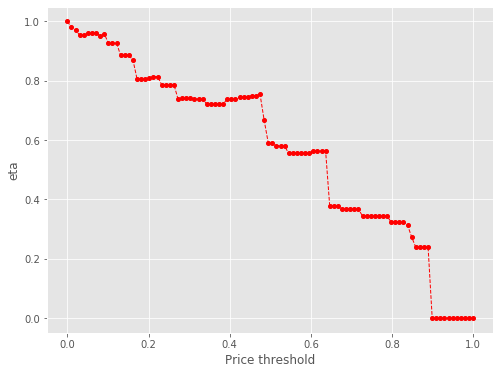

3724 45
Number of cells with price above 42.00000000000001th percentile:  45


eta =  1.0
eta =  0.9906446263142464
eta =  0.9727174715434711
eta =  0.9727174715434711
eta =  0.9802898877837516
eta =  0.9802898877837516
eta =  0.9802898877837516
eta =  0.9705992164724845
eta =  0.9777595351754075
eta =  0.9454670521675422
eta =  0.9454670521675422
eta =  0.9454670521675422
eta =  0.9030340313307618
eta =  0.9030340313307618
eta =  0.9031003184581533
eta =  0.8874648430152156
eta =  0.8219262900547832
eta =  0.8219262900547832
eta =  0.8219262900547832
eta =  0.8249231849725401
eta =  0.8302716599819105
eta =  0.8302716599819105
eta =  0.8024189326173294
eta =  0.8024189326173294
eta =  0.8024189326173294
eta =  0.8024189326173294
eta =  0.7530282583399843
eta =  0.7552020748792239
eta =  0.7552020748792239
eta =  0.7552020748792239
eta =  0.7530802713488886
eta =  0.7530802713488886
eta =  0.7530802713488886
eta =  0.7360851186140248
eta =  0.7360851186140248
eta =  0.7360851186140248
eta =  0.7360851186140248
eta =  0.7360851186140248
eta =  0.752497504780762
et

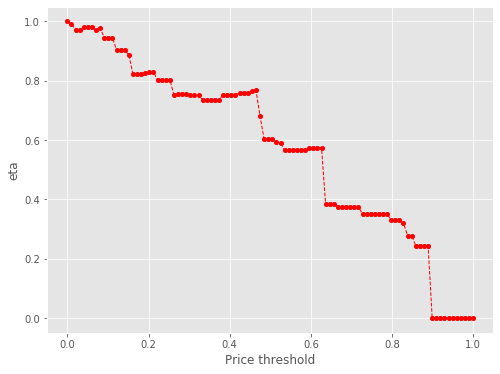

3724 43
Number of cells with price above 43.0th percentile:  43


eta =  1.0
eta =  0.9819035461409865
eta =  0.9819035461409865
eta =  0.9895474741845415
eta =  0.9895474741845415
eta =  0.9895474741845415
eta =  0.9797652868553457
eta =  0.9543957813461421
eta =  0.9543957813461421
eta =  0.9543957813461421
eta =  0.9543957813461421
eta =  0.9115620348041
eta =  0.9115620348041
eta =  0.9116289479287774
eta =  0.8905964349053787
eta =  0.8296883344664272
eta =  0.8296883344664272
eta =  0.8327135312303837
eta =  0.8327135312303837
eta =  0.8381125157575292
eta =  0.8120151571920271
eta =  0.8099967549440791
eta =  0.8099967549440791
eta =  0.8099967549440791
eta =  0.8099967549440791
eta =  0.76013964880794
eta =  0.7623339942689631
eta =  0.7623339942689631
eta =  0.7623339942689631
eta =  0.7601921530133056
eta =  0.7601921530133056
eta =  0.7601921530133056
eta =  0.7430365027594953
eta =  0.7430365027594953
eta =  0.7430365027594953
eta =  0.7430365027594953
eta =  0.7430365027594953
eta =  0.7596038829589928
eta =  0.7596038829589928
eta =  0.

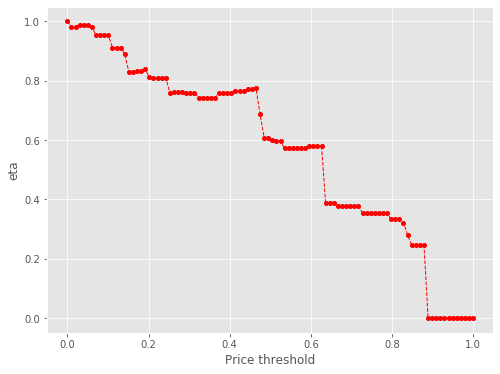

3724 40
Number of cells with price above 44.0th percentile:  40


eta =  1.0
eta =  1.007784805415559
eta =  1.007784805415559
eta =  1.007784805415559
eta =  0.9978223326577804
eta =  0.9719852678983046
eta =  0.9719852678983046
eta =  0.9719852678983046
eta =  0.9719852678983046
eta =  0.9283620966505944
eta =  0.9283620966505944
eta =  0.9284302429822177
eta =  0.9070101013541939
eta =  0.8449794663918002
eta =  0.8449794663918002
eta =  0.8449794663918002
eta =  0.8480604174443206
eta =  0.8535589050996144
eta =  0.826980572973136
eta =  0.8249249716303354
eta =  0.8249249716303354
eta =  0.8249249716303354
eta =  0.8249249716303354
eta =  0.7741490004750379
eta =  0.7763837876592243
eta =  0.7763837876592243
eta =  0.7763837876592243
eta =  0.7742024723313846
eta =  0.7742024723313846
eta =  0.7742024723313846
eta =  0.7567306439412802
eta =  0.7567306439412802
eta =  0.7567306439412802
eta =  0.7567306439412802
eta =  0.7567306439412802
eta =  0.7658270622924958
eta =  0.7736033604770434
eta =  0.7736033604770434
eta =  0.7736033604770434
eta =

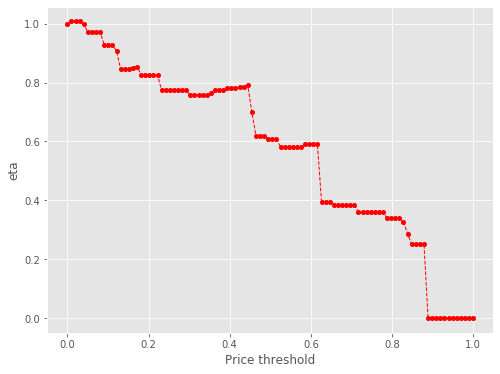

3724 39
Number of cells with price above 45.0th percentile:  39


eta =  1.0
eta =  0.9974187710799867
eta =  0.9644770021091036
eta =  0.9644770021091036
eta =  0.9644770021091036
eta =  0.9644770021091036
eta =  0.9211908054793359
eta =  0.9211908054793359
eta =  0.921258425403011
eta =  0.9000037473081263
eta =  0.8384522785530327
eta =  0.8384522785530327
eta =  0.8384522785530327
eta =  0.8415094302742774
eta =  0.8469654439249561
eta =  0.8469654439249561
eta =  0.8205924206528709
eta =  0.8185526981528348
eta =  0.8185526981528348
eta =  0.8185526981528348
eta =  0.8185526981528348
eta =  0.7703864788267802
eta =  0.7703864788267802
eta =  0.7703864788267802
eta =  0.7703864788267802
eta =  0.768222013440799
eta =  0.768222013440799
eta =  0.768222013440799
eta =  0.7508851491655931
eta =  0.7508851491655931
eta =  0.7508851491655931
eta =  0.7508851491655931
eta =  0.7508851491655931
eta =  0.7599113006835897
eta =  0.7676275295280414
eta =  0.7676275295280414
eta =  0.7676275295280414
eta =  0.7743782090466119
eta =  0.7743782090466119
eta =

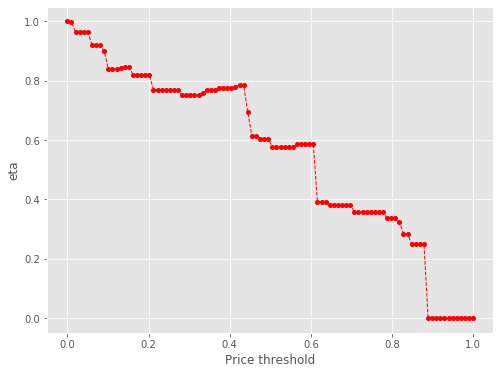

3724 39
Number of cells with price above 46.0th percentile:  39


eta =  1.0
eta =  0.9974187710799867
eta =  0.9644770021091036
eta =  0.9644770021091036
eta =  0.9644770021091036
eta =  0.9644770021091036
eta =  0.9211908054793359
eta =  0.9211908054793359
eta =  0.921258425403011
eta =  0.9000037473081263
eta =  0.8384522785530327
eta =  0.8384522785530327
eta =  0.8384522785530327
eta =  0.8415094302742774
eta =  0.8469654439249561
eta =  0.8469654439249561
eta =  0.8205924206528709
eta =  0.8185526981528348
eta =  0.8185526981528348
eta =  0.8185526981528348
eta =  0.8185526981528348
eta =  0.7703864788267802
eta =  0.7703864788267802
eta =  0.7703864788267802
eta =  0.7703864788267802
eta =  0.768222013440799
eta =  0.768222013440799
eta =  0.768222013440799
eta =  0.7508851491655931
eta =  0.7508851491655931
eta =  0.7508851491655931
eta =  0.7508851491655931
eta =  0.7508851491655931
eta =  0.7599113006835897
eta =  0.7676275295280414
eta =  0.7676275295280414
eta =  0.7676275295280414
eta =  0.7743782090466119
eta =  0.7743782090466119
eta =

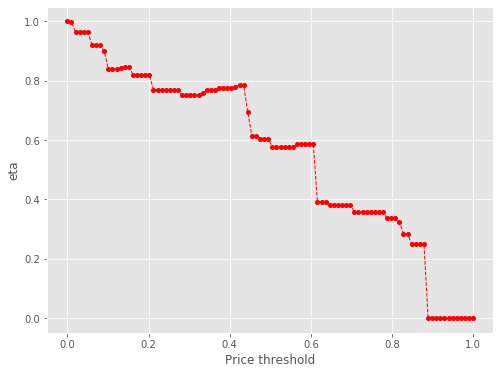

3724 35
Number of cells with price above 47.0th percentile:  35


eta =  1.0
eta =  0.9551195139592648
eta =  0.9551896244165667
eta =  0.9551896244165667
eta =  0.9331521076604333
eta =  0.8693336147150404
eta =  0.8693336147150404
eta =  0.8693336147150404
eta =  0.8725033654862453
eta =  0.8725033654862453
eta =  0.8781603315297566
eta =  0.8508159539920722
eta =  0.8487011057421133
eta =  0.8487011057421133
eta =  0.8487011057421133
eta =  0.8487011057421133
eta =  0.796461660523886
eta =  0.7987608591413904
eta =  0.7987608591413904
eta =  0.7987608591413904
eta =  0.7965166735555776
eta =  0.7965166735555776
eta =  0.7965166735555776
eta =  0.7965166735555776
eta =  0.7785412690230756
eta =  0.7785412690230756
eta =  0.7785412690230756
eta =  0.7785412690230756
eta =  0.7785412690230756
eta =  0.7785412690230756
eta =  0.7959002939929155
eta =  0.7959002939929155
eta =  0.7959002939929155
eta =  0.7959002939929155
eta =  0.802899610206582
eta =  0.802899610206582
eta =  0.802899610206582
eta =  0.809214277584602
eta =  0.809214277584602
eta =  

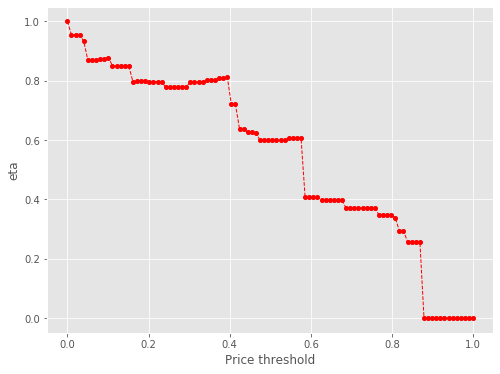

3724 35
Number of cells with price above 48.00000000000001th percentile:  35


eta =  1.0
eta =  0.9551195139592648
eta =  0.9551896244165667
eta =  0.9551896244165667
eta =  0.9331521076604333
eta =  0.8693336147150404
eta =  0.8693336147150404
eta =  0.8693336147150404
eta =  0.8725033654862453
eta =  0.8725033654862453
eta =  0.8781603315297566
eta =  0.8508159539920722
eta =  0.8487011057421133
eta =  0.8487011057421133
eta =  0.8487011057421133
eta =  0.8487011057421133
eta =  0.796461660523886
eta =  0.7987608591413904
eta =  0.7987608591413904
eta =  0.7987608591413904
eta =  0.7965166735555776
eta =  0.7965166735555776
eta =  0.7965166735555776
eta =  0.7965166735555776
eta =  0.7785412690230756
eta =  0.7785412690230756
eta =  0.7785412690230756
eta =  0.7785412690230756
eta =  0.7785412690230756
eta =  0.7785412690230756
eta =  0.7959002939929155
eta =  0.7959002939929155
eta =  0.7959002939929155
eta =  0.7959002939929155
eta =  0.802899610206582
eta =  0.802899610206582
eta =  0.802899610206582
eta =  0.809214277584602
eta =  0.809214277584602
eta =  

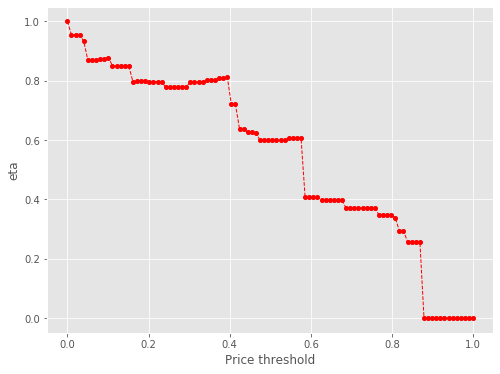

3724 34
Number of cells with price above 49.0th percentile:  34


eta =  1.0
eta =  0.9717667966606987
eta =  0.971838129110208
eta =  0.971838129110208
eta =  0.9494165088297352
eta =  0.8844856896486052
eta =  0.8844856896486052
eta =  0.8844856896486052
eta =  0.8877106876809225
eta =  0.8934662519747913
eta =  0.8934662519747913
eta =  0.8656452748320193
eta =  0.8634935657744094
eta =  0.8634935657744094
eta =  0.8634935657744094
eta =  0.8634935657744094
eta =  0.8103436116617413
eta =  0.8126828842268647
eta =  0.8126828842268647
eta =  0.8126828842268647
eta =  0.8103995835446316
eta =  0.8103995835446316
eta =  0.8103995835446316
eta =  0.8103995835446316
eta =  0.7921108761881879
eta =  0.7921108761881879
eta =  0.7921108761881879
eta =  0.7921108761881879
eta =  0.7921108761881879
eta =  0.7921108761881879
eta =  0.809772460776872
eta =  0.809772460776872
eta =  0.809772460776872
eta =  0.809772460776872
eta =  0.8168937717713199
eta =  0.8168937717713199
eta =  0.8168937717713199
eta =  0.8233185008237913
eta =  0.8233185008237913
eta =  

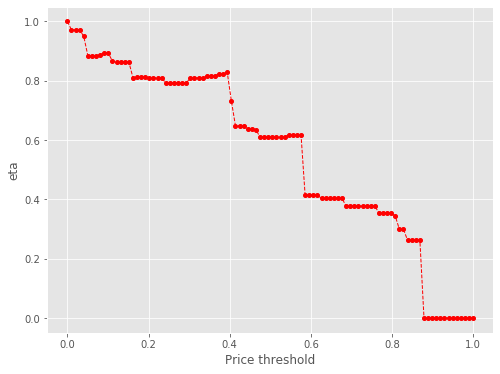

3724 32
Number of cells with price above 50.0th percentile:  32


eta =  1.0
eta =  0.9530851551767949
eta =  0.910116266438753
eta =  0.910116266438753
eta =  0.910116266438753
eta =  0.9134347182834753
eta =  0.919357066997184
eta =  0.919357066997184
eta =  0.8907298951365323
eta =  0.8885158339743304
eta =  0.8885158339743304
eta =  0.8885158339743304
eta =  0.8885158339743304
eta =  0.8338257034673797
eta =  0.8362327633419138
eta =  0.8362327633419138
eta =  0.8362327633419138
eta =  0.8362327633419138
eta =  0.8338832973003584
eta =  0.8338832973003584
eta =  0.8338832973003584
eta =  0.8150646208061686
eta =  0.8150646208061686
eta =  0.8150646208061686
eta =  0.8150646208061686
eta =  0.8150646208061686
eta =  0.8150646208061686
eta =  0.8248622533369626
eta =  0.8332380018041488
eta =  0.8332380018041488
eta =  0.8332380018041488
eta =  0.8405656737498545
eta =  0.8405656737498545
eta =  0.8405656737498545
eta =  0.8405656737498545
eta =  0.8471765782410722
eta =  0.8471765782410722
eta =  0.8523189426319777
eta =  0.7539256355632324
eta = 

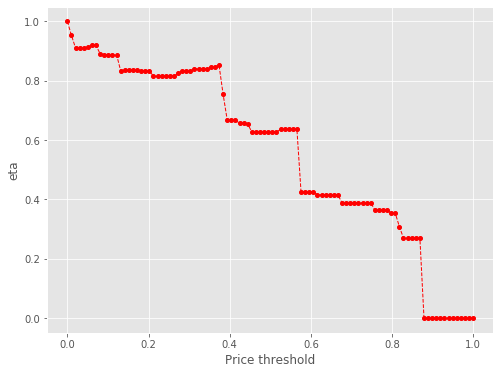

3724 30
Number of cells with price above 51.0th percentile:  30


eta =  1.0
eta =  0.9316097639157711
eta =  0.9316097639157711
eta =  0.9316097639157711
eta =  0.935006585018337
eta =  0.9410687971668946
eta =  0.9410687971668946
eta =  0.9117655599848652
eta =  0.9094992110878337
eta =  0.9094992110878337
eta =  0.9094992110878337
eta =  0.9094992110878337
eta =  0.9094992110878337
eta =  0.8559814124451972
eta =  0.8559814124451972
eta =  0.8559814124451972
eta =  0.8559814124451972
eta =  0.8535764609186562
eta =  0.8535764609186562
eta =  0.8535764609186562
eta =  0.8535764609186562
eta =  0.8343133585959607
eta =  0.8343133585959607
eta =  0.8343133585959607
eta =  0.8343133585959607
eta =  0.8343133585959607
eta =  0.8443423740806111
eta =  0.8529159259880676
eta =  0.8529159259880676
eta =  0.8529159259880676
eta =  0.8529159259880676
eta =  0.8604166497781204
eta =  0.8604166497781204
eta =  0.8604166497781204
eta =  0.8671836787824827
eta =  0.8671836787824827
eta =  0.8671836787824827
eta =  0.8724474863341553
eta =  0.7717305021977396
et

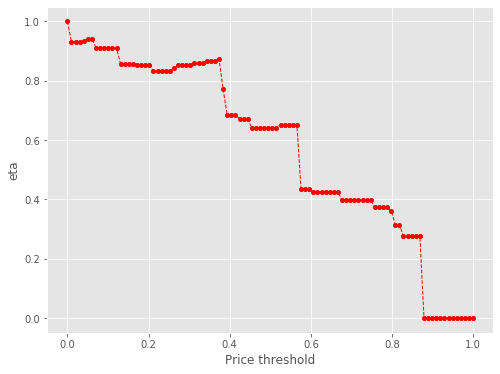

3724 28
Number of cells with price above 52.0th percentile:  28


eta =  1.0
eta =  1.0036461845228932
eta =  1.0101534286323546
eta =  1.0101534286323546
eta =  0.9786990167991627
eta =  0.9762662933726654
eta =  0.9762662933726654
eta =  0.9762662933726654
eta =  0.9762662933726654
eta =  0.9762662933726654
eta =  0.9188197092818237
eta =  0.9188197092818237
eta =  0.9188197092818237
eta =  0.9188197092818237
eta =  0.9162382082932206
eta =  0.9162382082932206
eta =  0.9162382082932206
eta =  0.9162382082932206
eta =  0.8955609858457783
eta =  0.8955609858457783
eta =  0.8955609858457783
eta =  0.8955609858457783
eta =  0.8955609858457783
eta =  0.8955609858457783
eta =  0.9155291829521676
eta =  0.9155291829521676
eta =  0.9155291829521676
eta =  0.9155291829521676
eta =  0.9155291829521676
eta =  0.9235805410213719
eta =  0.9235805410213719
eta =  0.9235805410213719
eta =  0.9308443431695149
eta =  0.9308443431695149
eta =  0.9364945711464604
eta =  0.9364945711464604
eta =  0.8283838706820527
eta =  0.733264037924048
eta =  0.733264037924048
eta

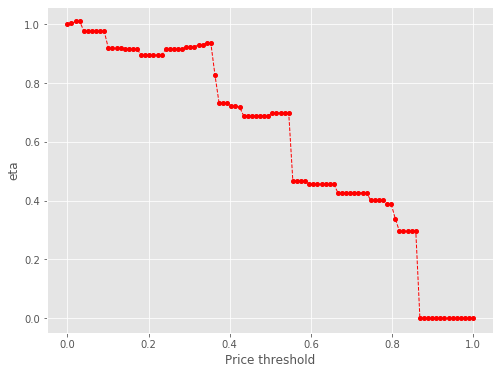

3724 27
Number of cells with price above 53.0th percentile:  27


eta =  1.0
eta =  1.0064836036940197
eta =  0.975143463793877
eta =  0.9727195783011484
eta =  0.9727195783011484
eta =  0.9727195783011484
eta =  0.9727195783011484
eta =  0.9727195783011484
eta =  0.9128465196005504
eta =  0.9154816940978121
eta =  0.9154816940978121
eta =  0.9154816940978121
eta =  0.9154816940978121
eta =  0.9129095715426606
eta =  0.9129095715426606
eta =  0.9129095715426606
eta =  0.8923074681656904
eta =  0.8923074681656904
eta =  0.8923074681656904
eta =  0.8923074681656904
eta =  0.8923074681656904
eta =  0.8923074681656904
eta =  0.8923074681656904
eta =  0.9122031220468255
eta =  0.9122031220468255
eta =  0.9122031220468255
eta =  0.9122031220468255
eta =  0.9202252300300603
eta =  0.9202252300300603
eta =  0.9202252300300603
eta =  0.9202252300300603
eta =  0.9274626432341927
eta =  0.9274626432341927
eta =  0.933092344282308
eta =  0.8253744033071219
eta =  0.8253744033071219
eta =  0.7306001350193169
eta =  0.7306001350193169
eta =  0.7306001350193169
eta

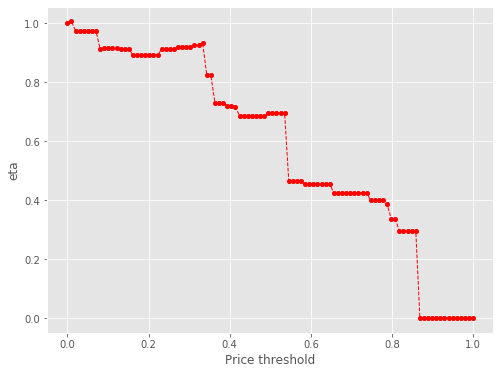

3724 26
Number of cells with price above 54.0th percentile:  26


eta =  1.0
eta =  0.9664534769677819
eta =  0.9664534769677819
eta =  0.9664534769677819
eta =  0.9664534769677819
eta =  0.9664534769677819
eta =  0.9069661107743829
eta =  0.9095843099060826
eta =  0.9095843099060826
eta =  0.9095843099060826
eta =  0.9095843099060826
eta =  0.9070287565461359
eta =  0.9070287565461359
eta =  0.9070287565461359
eta =  0.9070287565461359
eta =  0.8865593685686708
eta =  0.8865593685686708
eta =  0.8865593685686708
eta =  0.8865593685686708
eta =  0.8865593685686708
eta =  0.8865593685686708
eta =  0.8972164167194999
eta =  0.9063268578830657
eta =  0.9063268578830657
eta =  0.9063268578830657
eta =  0.9063268578830657
eta =  0.9142972887512804
eta =  0.9142972887512804
eta =  0.9142972887512804
eta =  0.9142972887512804
eta =  0.9214880797165473
eta =  0.9214880797165473
eta =  0.9270815151460498
eta =  0.8200574756288264
eta =  0.8200574756288264
eta =  0.7258937277645171
eta =  0.7258937277645171
eta =  0.7142390934426106
eta =  0.7142390934426106
e

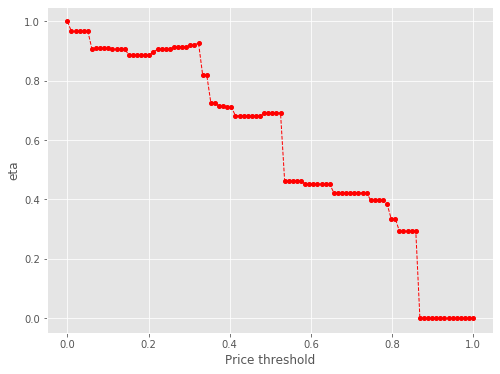

3724 24
Number of cells with price above 55.00000000000001th percentile:  24


eta =  1.0
eta =  0.9411568498463843
eta =  0.9411568498463843
eta =  0.9411568498463843
eta =  0.9411568498463843
eta =  0.9385125907890681
eta =  0.9385125907890681
eta =  0.9385125907890681
eta =  0.9385125907890681
eta =  0.9173326908091051
eta =  0.9173326908091051
eta =  0.9173326908091051
eta =  0.9173326908091051
eta =  0.9173326908091051
eta =  0.9173326908091051
eta =  0.9173326908091051
eta =  0.9283596552774468
eta =  0.9377863285531739
eta =  0.9377863285531739
eta =  0.9377863285531739
eta =  0.9377863285531739
eta =  0.9460334206876259
eta =  0.9460334206876259
eta =  0.9460334206876259
eta =  0.9460334206876259
eta =  0.9534738108736366
eta =  0.9534738108736366
eta =  0.9534738108736366
eta =  0.9592613997879541
eta =  0.8485224536640207
eta =  0.7510901921963035
eta =  0.7510901921963035
eta =  0.7510901921963035
eta =  0.7390310143883116
eta =  0.7390310143883116
eta =  0.7390310143883116
eta =  0.7359813756201798
eta =  0.7058590154478438
eta =  0.7058590154478438
e

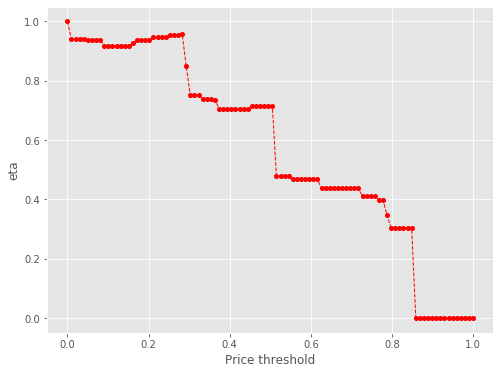

3724 24
Number of cells with price above 56.00000000000001th percentile:  24


eta =  1.0
eta =  0.9411568498463843
eta =  0.9411568498463843
eta =  0.9411568498463843
eta =  0.9411568498463843
eta =  0.9385125907890681
eta =  0.9385125907890681
eta =  0.9385125907890681
eta =  0.9385125907890681
eta =  0.9173326908091051
eta =  0.9173326908091051
eta =  0.9173326908091051
eta =  0.9173326908091051
eta =  0.9173326908091051
eta =  0.9173326908091051
eta =  0.9173326908091051
eta =  0.9283596552774468
eta =  0.9377863285531739
eta =  0.9377863285531739
eta =  0.9377863285531739
eta =  0.9377863285531739
eta =  0.9460334206876259
eta =  0.9460334206876259
eta =  0.9460334206876259
eta =  0.9460334206876259
eta =  0.9534738108736366
eta =  0.9534738108736366
eta =  0.9534738108736366
eta =  0.9592613997879541
eta =  0.8485224536640207
eta =  0.7510901921963035
eta =  0.7510901921963035
eta =  0.7510901921963035
eta =  0.7390310143883116
eta =  0.7390310143883116
eta =  0.7390310143883116
eta =  0.7359813756201798
eta =  0.7058590154478438
eta =  0.7058590154478438
e

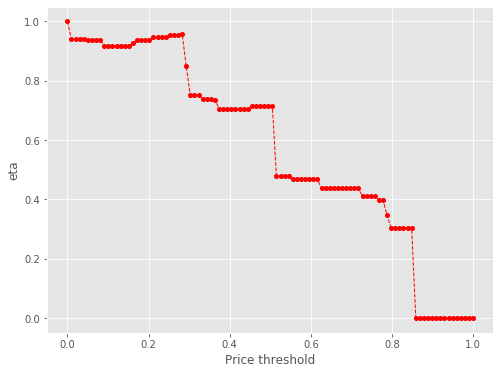

3724 24
Number of cells with price above 57.00000000000001th percentile:  24


eta =  1.0
eta =  0.9411568498463843
eta =  0.9411568498463843
eta =  0.9411568498463843
eta =  0.9411568498463843
eta =  0.9385125907890681
eta =  0.9385125907890681
eta =  0.9385125907890681
eta =  0.9385125907890681
eta =  0.9173326908091051
eta =  0.9173326908091051
eta =  0.9173326908091051
eta =  0.9173326908091051
eta =  0.9173326908091051
eta =  0.9173326908091051
eta =  0.9173326908091051
eta =  0.9283596552774468
eta =  0.9377863285531739
eta =  0.9377863285531739
eta =  0.9377863285531739
eta =  0.9377863285531739
eta =  0.9460334206876259
eta =  0.9460334206876259
eta =  0.9460334206876259
eta =  0.9460334206876259
eta =  0.9534738108736366
eta =  0.9534738108736366
eta =  0.9534738108736366
eta =  0.9592613997879541
eta =  0.8485224536640207
eta =  0.7510901921963035
eta =  0.7510901921963035
eta =  0.7510901921963035
eta =  0.7390310143883116
eta =  0.7390310143883116
eta =  0.7390310143883116
eta =  0.7359813756201798
eta =  0.7058590154478438
eta =  0.7058590154478438
e

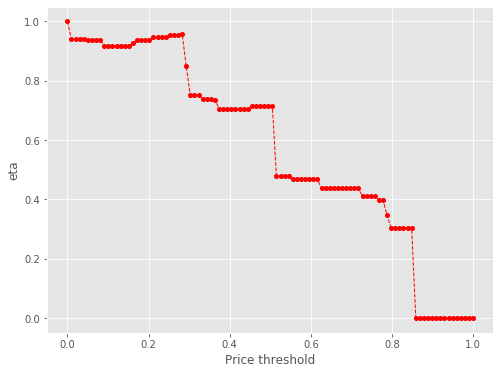

3724 22
Number of cells with price above 58.00000000000001th percentile:  22


eta =  1.0
eta =  0.9971904161801004
eta =  0.9971904161801004
eta =  0.9971904161801004
eta =  0.9971904161801004
eta =  0.9746863033072884
eta =  0.9746863033072884
eta =  0.9746863033072884
eta =  0.9746863033072884
eta =  0.9746863033072884
eta =  0.9746863033072884
eta =  0.9746863033072884
eta =  0.9964187464674348
eta =  0.9964187464674348
eta =  0.9964187464674348
eta =  0.9964187464674348
eta =  0.9964187464674348
eta =  1.0051814645370085
eta =  1.0051814645370085
eta =  1.0051814645370085
eta =  1.0051814645370085
eta =  1.0130870439175603
eta =  1.0130870439175603
eta =  1.0130870439175603
eta =  1.019236485336663
eta =  0.9015739021636155
eta =  0.9015739021636155
eta =  0.7980499661867164
eta =  0.7980499661867164
eta =  0.7980499661867164
eta =  0.785236822649632
eta =  0.785236822649632
eta =  0.7819965139076519
eta =  0.7819965139076519
eta =  0.7499908390010168
eta =  0.7499908390010168
eta =  0.7499908390010168
eta =  0.7499908390010168
eta =  0.7499908390010168
eta 

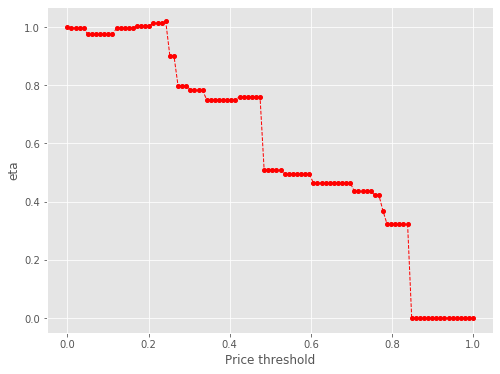

3724 22
Number of cells with price above 59.0th percentile:  22


eta =  1.0
eta =  0.9971904161801004
eta =  0.9971904161801004
eta =  0.9971904161801004
eta =  0.9971904161801004
eta =  0.9746863033072884
eta =  0.9746863033072884
eta =  0.9746863033072884
eta =  0.9746863033072884
eta =  0.9746863033072884
eta =  0.9746863033072884
eta =  0.9746863033072884
eta =  0.9964187464674348
eta =  0.9964187464674348
eta =  0.9964187464674348
eta =  0.9964187464674348
eta =  0.9964187464674348
eta =  1.0051814645370085
eta =  1.0051814645370085
eta =  1.0051814645370085
eta =  1.0051814645370085
eta =  1.0130870439175603
eta =  1.0130870439175603
eta =  1.0130870439175603
eta =  1.019236485336663
eta =  0.9015739021636155
eta =  0.9015739021636155
eta =  0.7980499661867164
eta =  0.7980499661867164
eta =  0.7980499661867164
eta =  0.785236822649632
eta =  0.785236822649632
eta =  0.7819965139076519
eta =  0.7819965139076519
eta =  0.7499908390010168
eta =  0.7499908390010168
eta =  0.7499908390010168
eta =  0.7499908390010168
eta =  0.7499908390010168
eta 

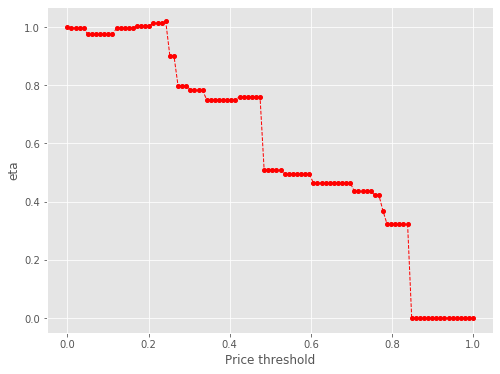

3724 21
Number of cells with price above 60.0th percentile:  21


eta =  1.0
eta =  0.977432481793179
eta =  0.977432481793179
eta =  0.977432481793179
eta =  0.977432481793179
eta =  0.977432481793179
eta =  0.977432481793179
eta =  0.977432481793179
eta =  0.9992261561080565
eta =  0.9992261561080565
eta =  0.9992261561080565
eta =  0.9992261561080565
eta =  0.9992261561080565
eta =  1.0080135631342297
eta =  1.0080135631342297
eta =  1.0080135631342297
eta =  1.0080135631342297
eta =  1.0080135631342297
eta =  1.0159414164832776
eta =  1.0159414164832776
eta =  1.0159414164832776
eta =  1.0221081839524828
eta =  0.9041140864723115
eta =  0.9041140864723115
eta =  0.8002984718242443
eta =  0.8002984718242443
eta =  0.8002984718242443
eta =  0.7874492272575273
eta =  0.7874492272575273
eta =  0.784199788946244
eta =  0.784199788946244
eta =  0.7521039380562625
eta =  0.7521039380562625
eta =  0.7521039380562625
eta =  0.7521039380562625
eta =  0.7521039380562625
eta =  0.7521039380562625
eta =  0.7521039380562625
eta =  0.7521039380562625
eta =  0.7

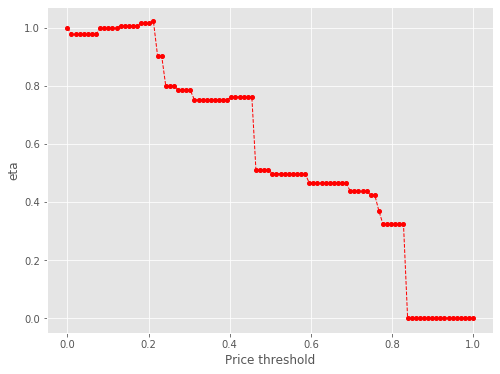

3724 21
Number of cells with price above 61.0th percentile:  21


eta =  1.0
eta =  0.977432481793179
eta =  0.977432481793179
eta =  0.977432481793179
eta =  0.977432481793179
eta =  0.977432481793179
eta =  0.977432481793179
eta =  0.977432481793179
eta =  0.9992261561080565
eta =  0.9992261561080565
eta =  0.9992261561080565
eta =  0.9992261561080565
eta =  0.9992261561080565
eta =  1.0080135631342297
eta =  1.0080135631342297
eta =  1.0080135631342297
eta =  1.0080135631342297
eta =  1.0080135631342297
eta =  1.0159414164832776
eta =  1.0159414164832776
eta =  1.0159414164832776
eta =  1.0221081839524828
eta =  0.9041140864723115
eta =  0.9041140864723115
eta =  0.8002984718242443
eta =  0.8002984718242443
eta =  0.8002984718242443
eta =  0.7874492272575273
eta =  0.7874492272575273
eta =  0.784199788946244
eta =  0.784199788946244
eta =  0.7521039380562625
eta =  0.7521039380562625
eta =  0.7521039380562625
eta =  0.7521039380562625
eta =  0.7521039380562625
eta =  0.7521039380562625
eta =  0.7521039380562625
eta =  0.7521039380562625
eta =  0.7

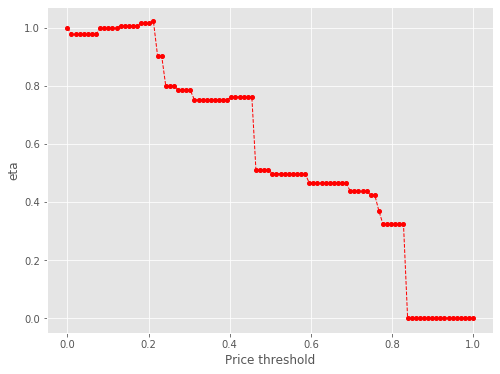

3724 20
Number of cells with price above 62.0th percentile:  20


eta =  1.0
eta =  1.022296859088308
eta =  1.022296859088308
eta =  1.022296859088308
eta =  1.022296859088308
eta =  1.022296859088308
eta =  1.0312871547761
eta =  1.0312871547761
eta =  1.0312871547761
eta =  1.0312871547761
eta =  1.0312871547761
eta =  1.0393980509215848
eta =  1.0393980509215848
eta =  1.0393980509215848
eta =  1.045707200232739
eta =  1.045707200232739
eta =  0.9249887877816799
eta =  0.8187762190550819
eta =  0.8187762190550819
eta =  0.8187762190550819
eta =  0.8187762190550819
eta =  0.8056303038066507
eta =  0.8056303038066507
eta =  0.8056303038066507
eta =  0.8023058406116871
eta =  0.8023058406116871
eta =  0.7694689424239994
eta =  0.7694689424239994
eta =  0.7694689424239994
eta =  0.7694689424239994
eta =  0.7694689424239994
eta =  0.7694689424239994
eta =  0.7694689424239994
eta =  0.7694689424239994
eta =  0.7694689424239994
eta =  0.7801804375739262
eta =  0.7801804375739262
eta =  0.7801804375739262
eta =  0.7801804375739262
eta =  0.78018043757392

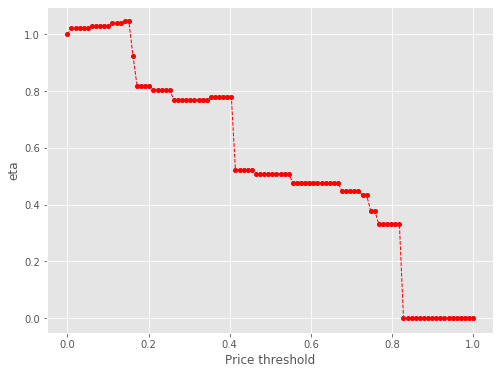

3724 20
Number of cells with price above 63.0th percentile:  20


eta =  1.0
eta =  1.022296859088308
eta =  1.022296859088308
eta =  1.022296859088308
eta =  1.022296859088308
eta =  1.022296859088308
eta =  1.0312871547761
eta =  1.0312871547761
eta =  1.0312871547761
eta =  1.0312871547761
eta =  1.0312871547761
eta =  1.0393980509215848
eta =  1.0393980509215848
eta =  1.0393980509215848
eta =  1.045707200232739
eta =  1.045707200232739
eta =  0.9249887877816799
eta =  0.8187762190550819
eta =  0.8187762190550819
eta =  0.8187762190550819
eta =  0.8187762190550819
eta =  0.8056303038066507
eta =  0.8056303038066507
eta =  0.8056303038066507
eta =  0.8023058406116871
eta =  0.8023058406116871
eta =  0.7694689424239994
eta =  0.7694689424239994
eta =  0.7694689424239994
eta =  0.7694689424239994
eta =  0.7694689424239994
eta =  0.7694689424239994
eta =  0.7694689424239994
eta =  0.7694689424239994
eta =  0.7694689424239994
eta =  0.7801804375739262
eta =  0.7801804375739262
eta =  0.7801804375739262
eta =  0.7801804375739262
eta =  0.78018043757392

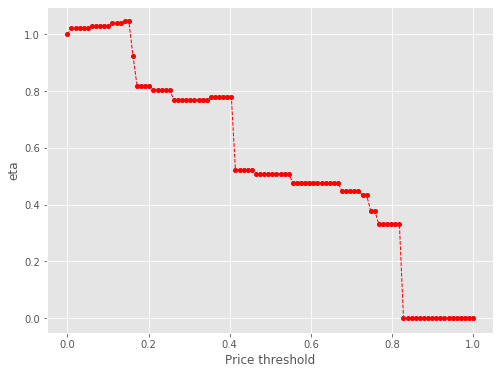

3724 19
Number of cells with price above 64.0th percentile:  19


eta =  1.0
eta =  1.0101541177733644
eta =  1.0101541177733644
eta =  1.0101541177733644
eta =  1.0101541177733644
eta =  1.0101541177733644
eta =  1.019037627615234
eta =  1.019037627615234
eta =  1.019037627615234
eta =  1.019037627615234
eta =  1.019037627615234
eta =  1.0270521833358692
eta =  1.0270521833358692
eta =  1.0270521833358692
eta =  1.033286393193457
eta =  0.9140018621451551
eta =  0.9140018621451551
eta =  0.8090508758395312
eta =  0.8090508758395312
eta =  0.8090508758395312
eta =  0.8090508758395312
eta =  0.7960611064765056
eta =  0.7960611064765056
eta =  0.7927761309276485
eta =  0.7927761309276485
eta =  0.760329266179596
eta =  0.760329266179596
eta =  0.760329266179596
eta =  0.760329266179596
eta =  0.760329266179596
eta =  0.760329266179596
eta =  0.760329266179596
eta =  0.760329266179596
eta =  0.760329266179596
eta =  0.7709135312460635
eta =  0.7709135312460635
eta =  0.7709135312460635
eta =  0.7709135312460635
eta =  0.7709135312460635
eta =  0.7709135

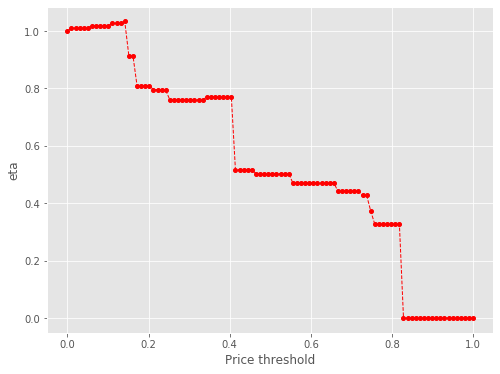

3724 18
Number of cells with price above 65.0th percentile:  18


eta =  1.0
eta =  1.008794212373703
eta =  1.008794212373703
eta =  1.008794212373703
eta =  1.008794212373703
eta =  1.008794212373703
eta =  1.016728205394789
eta =  1.016728205394789
eta =  1.016728205394789
eta =  1.0228997486750655
eta =  0.9048142714696316
eta =  0.9048142714696316
eta =  0.8009182575257766
eta =  0.8009182575257766
eta =  0.8009182575257766
eta =  0.8009182575257766
eta =  0.7880590619491074
eta =  0.7880590619491074
eta =  0.7880590619491074
eta =  0.7848071071324523
eta =  0.7848071071324523
eta =  0.7526863998293194
eta =  0.7526863998293194
eta =  0.7526863998293194
eta =  0.7526863998293194
eta =  0.7526863998293194
eta =  0.7526863998293194
eta =  0.7526863998293194
eta =  0.7526863998293194
eta =  0.7526863998293194
eta =  0.7526863998293194
eta =  0.7631642713543081
eta =  0.7631642713543081
eta =  0.7631642713543081
eta =  0.7631642713543081
eta =  0.7631642713543081
eta =  0.7631642713543081
eta =  0.7631642713543081
eta =  0.5114346154786326
eta =  0.

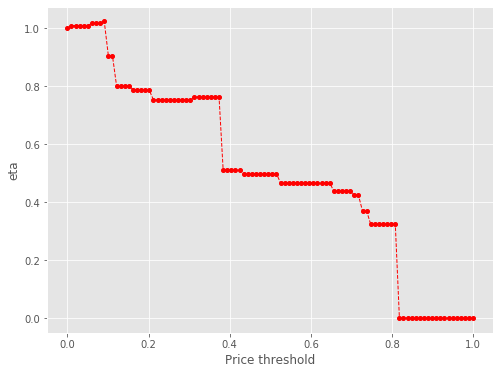

3724 18
Number of cells with price above 66.0th percentile:  18


eta =  1.0
eta =  1.008794212373703
eta =  1.008794212373703
eta =  1.008794212373703
eta =  1.008794212373703
eta =  1.008794212373703
eta =  1.016728205394789
eta =  1.016728205394789
eta =  1.016728205394789
eta =  1.0228997486750655
eta =  0.9048142714696316
eta =  0.9048142714696316
eta =  0.8009182575257766
eta =  0.8009182575257766
eta =  0.8009182575257766
eta =  0.8009182575257766
eta =  0.7880590619491074
eta =  0.7880590619491074
eta =  0.7880590619491074
eta =  0.7848071071324523
eta =  0.7848071071324523
eta =  0.7526863998293194
eta =  0.7526863998293194
eta =  0.7526863998293194
eta =  0.7526863998293194
eta =  0.7526863998293194
eta =  0.7526863998293194
eta =  0.7526863998293194
eta =  0.7526863998293194
eta =  0.7526863998293194
eta =  0.7526863998293194
eta =  0.7631642713543081
eta =  0.7631642713543081
eta =  0.7631642713543081
eta =  0.7631642713543081
eta =  0.7631642713543081
eta =  0.7631642713543081
eta =  0.7631642713543081
eta =  0.5114346154786326
eta =  0.

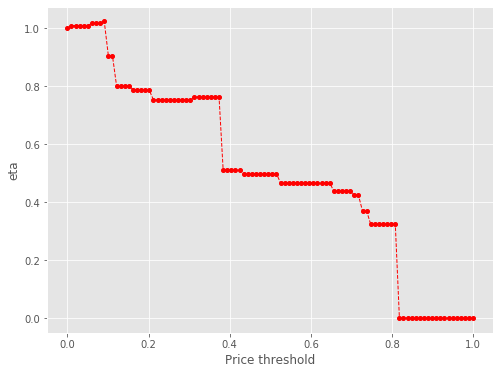

3724 17
Number of cells with price above 67.0th percentile:  17


eta =  1.0
eta =  1.0078648280529061
eta =  1.0078648280529061
eta =  1.0078648280529061
eta =  1.0139825706059238
eta =  0.8969265092635637
eta =  0.8969265092635637
eta =  0.7939362138500059
eta =  0.7939362138500059
eta =  0.7939362138500059
eta =  0.7939362138500059
eta =  0.7811891189331829
eta =  0.7811891189331829
eta =  0.7811891189331829
eta =  0.7779655131900421
eta =  0.7779655131900421
eta =  0.7461248197075205
eta =  0.7461248197075205
eta =  0.7461248197075205
eta =  0.7461248197075205
eta =  0.7461248197075205
eta =  0.7461248197075205
eta =  0.7461248197075205
eta =  0.7461248197075205
eta =  0.7461248197075205
eta =  0.7461248197075205
eta =  0.7461248197075205
eta =  0.7565113498803435
eta =  0.7565113498803435
eta =  0.7565113498803435
eta =  0.7565113498803435
eta =  0.7565113498803435
eta =  0.7565113498803435
eta =  0.7565113498803435
eta =  0.5069761594639026
eta =  0.5069761594639026
eta =  0.5069761594639026
eta =  0.5069761594639026
eta =  0.5069761594639026
e

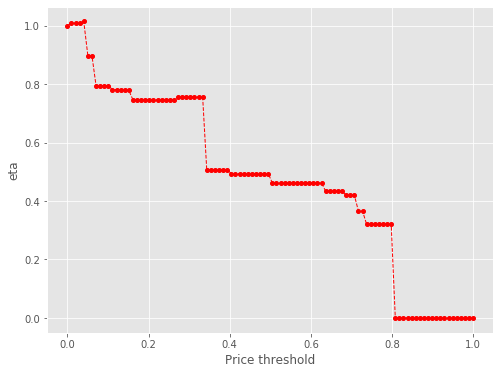

3724 16
Number of cells with price above 68.0th percentile:  16


eta =  1.0
eta =  1.0060700030229615
eta =  0.8899273834134444
eta =  0.8899273834134444
eta =  0.7877407681581777
eta =  0.7877407681581777
eta =  0.7877407681581777
eta =  0.7877407681581777
eta =  0.7750931446257154
eta =  0.7750931446257154
eta =  0.7750931446257154
eta =  0.7718946941456362
eta =  0.7718946941456362
eta =  0.7718946941456362
eta =  0.7403024680888597
eta =  0.7403024680888597
eta =  0.7403024680888597
eta =  0.7403024680888597
eta =  0.7403024680888597
eta =  0.7403024680888597
eta =  0.7403024680888597
eta =  0.7403024680888597
eta =  0.7403024680888597
eta =  0.7403024680888597
eta =  0.7506079474385942
eta =  0.7506079474385942
eta =  0.7506079474385942
eta =  0.7506079474385942
eta =  0.7506079474385942
eta =  0.7506079474385942
eta =  0.7506079474385942
eta =  0.7506079474385942
eta =  0.5030199937062293
eta =  0.5030199937062293
eta =  0.5030199937062293
eta =  0.5030199937062293
eta =  0.5030199937062293
eta =  0.5030199937062293
eta =  0.49010186191014304


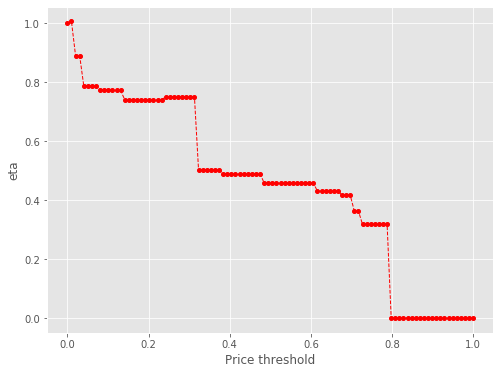

3724 15
Number of cells with price above 69.0th percentile:  15


eta =  1.0
eta =  0.8845581129935881
eta =  0.782988028458492
eta =  0.782988028458492
eta =  0.782988028458492
eta =  0.782988028458492
eta =  0.782988028458492
eta =  0.7704167128497772
eta =  0.7704167128497772
eta =  0.7704167128497772
eta =  0.7672375598380894
eta =  0.7672375598380894
eta =  0.735835941698347
eta =  0.735835941698347
eta =  0.735835941698347
eta =  0.735835941698347
eta =  0.735835941698347
eta =  0.735835941698347
eta =  0.735835941698347
eta =  0.735835941698347
eta =  0.735835941698347
eta =  0.735835941698347
eta =  0.735835941698347
eta =  0.7460792441711068
eta =  0.7460792441711068
eta =  0.7460792441711068
eta =  0.7460792441711068
eta =  0.7460792441711068
eta =  0.7460792441711068
eta =  0.7460792441711068
eta =  0.7460792441711068
eta =  0.4999850827425464
eta =  0.4999850827425464
eta =  0.4999850827425464
eta =  0.4999850827425464
eta =  0.4999850827425464
eta =  0.4999850827425464
eta =  0.4871448909494596
eta =  0.4871448909494596
eta =  0.48714489

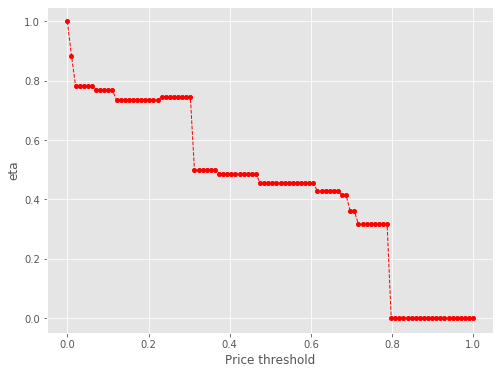

3724 14
Number of cells with price above 70.0th percentile:  14


eta =  1.0
eta =  0.885174209536833
eta =  0.885174209536833
eta =  0.885174209536833
eta =  0.885174209536833
eta =  0.870962237000433
eta =  0.870962237000433
eta =  0.870962237000433
eta =  0.8673681791708928
eta =  0.8673681791708928
eta =  0.8318683994747114
eta =  0.8318683994747114
eta =  0.8318683994747114
eta =  0.8318683994747114
eta =  0.8318683994747114
eta =  0.8318683994747114
eta =  0.8318683994747114
eta =  0.8318683994747114
eta =  0.8318683994747114
eta =  0.8318683994747114
eta =  0.8318683994747114
eta =  0.8434485345978787
eta =  0.8434485345978787
eta =  0.8434485345978787
eta =  0.8434485345978787
eta =  0.8434485345978787
eta =  0.8434485345978787
eta =  0.8434485345978787
eta =  0.8434485345978787
eta =  0.5652371228052606
eta =  0.5652371228052606
eta =  0.5652371228052606
eta =  0.5652371228052606
eta =  0.5652371228052606
eta =  0.5652371228052606
eta =  0.5652371228052606
eta =  0.5507211835984718
eta =  0.5507211835984718
eta =  0.5507211835984718
eta =  0

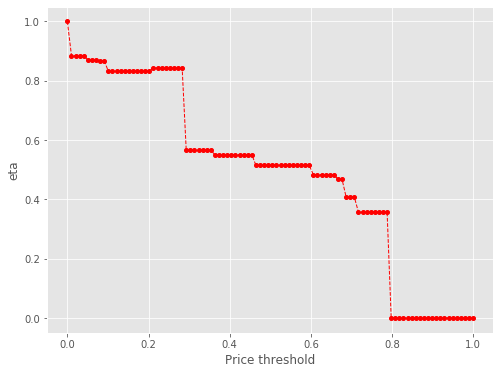

3724 13
Number of cells with price above 71.00000000000001th percentile:  13


eta =  1.0
eta =  0.9839444344590241
eta =  0.9839444344590241
eta =  0.9839444344590241
eta =  0.9798841514200269
eta =  0.9798841514200269
eta =  0.9397793005175625
eta =  0.9397793005175625
eta =  0.9397793005175625
eta =  0.9397793005175625
eta =  0.9397793005175625
eta =  0.9397793005175625
eta =  0.9397793005175625
eta =  0.9397793005175625
eta =  0.9397793005175625
eta =  0.9397793005175625
eta =  0.9397793005175625
eta =  0.9397793005175625
eta =  0.9528616237465988
eta =  0.9528616237465988
eta =  0.9528616237465988
eta =  0.9528616237465988
eta =  0.9528616237465988
eta =  0.9528616237465988
eta =  0.9528616237465988
eta =  0.9528616237465988
eta =  0.6385603158287007
eta =  0.6385603158287007
eta =  0.6385603158287007
eta =  0.6385603158287007
eta =  0.6385603158287007
eta =  0.6385603158287007
eta =  0.6385603158287007
eta =  0.6221613527202022
eta =  0.6221613527202022
eta =  0.6221613527202022
eta =  0.6221613527202022
eta =  0.6221613527202022
eta =  0.6221613527202022
e

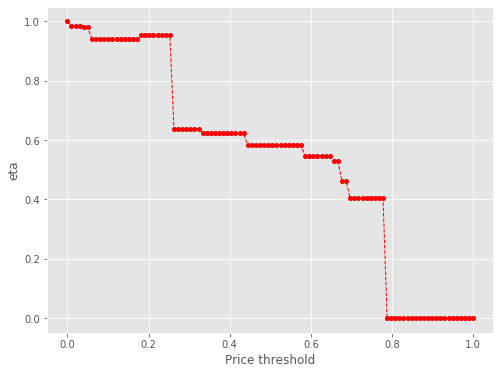

3724 12
Number of cells with price above 72.0th percentile:  12


eta =  1.0
eta =  0.995873463076978
eta =  0.995873463076978
eta =  0.9551141991409874
eta =  0.9551141991409874
eta =  0.9551141991409874
eta =  0.9551141991409874
eta =  0.9551141991409874
eta =  0.9551141991409874
eta =  0.9551141991409874
eta =  0.9551141991409874
eta =  0.9551141991409874
eta =  0.9551141991409874
eta =  0.9551141991409874
eta =  0.9551141991409874
eta =  0.9684099938737751
eta =  0.9684099938737751
eta =  0.9684099938737751
eta =  0.9684099938737751
eta =  0.9684099938737751
eta =  0.9684099938737751
eta =  0.9684099938737751
eta =  0.9684099938737751
eta =  0.9684099938737751
eta =  0.6489800576795612
eta =  0.6489800576795612
eta =  0.6489800576795612
eta =  0.6489800576795612
eta =  0.6489800576795612
eta =  0.6489800576795612
eta =  0.6323135036200175
eta =  0.6323135036200175
eta =  0.6323135036200175
eta =  0.6323135036200175
eta =  0.6323135036200175
eta =  0.6323135036200175
eta =  0.6323135036200175
eta =  0.6323135036200175
eta =  0.6323135036200175
eta

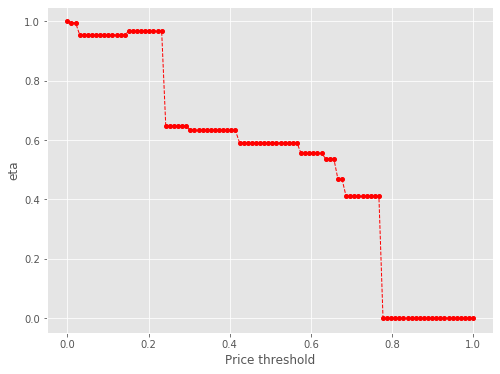

3724 11
Number of cells with price above 73.0th percentile:  11


eta =  1.0
eta =  0.9590718445192268
eta =  0.9590718445192268
eta =  0.9590718445192268
eta =  0.9590718445192268
eta =  0.9590718445192268
eta =  0.9590718445192268
eta =  0.9590718445192268
eta =  0.9590718445192268
eta =  0.9590718445192268
eta =  0.9590718445192268
eta =  0.9590718445192268
eta =  0.9590718445192268
eta =  0.9724227321829139
eta =  0.9724227321829139
eta =  0.9724227321829139
eta =  0.9724227321829139
eta =  0.9724227321829139
eta =  0.9724227321829139
eta =  0.9724227321829139
eta =  0.9724227321829139
eta =  0.9724227321829139
eta =  0.6516691946729752
eta =  0.6516691946729752
eta =  0.6516691946729752
eta =  0.6516691946729752
eta =  0.6516691946729752
eta =  0.6516691946729752
eta =  0.6516691946729752
eta =  0.6349335804835494
eta =  0.6349335804835494
eta =  0.6349335804835494
eta =  0.6349335804835494
eta =  0.6349335804835494
eta =  0.6349335804835494
eta =  0.6349335804835494
eta =  0.6349335804835494
eta =  0.6349335804835494
eta =  0.6349335804835494
e

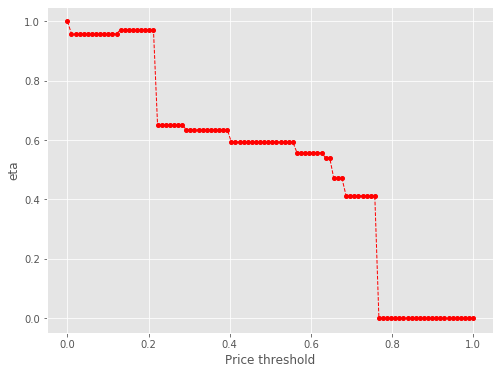

3724 10
Number of cells with price above 74.0th percentile:  10


eta =  1.0
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  0.6794790175491499
eta =  0.6794790175491499
eta =  0.6794790175491499
eta =  0.6794790175491499
eta =  0.6794790175491499
eta =  0.6794790175491499
eta =  0.6794790175491499
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6189821476038523
eta =  0.6189821476038523
eta =  0.6189821476038523
eta =  0.6189821476038523
eta =  0.6189821476038523
eta =  0.6189821476038523
eta =  0.6189821476038523
e

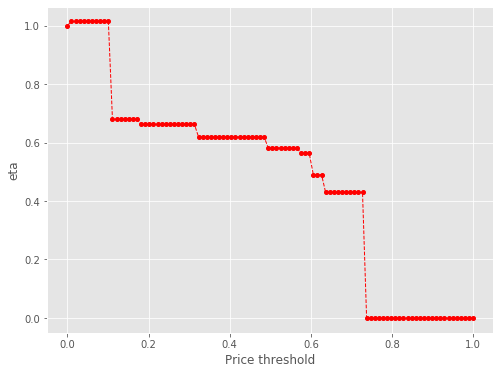

3724 10
Number of cells with price above 75.0th percentile:  10


eta =  1.0
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  0.6794790175491499
eta =  0.6794790175491499
eta =  0.6794790175491499
eta =  0.6794790175491499
eta =  0.6794790175491499
eta =  0.6794790175491499
eta =  0.6794790175491499
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6189821476038523
eta =  0.6189821476038523
eta =  0.6189821476038523
eta =  0.6189821476038523
eta =  0.6189821476038523
eta =  0.6189821476038523
eta =  0.6189821476038523
e

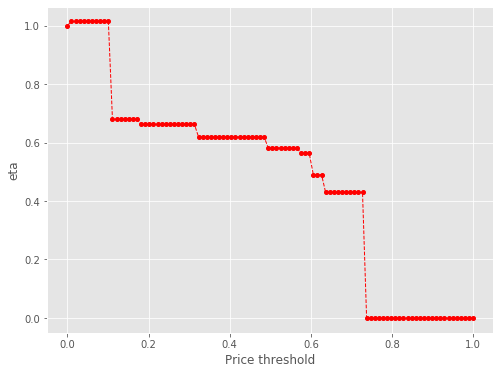

3724 10
Number of cells with price above 76.0th percentile:  10


eta =  1.0
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  1.0139206335166473
eta =  0.6794790175491499
eta =  0.6794790175491499
eta =  0.6794790175491499
eta =  0.6794790175491499
eta =  0.6794790175491499
eta =  0.6794790175491499
eta =  0.6794790175491499
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6620292151333411
eta =  0.6189821476038523
eta =  0.6189821476038523
eta =  0.6189821476038523
eta =  0.6189821476038523
eta =  0.6189821476038523
eta =  0.6189821476038523
eta =  0.6189821476038523
e

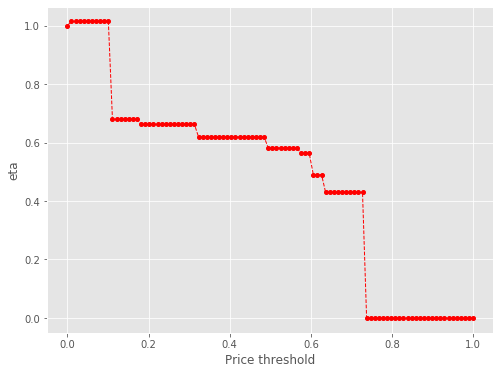

3724 9
Number of cells with price above 77.0th percentile:  9


eta =  1.0
eta =  0.670150103556398
eta =  0.670150103556398
eta =  0.670150103556398
eta =  0.670150103556398
eta =  0.670150103556398
eta =  0.670150103556398
eta =  0.670150103556398
eta =  0.670150103556398
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.

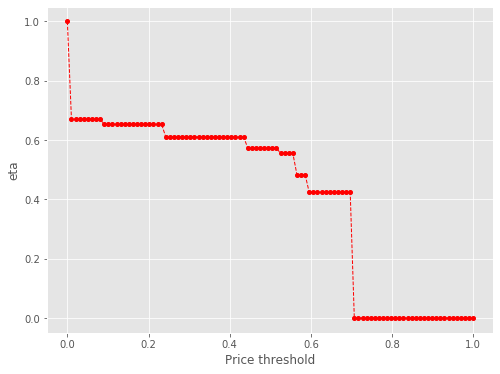

3724 9
Number of cells with price above 78.0th percentile:  9


eta =  1.0
eta =  0.670150103556398
eta =  0.670150103556398
eta =  0.670150103556398
eta =  0.670150103556398
eta =  0.670150103556398
eta =  0.670150103556398
eta =  0.670150103556398
eta =  0.670150103556398
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6529398783780361
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.6104838259943444
eta =  0.

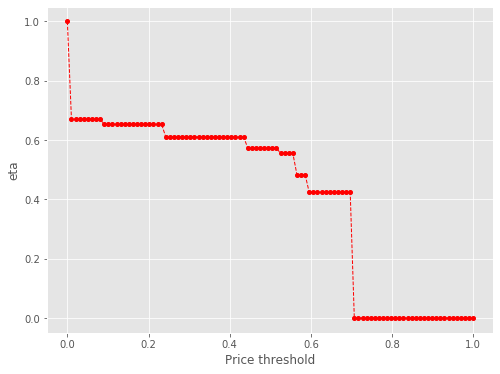

3724 8
Number of cells with price above 79.0th percentile:  8


eta =  1.0
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.8559066452800315
eta =  0.8559066452800

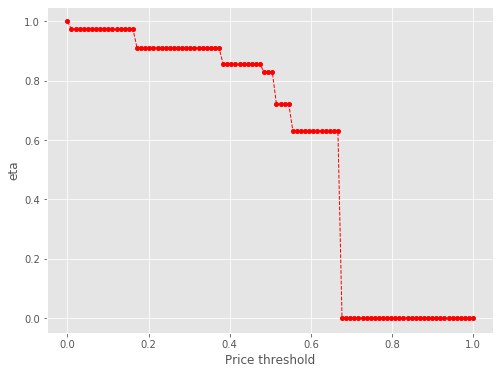

3724 8
Number of cells with price above 80.0th percentile:  8


eta =  1.0
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.9743188502291807
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.910965801175867
eta =  0.8559066452800315
eta =  0.8559066452800

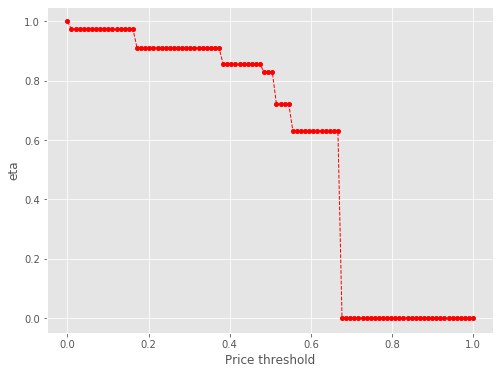

3724 7
Number of cells with price above 81.0th percentile:  7


eta =  1.0
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8505385152576427
e

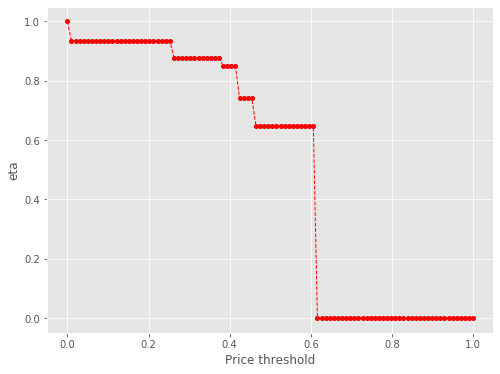

3724 7
Number of cells with price above 82.0th percentile:  7


eta =  1.0
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8505385152576427
e

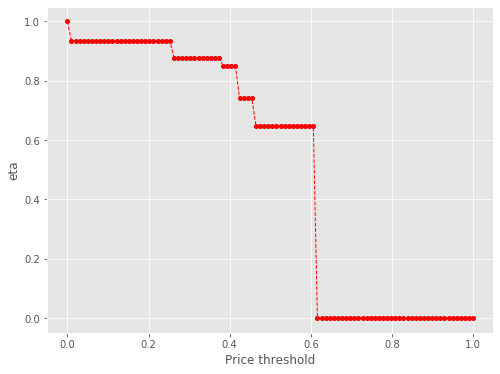

3724 7
Number of cells with price above 83.0th percentile:  7


eta =  1.0
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.9349770877999416
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8784666796487657
eta =  0.8505385152576427
e

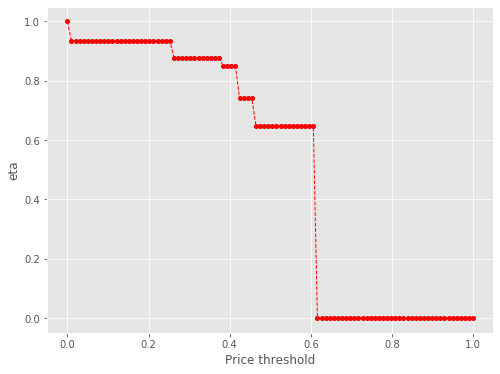

3724 6
Number of cells with price above 84.00000000000001th percentile:  6


eta =  1.0
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
e

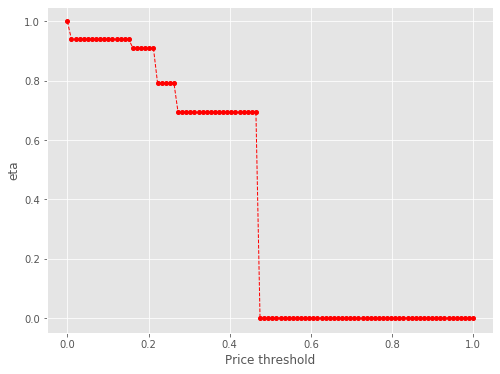

3724 6
Number of cells with price above 85.0th percentile:  6


eta =  1.0
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
e

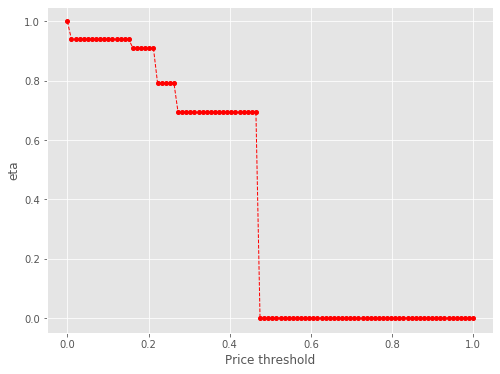

3724 6
Number of cells with price above 86.0th percentile:  6


eta =  1.0
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
e

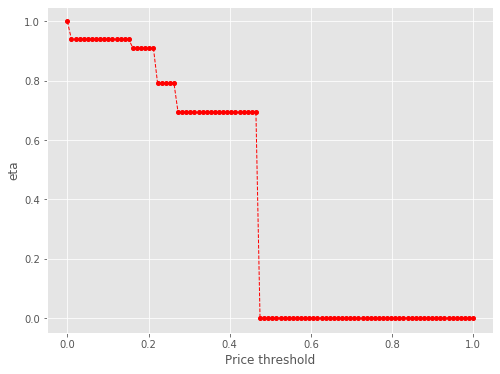

3724 6
Number of cells with price above 87.0th percentile:  6


eta =  1.0
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
e

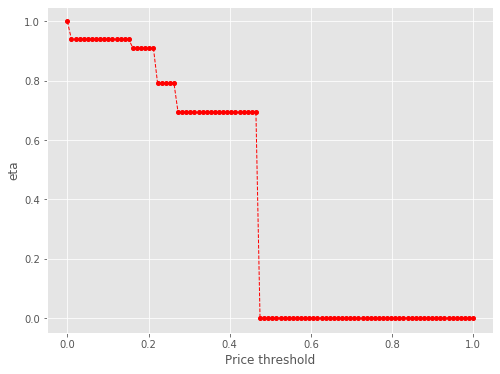

3724 6
Number of cells with price above 88.0th percentile:  6


eta =  1.0
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9395595797067623
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.9096891531951996
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.7924105893466098
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
eta =  0.6938072129793964
e

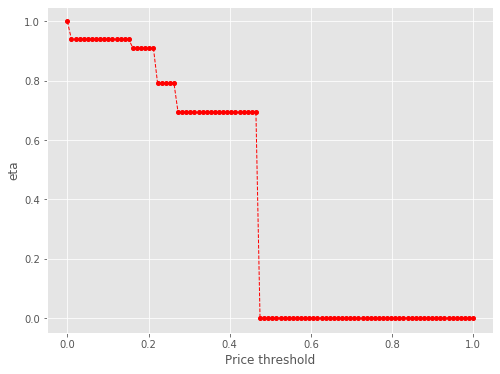

3724 5
Number of cells with price above 89.0th percentile:  5


eta =  1.0
eta =  0.9682080549688129
eta =  0.9682080549688129
eta =  0.9682080549688129
eta =  0.9682080549688129
eta =  0.9682080549688129
eta =  0.9682080549688129
eta =  0.8433851417851779
eta =  0.8433851417851779
eta =  0.8433851417851779
eta =  0.8433851417851779
eta =  0.8433851417851779
eta =  0.8433851417851779
eta =  0.8433851417851779
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  0.7384387621229241
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  na

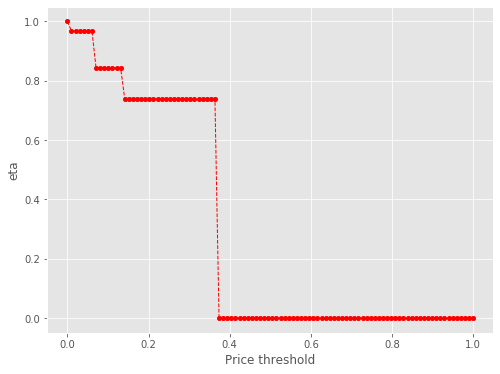

3724 4
Number of cells with price above 90.0th percentile:  4


eta =  1.0
eta =  0.8710784189998753
eta =  0.8710784189998753
eta =  0.8710784189998753
eta =  0.8710784189998753
eta =  0.8710784189998753
eta =  0.8710784189998753
eta =  0.8710784189998753
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  0.762686034611342
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta = 

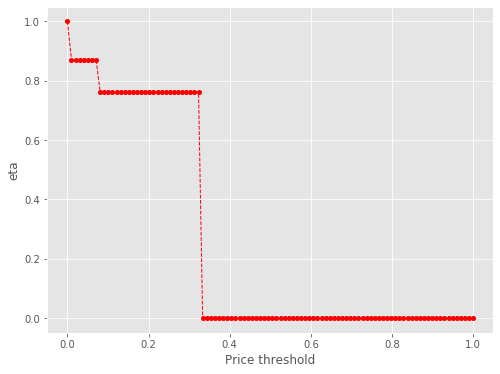

3724 3
Number of cells with price above 91.0th percentile:  3


eta =  1.0
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  0.8755652969649007
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =

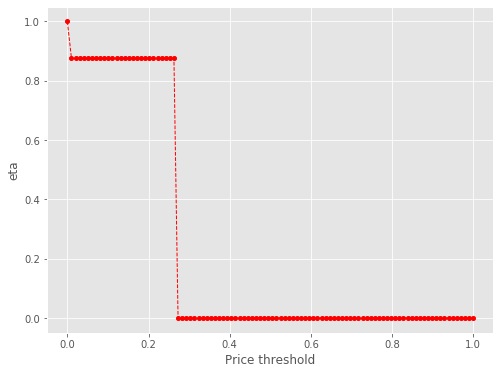

3724 2
Number of cells with price above 92.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

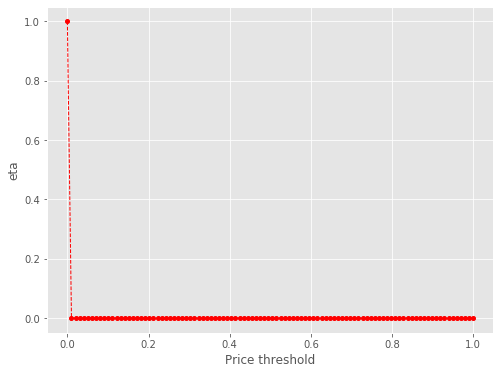

3724 2
Number of cells with price above 93.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

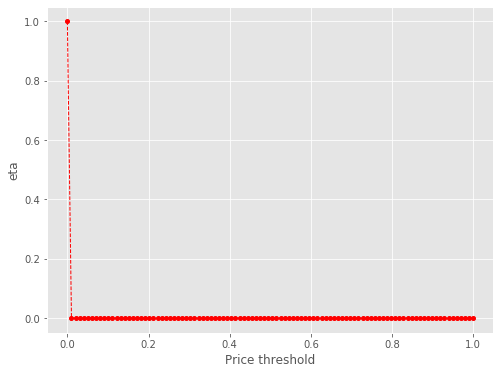

3724 1
Number of cells with price above 94.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning:

invalid value encountered in true_divide



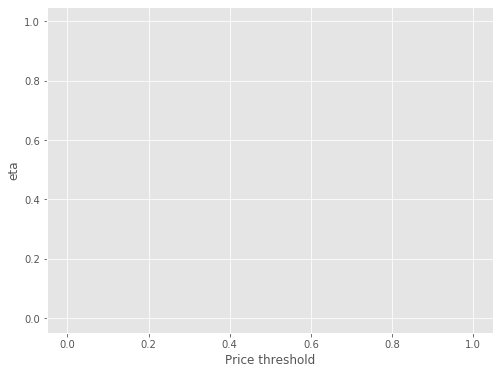

3724 1
Number of cells with price above 95.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

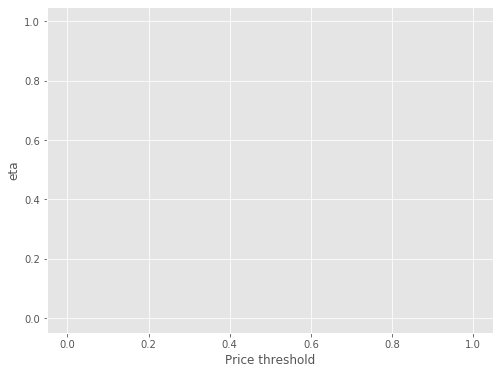

3724 1
Number of cells with price above 96.00000000000001th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

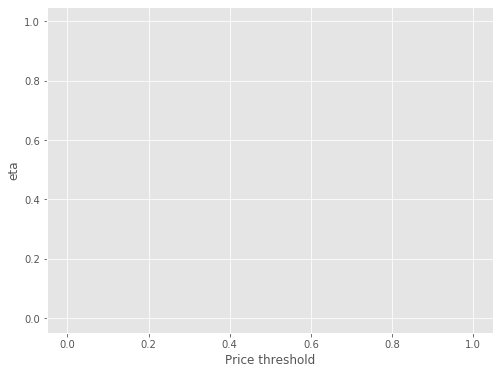

3724 1
Number of cells with price above 97.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

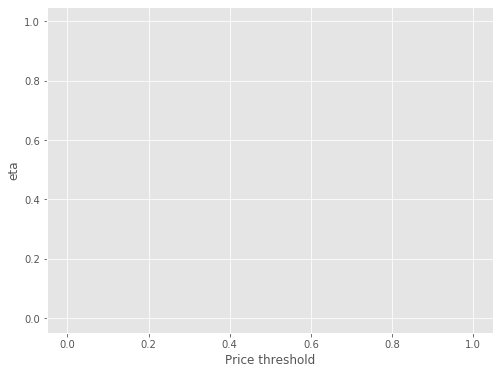

3724 1
Number of cells with price above 98.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

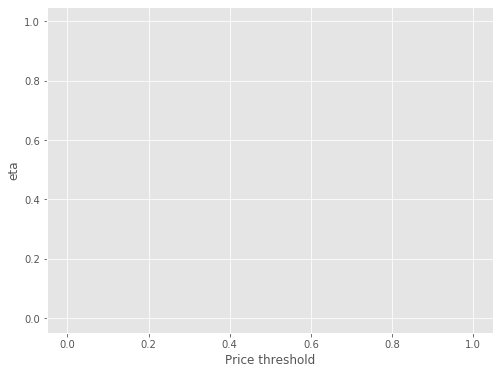

3724 1
Number of cells with price above 99.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

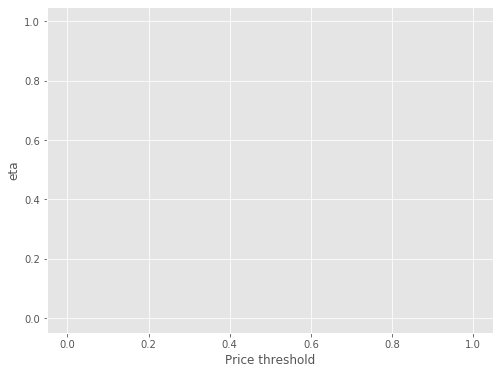

3724 1
Number of cells with price above 100.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

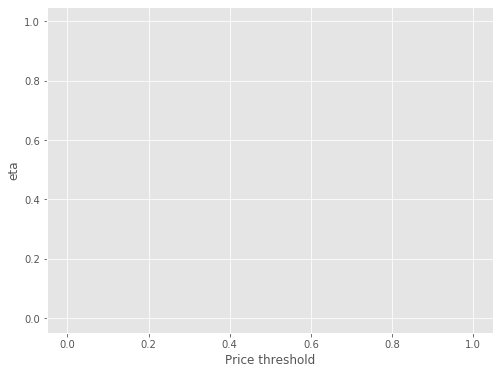


time: 1min 12s


In [33]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
#keys = np.array(keys)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_2d = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    etas = []
    lval = np.linspace(min(vals_cut), max(vals_cut), 100)
    for k in tqdm_notebook(lval):
        loubar_keys = keys[vals_cut>=k]
        dist_mat = mat[keys.reshape(-1,1), keys]

        total_dist = dist_mat.sum()
        dist_corr = dist_mat[dist_mat>0]

        loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

        loubar_dist = loubar_dist_mat.sum()

        loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
        eta = loubar_dist_corr.mean()/dist_corr.mean()
        etas.append(eta)
        print('eta = ', eta)
    etas_array = np.array(etas)
    etas_array = np.where(np.isnan(etas_array), 0, etas_array)
    lval = (lval - lval.min())/(lval - lval.min()).max()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(lval, etas_array, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
    plt.xlabel("Price threshold")
    plt.ylabel("eta")
    plt.show()
    etas_2d.append(etas)
etas_2d = np.array(etas_2d)
etas_2d = np.where(np.isnan(etas_2d), 0, etas_2d)
lval = lval/lval.max()


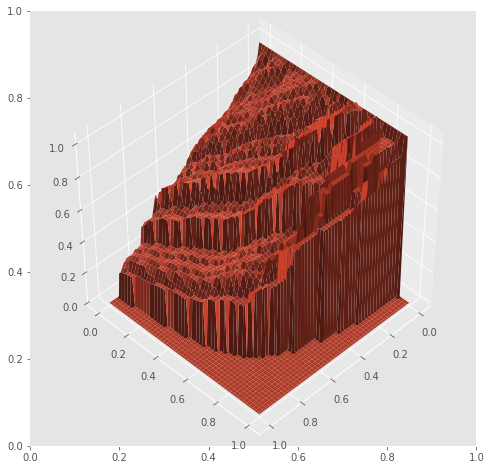

time: 1.14 s


In [34]:
X,Y = np.meshgrid(np.linspace(0,1, 100),np.linspace(0,1, 100))
etas_surface = etas_2d
fig, ax = plt.subplots(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot a 3D surface
ax.plot_surface(X, Y, etas_surface)
ax.view_init(45, 45)
plt.show()

In [35]:
pickle_in = open("etas_surface_dict.pickle","rb")
etas_surface_dict = pickle.load(pickle_in)
#etas_surface_dict = {}
etas_surface_dict['Aarhus'] = etas_surface


pickle_out = open("etas_surface_dict.pickle","wb")
pickle.dump(etas_surface_dict, pickle_out)
pickle_out.close()

etas_surface_dict

{'NY': array([[1.        , 0.40697941, 0.38848337, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.95418349, 0.92471336, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96911482, 0.94572765, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'Boston': array([[1.        , 0.49308111, 0.46754658, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.94621367, 0.92299712, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.97340556, 0.95206791, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.       

time: 18 ms


3724 141
Number of cells with price above 5th percentile:  141
total number of cells:  3724
number of cells within urban airbnb territory:  141



Mean travel times in minutes:  7.577700817839116
Mean travel times in minutes:  14.148674238067853


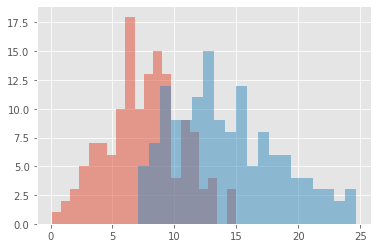

time: 36.6 s


In [36]:
from tqdm import tqdm_notebook

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

print('total number of cells: ', len(polylist))

times_names = ['times_{}'.format(c) for c in range(1, len(centers)+1)]
times_dict = {name:[] for name in times_names}

plist = poly_prices[poly_prices.index.isin(keys)].geometry.tolist()
print('number of cells within urban airbnb territory: ', len(plist))
for poly in tqdm_notebook(plist):
    origin = ox.get_nearest_node(G, poly.centroid.coords[0][::-1])
    dists_to_centers = []
    for node, target in centers.items():
        try:
            if origin!=target:
                path = nx.shortest_path(G, origin, target, weight='length')
                edges = [ tuple( path[i:i+2] ) for i in range( len(path) - 1 ) ]
                dist = np.sum([G.get_edge_data(*edge)[0]['length'] for edge in edges])
                dists_to_centers.append(dist)
        except:
            pass
    if len(dists_to_centers) != 0:
        dists_to_centers = sorted(dists_to_centers)
        #print('distance list length equal to # of centers: ', len(dists_to_centers)==len(centers))
        if len(dists_to_centers)==len(centers):
            for n, dist in enumerate(dists_to_centers):
                time = (dist/3.7)/60
                times_dict['times_{}'.format(n+1)].append(time)
                #print(times_dict['times_{}'.format(n+1)][-1])
        else:
            print('Distance list length NOT equal to # of centers')

#print(distances_dict)
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=0.5)
plt.show()

Mean travel times in minutes:  7.577700817839116
Mean travel times in minutes:  14.148674238067853


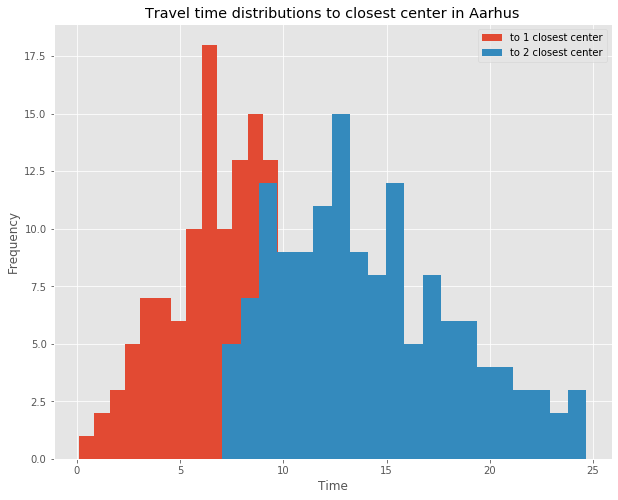

time: 360 ms


In [37]:
for center in range(1, len(centers)+1):
    times_dict['times_{}'.format(center)] = np.array(times_dict['times_{}'.format(center)])
    
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))

fig, ax = plt.subplots(figsize=(10,8))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=1, label='to {} closest center'.format(center))
plt.title('Travel time distributions to closest center in Aarhus')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [38]:
pickle_in = open("City_Accessibility.pickle","rb")
access_dict = pickle.load(pickle_in)
#access_dict = {}
access_dict['Aarhus'] = times_dict

pickle_out = open("City_Accessibility.pickle","wb")
pickle.dump(access_dict, pickle_out)
pickle_out.close()

access_dict

{'Paris': {'times_1': array([ 4.73219737,  4.40047807,  7.81577632,  7.07926754,  6.7129386 ,
          7.48037281, 10.85755263,  8.41227193, 14.20045614, 15.15502193,
         16.00692982, 15.80582895, 14.35941228, 14.10681579, 12.26687281,
         13.89203947, 14.31310965, 15.99389474, 16.77728947, 17.82112281,
         20.19769737, 20.40849561, 21.93033333, 22.03087719, 20.6584386 ,
         20.62538596, 19.53197368, 20.61141228, 21.70609211, 23.22407018,
         21.70395614, 23.12607456, 22.79396053, 23.95434211, 21.49400439,
         21.55605702, 22.35374123, 22.36948246, 22.44162719, 21.54410965,
         21.93589912, 21.86757456, 21.86757456, 21.41060088, 21.92571491,
         22.93862281, 23.57200877, 25.13889474, 24.49192982, 26.04400877,
         26.815     , 38.90660088, 38.56507018, 37.89241228, 36.57546491,
         29.87379386, 27.54254825, 25.54755702, 26.98263158, 25.76562281,
         25.03485526, 25.37799123, 25.69687719, 26.07382018, 23.81846491,
         24.034649

time: 547 ms


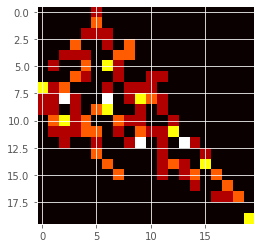

time: 172 ms


In [39]:
x = times_dict['times_{}'.format(1)]
y = times_dict['times_{}'.format(2)]
c_xy = np.histogram2d(x, y, 20)[0]
c_xx = np.histogram2d(x, x, 20)[0]
plt.imshow(c_xy, cmap='hot', interpolation='nearest')
plt.show()

In [40]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

mi_list = []
for center in range(1, len(centers)+1):
    mi_list.append(times_dict['times_{}'.format(center)])

mis = []
for pair in combinations_with_replacement(mi_list, 2):
    MI = calc_MI(pair[0], pair[1], 20)
    print(MI)
    mis.append(MI)
mis = np.array(mis)
avg_mi = np.mean(mis)
print('average mutual information = ', avg_mi)

2.7487383892830275
1.2523267358014025
2.872075404465123
average mutual information =  2.2910468431831847
time: 13 ms


In [2]:
mis

NameError: name 'mis' is not defined

In [41]:
pickle_in = open("Time_distribution_mutual_information.pickle","rb")
MI_dict = pickle.load(pickle_in)
#MI_dict = {}
MI_dict['Aarhus'] = avg_mi


pickle_out = open("Time_distribution_mutual_information.pickle","wb")
pickle.dump(MI_dict, pickle_out)
pickle_out.close()

MI_dict

{'Beijing': 1.6170682943522052,
 'Florence': 2.0836399429599792,
 'Palermo': 1.8596013030930105,
 'Los_Angeles': 1.5602500680599918,
 'Moscow': 1.5631970905638934,
 'Porto': 1.6277816420571996,
 'Prague': 2.176480497902222,
 'Reykjavik': 1.3730161847793374,
 'Riga': 2.240374487910287,
 'Rome': 1.6095563575725969,
 'Seoul': 1.2910685865906735,
 'Siena': 2.7660068415344448,
 'Sydney': 1.2791891753795948,
 'Tallin': 2.3884073435187867,
 'Treviso': 2.631909071373147,
 'Valencia': 2.1872520197930965,
 'Venezia': 2.719891808939249,
 'Verona': 2.7080241467515376,
 'Vicenza': 2.6192607829416756,
 'Vienna': 1.4481542925032476,
 'Wellington': 2.1855226822614866,
 'Zurich': 2.462051055806955,
 'Aarhus': 2.2910468431831847,
 'Milan': 1.6107461389394335,
 'Busan': 1.903641833377143,
 'Barcelona': 1.6449937230537024,
 'Bologna': 2.7317991260148045,
 'Bremen': 1.9447717965210316,
 'Brno': 2.4300669174144036,
 'Budapest': 2.219525897631017,
 'Dublin': 1.830502368836079,
 'Boston': 1.1451275682586615,


time: 5.99 ms
